<a href="https://colab.research.google.com/github/ekomissarov/data-analysis/blob/main/Lifetime_proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing

In [1]:
#@title importing libraries
from google.colab import drive
import pandas as pd
import numpy as np
import time
from datetime import date, datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

sns.set_style("darkgrid")
sns.set_context("paper")

def display_df(df=None):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(df)



In [2]:
#@title mounting Google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#CSV loading

In [3]:
#@title reading original csv
dataset = 1
if dataset == 1:
    sessions = pd.read_csv('gdrive/MyDrive/public_data/sessions.csv')
    sessions['session_start'] = pd.to_datetime(sessions['session_start'])

    orders = pd.read_csv('gdrive/MyDrive/public_data/book_orders.csv')
    orders['event_dt'] = pd.to_datetime(orders['event_dt'])

    adcosts = pd.read_csv('gdrive/MyDrive/public_data/ad_costs_new.csv')
    adcosts['dt'] = pd.to_datetime(adcosts['dt']).dt.date


    events = pd.read_csv('gdrive/MyDrive/public_data/events.csv')
    events['event_time'] = pd.to_datetime(events['event_time'])

    _OBSERVATION_DATE = sessions.session_start.max().date() - timedelta(days=1)  # -1 день если последний день в журнале не полный
    _HORIZON = 7
    _LAST_COHORT = _OBSERVATION_DATE-timedelta(_HORIZON)

elif dataset == 2:
    sessions = pd.read_csv('gdrive/MyDrive/public_data/ch04_final_visits.csv')
    sessions['session_start'] = pd.to_datetime(sessions['session_start'])
    sessions = sessions.drop(columns=['last_ts'])

    orders = pd.read_csv('gdrive/MyDrive/public_data/ch04_final_orders.csv')
    orders['event_dt'] = pd.to_datetime(orders['event_dt'])

    adcosts = pd.read_csv('gdrive/MyDrive/public_data/ch04_final_costs.csv')
    adcosts['dt'] = pd.to_datetime(adcosts['dt']).dt.date
    adcosts = adcosts.groupby(['dt', 'channel']).min().reset_index()


    events = pd.read_csv('gdrive/MyDrive/public_data/ch04_final_events.csv')
    events['event_dt'] = pd.to_datetime(events['event_dt'])
    events.rename(columns={'event_dt': 'event_time', 'user_id': 'uid'}, inplace=True)

    #observation_date = datetime(2020, 1, 1).date()  # момент анализа
    _OBSERVATION_DATE = sessions.session_start.max().date() - timedelta(days=1)   # -1 день если последний день в журнале не полный
    _HORIZON = 7
    _LAST_COHORT = _OBSERVATION_DATE - timedelta(_HORIZON)

print(f"horison: {_HORIZON}, \nLAST_COHORT: {_LAST_COHORT}")

horison: 7, 
LAST_COHORT: 2019-05-06


In [4]:
#@title PREVIEW sessions journal display
print(f"min session start: {sessions.session_start.min()}, \nmax session start: {sessions.session_start.max()}\n")
print(f"unique users: {sessions.user_id.nunique()}\n\n")
display(sessions)

min session start: 2019-05-01 00:00:34, 
max session start: 2019-05-14 23:59:51

unique users: 141419




user_id         region   device  channel  session_duration  \
0        94834909438        Germany   iPhone   Yandex          5.417238   
1       142292250445  United States   iPhone  Organic         33.232475   
2       486879489291  United States      Mac  Organic         33.635569   
3       996478278264        Germany   iPhone   Yandex         76.792801   
4       857023407503  United States  Android  Organic          5.976421   
...              ...            ...      ...      ...               ...   
282932  507281681954  United States       PC  Organic          6.316422   
282933  584727896171         France       PC  Organic         51.814506   
282934  200769562990  United States  Android  Organic         15.380831   
282935  569449250064        Germany   iPhone  Organic         24.139972   
282936  477066637255  United States  Android   Yandex         10.855441   

             session_start  
0      2019-05-01 12:59:48  
1      2019-05-01 21:25:00  
2      2019-05-01 21:18:40  
3      2019-05-01 07:37:52  
4      2019-05-01 01:35:01  
...                    ...  
282932 2019-05-14 06:35:22  
282933 2019-05-14 18:23:01  
282934 2019-05-14 16:20:10  
282935 2019-05-14 09:15:01  
282936 2019-05-14 09:01:11  

[282937 rows x 6 columns]

In [5]:
#@title PREVIEW orders journal display
display(orders)

user_id            event_dt  revenue
0       55519067947 2019-05-01 06:49:16     4.99
1      831753022495 2019-05-01 05:13:14     4.99
2      284598472478 2019-05-01 17:30:59     4.99
3      725363192554 2019-05-01 04:43:16     4.99
4      324356134597 2019-05-01 23:05:43     4.99
...             ...                 ...      ...
21162  353771910308 2019-05-14 19:04:47     4.99
21163  166096415686 2019-05-14 15:24:08     4.99
21164  456767093617 2019-05-14 05:07:56     4.99
21165  352534243935 2019-05-14 23:55:17     4.99
21166  507281681954 2019-05-14 06:35:25     4.99

[21167 rows x 3 columns]

In [6]:
#@title EXAMPLE journal
tmp = sessions[['user_id', 'region', 'device', 'channel', 'session_start']]
tmp = tmp.rename(columns={'session_start': 'event_ts'})
tmp['event_name'] = 'registration/login/other action/card linked'
tmp['other_dimensions...'] = 'other dims for analysis (ex quiz)'
display(tmp[['user_id', 'region', 'device', 'channel', 'other_dimensions...', 'event_name', 'event_ts']])
display(events)

user_id         region   device  channel  \
0        94834909438        Germany   iPhone   Yandex   
1       142292250445  United States   iPhone  Organic   
2       486879489291  United States      Mac  Organic   
3       996478278264        Germany   iPhone   Yandex   
4       857023407503  United States  Android  Organic   
...              ...            ...      ...      ...   
282932  507281681954  United States       PC  Organic   
282933  584727896171         France       PC  Organic   
282934  200769562990  United States  Android  Organic   
282935  569449250064        Germany   iPhone  Organic   
282936  477066637255  United States  Android   Yandex   

                      other_dimensions...  \
0       other dims for analysis (ex quiz)   
1       other dims for analysis (ex quiz)   
2       other dims for analysis (ex quiz)   
3       other dims for analysis (ex quiz)   
4       other dims for analysis (ex quiz)   
...                                   ...   
282932  other dims for analysis (ex quiz)   
282933  other dims for analysis (ex quiz)   
282934  other dims for analysis (ex quiz)   
282935  other dims for analysis (ex quiz)   
282936  other dims for analysis (ex quiz)   

                                         event_name            event_ts  
0       registration/login/other action/card linked 2019-05-01 12:59:48  
1       registration/login/other action/card linked 2019-05-01 21:25:00  
2       registration/login/other action/card linked 2019-05-01 21:18:40  
3       registration/login/other action/card linked 2019-05-01 07:37:52  
4       registration/login/other action/card linked 2019-05-01 01:35:01  
...                                             ...                 ...  
282932  registration/login/other action/card linked 2019-05-14 06:35:22  
282933  registration/login/other action/card linked 2019-05-14 18:23:01  
282934  registration/login/other action/card linked 2019-05-14 16:20:10  
282935  registration/login/other action/card linked 2019-05-14 09:15:01  
282936  registration/login/other action/card linked 2019-05-14 09:01:11  

[282937 rows x 7 columns]

event_name          event_time       uid
0       pageview 2019-08-20 00:27:30  80419792
1       pageview 2019-01-29 08:11:30  74610198
2       pageview 2019-01-29 01:33:02    101714
3       pageview 2019-02-22 19:41:04  90089350
4       pageview 2019-03-04 12:49:09  98247028
...          ...                 ...       ...
15572    payment 2019-04-01 19:27:41  28487647
15573    payment 2019-04-01 19:29:20  28487647
15574    payment 2019-04-01 19:29:23  28487647
15575    payment 2019-04-01 19:29:29  28487647
15576    payment 2019-04-01 19:33:25  28487647

[15577 rows x 3 columns]

In [7]:
#@title PREVIEW adcosts data
display(adcosts)

dt        channel      costs
0   2019-05-01  AnotherSource  1826.0000
1   2019-05-02  AnotherSource  1443.0000
2   2019-05-03  AnotherSource  1508.0000
3   2019-05-04  AnotherSource  1911.0000
4   2019-05-05  AnotherSource  1837.0000
5   2019-05-06  AnotherSource  2192.3000
6   2019-05-07  AnotherSource  1846.9000
7   2019-05-08  AnotherSource  1664.3000
8   2019-05-09  AnotherSource  1653.3000
9   2019-05-10  AnotherSource  1931.6000
10  2019-05-11  AnotherSource  1987.6500
11  2019-05-12  AnotherSource  1768.2000
12  2019-05-13  AnotherSource  2038.0500
13  2019-05-14  AnotherSource  1617.0000
14  2019-05-15  AnotherSource  1536.1500
15  2019-05-01         Yandex   848.0000
16  2019-05-02         Yandex   734.7500
17  2019-05-03         Yandex   833.2500
18  2019-05-04         Yandex  1065.0750
19  2019-05-05         Yandex  1035.3750
20  2019-05-06         Yandex  1014.8250
21  2019-05-07         Yandex   840.2625
22  2019-05-08         Yandex   764.9250
23  2019-05-09         Yandex   703.4750
24  2019-05-10         Yandex   830.7750
25  2019-05-11         Yandex   921.9750
26  2019-05-12         Yandex   817.7500
27  2019-05-13         Yandex   918.0000
28  2019-05-14         Yandex   764.5000
29  2019-05-15         Yandex   728.0000

In [8]:
#@title PREVIEW events
display(events)
display(events.event_name.unique())

event_name          event_time       uid
0       pageview 2019-08-20 00:27:30  80419792
1       pageview 2019-01-29 08:11:30  74610198
2       pageview 2019-01-29 01:33:02    101714
3       pageview 2019-02-22 19:41:04  90089350
4       pageview 2019-03-04 12:49:09  98247028
...          ...                 ...       ...
15572    payment 2019-04-01 19:27:41  28487647
15573    payment 2019-04-01 19:29:20  28487647
15574    payment 2019-04-01 19:29:23  28487647
15575    payment 2019-04-01 19:29:29  28487647
15576    payment 2019-04-01 19:33:25  28487647

[15577 rows x 3 columns]

array(['pageview', 'add_to_cart', 'checkout', 'payment'], dtype=object)

# User profiles

In [9]:
#@title get_profiles function
def get_profiles(sessions, purchase_events=None, events=None, ad_costs=None, event_names=[]):
    """
    На вход принимает "журнал посещений" и "журнал заказов".
    А так же журнал событий и рекламные затраты

    Журнал посещений содержит следующие обязательные поля:
    user_id, session_start, session_duration, и др. доп информация такая как устройство, гео, язык и пр.
    На вход можно передать журнал покупок, который содержит user_id, дату покупки и сумму покупки

    Функция возвращает профили пользователей
    user_id
    first_ts момент первой сессии, обычно это дата, вычесленная по журналу посещений (на анализируемом периоде),
             доп информацию первого посещения (момент первой сессии и доп инфу необходимо обработать отдельно дописав код функции),
    cohort_moment по журналу посещений, дату когорты пользователя,
    purchase_event является ли пользователь покупателем (если передан журнал покупок)
    другие события если передан журнал событий и их названия
    cohort_cac если переданы рекламные затраты
    """
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
                # другие параметры
            }
        )
        .rename(columns={
            'user_id': 'user_id',
            'session_start': 'first_ts',
            'channel': 'first_channel',
            'device': 'first_device',
            'region': 'first_region',
        }).reset_index()
    )

    profiles['cohort_moment'] = profiles['first_ts'].dt.date
    #profiles['cohort_moment'] = profiles['first_ts'].to_numpy().astype('datetime64[M]')

    # добавляем флаги покупок, дату первой покупки и сумму первой покупки
    if purchase_events is not None:
        first_purchase = (
            purchase_events
            .sort_values(by=['user_id', 'event_dt'])
            .groupby('user_id')
            .agg({
                'event_dt': 'first',
                'revenue': 'first'
            })
            .rename(columns={'revenue': 'first_revenue',
                             'event_dt': 'first_purchase'})
            .reset_index()
        )
        profiles = profiles.merge(first_purchase, how='left', on='user_id')
        profiles['purchase_event'] = profiles['user_id'].isin(first_purchase.user_id.unique())


    # добавляем флаги для всех событий из event_names
    if events is not None:
        for ev in event_names:
            if ev in events['event_name'].unique():
                # проверяем, встречается ли каждый пользователь
                # среди тех, кто совершил событие event
                profiles[ev] = profiles['user_id'].isin(events.query('event_name == @ev')['uid'].unique())

    if ad_costs is not None:
        # считаем количество уникальных пользователей
        # с одинаковыми источником и датой привлечения
        new_users = (
            profiles.groupby(['cohort_moment', 'first_channel'])
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'unique_users'})
            .reset_index()
        )

        # объединяем траты на рекламу и число привлечённых пользователей
        # по дате и каналу привлечения и вычисляем CAC
        ad_costs = ad_costs.merge(
            new_users,
            left_on=['dt', 'channel'],
            right_on=['cohort_moment', 'first_channel'],
            how='left').drop(columns=['dt', 'channel'])
        ad_costs['cohort_cac'] = ad_costs['costs'] / ad_costs['unique_users']

        # добавим стоимость привлечения в профили
        profiles = profiles.merge(ad_costs, on=['cohort_moment', 'first_channel'], how='left')

        # органические пользователи не связаны с данными о рекламе,
        # поэтому в столбце cohort_cac у них значения NaN
        # заменим их на ноль, ведь стоимость привлечения равна нулю
        profiles['cohort_cac'] = profiles['cohort_cac'].fillna(0)

    if profiles.user_id.nunique() != len(profiles):
        raise Exception("Profiling error")

    return profiles


# строим профили по двум наборам данных
profiles = get_profiles(sessions, purchase_events=orders, ad_costs=adcosts, events=None, event_names=[])

print(f"min cohort_moment {profiles.cohort_moment.min()}, \nmax cohort_moment {profiles.cohort_moment.max()}\n\n")
display(profiles.sort_values('cohort_moment'))

min cohort_moment 2019-05-01, 
max cohort_moment 2019-05-14




user_id            first_ts  first_channel first_device  \
57417   407805747618 2019-05-01 09:38:46        Organic       iPhone   
122462  867466635372 2019-05-01 05:12:16        Organic           PC   
12864    91741219309 2019-05-01 11:39:04  AnotherSource          Mac   
83071   590630125429 2019-05-01 19:01:34         Yandex       iPhone   
39726   281550309697 2019-05-01 09:59:47        Organic          Mac   
...              ...                 ...            ...          ...   
14237   101455902427 2019-05-14 00:22:34  AnotherSource       iPhone   
72202   513708768291 2019-05-14 21:42:28        Organic       iPhone   
14238   101468485660 2019-05-14 07:20:55        Organic      Android   
11237    79918056452 2019-05-14 18:03:53        Organic      Android   
134230  950406710928 2019-05-14 17:34:43         Yandex          Mac   

              first_region cohort_moment first_purchase  first_revenue  \
57417        United States    2019-05-01            NaT            NaN   
122462       United States    2019-05-01            NaT            NaN   
12864        United States    2019-05-01            NaT            NaN   
83071        United States    2019-05-01            NaT            NaN   
39726   Russian Federation    2019-05-01            NaT            NaN   
...                    ...           ...            ...            ...   
14237   Russian Federation    2019-05-14            NaT            NaN   
72202   Russian Federation    2019-05-14            NaT            NaN   
14238               France    2019-05-14            NaT            NaN   
11237        United States    2019-05-14            NaT            NaN   
134230  Russian Federation    2019-05-14            NaT            NaN   

        purchase_event   costs  unique_users  cohort_cac  
57417            False     NaN           NaN    0.000000  
122462           False     NaN           NaN    0.000000  
12864            False  1826.0        1867.0    0.978040  
83071            False   848.0        3404.0    0.249119  
39726            False     NaN           NaN    0.000000  
...                ...     ...           ...         ...  
14237            False  1617.0        1576.0    1.026015  
72202            False     NaN           NaN    0.000000  
14238            False     NaN           NaN    0.000000  
11237            False     NaN           NaN    0.000000  
134230           False   764.5        3087.0    0.247651  

[141419 rows x 12 columns]

In [10]:
#@title EXAMPLE building profiles with event
if dataset == 1:
    events.loc[(events.event_name=='add_to_cart')
                       &(events.uid==3918159), 'uid'
    ]=94834909438
    tmp = get_profiles(sessions,
                 purchase_events=orders, ad_costs=adcosts,
                 events=events, event_names=['add_to_cart']
    )
    tmp[tmp.add_to_cart]

In [11]:
#@title join_sessions_with_profiles function
def join_sessions_with_profiles(sessions, profiles):
    """
    склеиваем журнал посещений с профилями пользователей
    и вычисляем для каждой записи журнала lifetime (в нужном интервале, минуты, дни, месяца)
    добавляет поле-классификатор периодов lifetime

    возвращает отсортированную таблицу по user_id и session_start
    """
    result = profiles.merge(sessions, on='user_id', how='left') \
        .sort_values(by=['user_id', 'session_start'], ascending=[True, True]) \
        .reset_index(drop=True)
    result['lifetime_periods'] = (result['session_start'] - result['first_ts']).dt.days
    #result['lifetime_periods'] = (result['session_start'] - result['first_ts']).dt.total_seconds()/60

    def lt_grp(periods):
        if periods<=1:
            return "Новички"
        elif periods<=7:
            return "Менее недели"
        return "Более недели"

    result['lifetime_group'] = result.lifetime_periods.map(lt_grp)
    return result

join_sessions_with_profiles(sessions, profiles)

user_id            first_ts  first_channel first_device  \
0           10964006 2019-05-12 04:50:17         Yandex          Mac   
1           10964006 2019-05-12 04:50:17         Yandex          Mac   
2           10964006 2019-05-12 04:50:17         Yandex          Mac   
3           12358165 2019-05-10 23:16:24         Yandex       iPhone   
4           12358165 2019-05-10 23:16:24         Yandex       iPhone   
...              ...                 ...            ...          ...   
282932  999954663782 2019-05-04 09:57:28  AnotherSource      Android   
282933  999957797889 2019-05-14 21:54:26         Yandex      Android   
282934  999974288578 2019-05-07 03:42:53        Organic       iPhone   
282935  999996691258 2019-05-05 09:27:58  AnotherSource       iPhone   
282936  999996691258 2019-05-05 09:27:58  AnotherSource       iPhone   

              first_region cohort_moment      first_purchase  first_revenue  \
0                  Germany    2019-05-12 2019-05-13 04:00:32           4.99   
1                  Germany    2019-05-12 2019-05-13 04:00:32           4.99   
2                  Germany    2019-05-12 2019-05-13 04:00:32           4.99   
3            United States    2019-05-10                 NaT            NaN   
4            United States    2019-05-10                 NaT            NaN   
...                    ...           ...                 ...            ...   
282932       United States    2019-05-04                 NaT            NaN   
282933  Russian Federation    2019-05-14                 NaT            NaN   
282934              France    2019-05-07                 NaT            NaN   
282935  Russian Federation    2019-05-05                 NaT            NaN   
282936  Russian Federation    2019-05-05                 NaT            NaN   

        purchase_event     costs  unique_users  cohort_cac  \
0                 True   817.750        3281.0    0.249238   
1                 True   817.750        3281.0    0.249238   
2                 True   817.750        3281.0    0.249238   
3                False   830.775        3470.0    0.239416   
4                False   830.775        3470.0    0.239416   
...                ...       ...           ...         ...   
282932           False  1911.000        1965.0    0.972519   
282933           False   764.500        3087.0    0.247651   
282934           False       NaN           NaN    0.000000   
282935           False  1837.000        1910.0    0.961780   
282936           False  1837.000        1910.0    0.961780   

                    region   device        channel  session_duration  \
0                  Germany      Mac         Yandex         18.358495   
1                  Germany      Mac         Yandex          9.317945   
2                  Germany      Mac         Yandex         21.288979   
3            United States   iPhone         Yandex          7.406291   
4            United States   iPhone         Yandex          0.953297   
...                    ...      ...            ...               ...   
282932       United States  Android  AnotherSource         18.319029   
282933  Russian Federation  Android         Yandex         19.478615   
282934              France   iPhone        Organic          4.526489   
282935  Russian Federation   iPhone  AnotherSource         16.594600   
282936  Russian Federation   iPhone  AnotherSource         20.978822   

             session_start  lifetime_periods lifetime_group  
0      2019-05-12 04:50:17                 0        Новички  
1      2019-05-13 04:00:27                 0        Новички  
2      2019-05-14 04:21:06                 1        Новички  
3      2019-05-10 23:16:24                 0        Новички  
4      2019-05-11 11:01:14                 0        Новички  
...                    ...               ...            ...  
282932 2019-05-04 09:57:28                 0        Новички  
282933 2019-05-14 21:54:26                 0        Новички  
282934 2019-05-07 03:42:53     

In [12]:
#@title lifetime group unique users
# посчитаем количество уникальных пользователей по полю классификатору периодов Lifetime
# можно использовать именно count, а не nunique потому что мы уже сгруппировали датафрейм по user_id
# берем последнюю (last) запись user_id, т.к. мы рассчитываем что работаем с упорядоченным журналом по user_id и session_start
display(
    join_sessions_with_profiles(sessions, profiles) \
    .groupby('user_id').last().reset_index() \
    .groupby('lifetime_group')[['user_id', 'purchase_event']].agg({'user_id': 'count', 'purchase_event': 'sum'})
)

user_id  purchase_event
lifetime_group                         
Более недели       8724            1811
Менее недели      41092            6041
Новички           91603            5213

In [13]:
#@title EXAMPLE just one filtered user_id
# посмотрим данные журнала для одного из пользователей
# данные отсортированы по session_start
tmp = join_sessions_with_profiles(sessions, profiles)
tmp[tmp.user_id==899350127552]

user_id            first_ts  first_channel first_device  \
254136  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254137  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254138  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254139  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254140  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254141  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254142  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254143  899350127552 2019-05-01 00:00:34  AnotherSource      Android   
254144  899350127552 2019-05-01 00:00:34  AnotherSource      Android   

         first_region cohort_moment first_purchase  first_revenue  \
254136  United States    2019-05-01            NaT            NaN   
254137  United States    2019-05-01            NaT            NaN   
254138  United States    2019-05-01            NaT            NaN   
254139  United States    2019-05-01            NaT            NaN   
254140  United States    2019-05-01            NaT            NaN   
254141  United States    2019-05-01            NaT            NaN   
254142  United States    2019-05-01            NaT            NaN   
254143  United States    2019-05-01            NaT            NaN   
254144  United States    2019-05-01            NaT            NaN   

        purchase_event   costs  unique_users  cohort_cac         region  \
254136           False  1826.0        1867.0     0.97804  United States   
254137           False  1826.0        1867.0     0.97804  United States   
254138           False  1826.0        1867.0     0.97804  United States   
254139           False  1826.0        1867.0     0.97804  United States   
254140           False  1826.0        1867.0     0.97804  United States   
254141           False  1826.0        1867.0     0.97804  United States   
254142           False  1826.0        1867.0     0.97804  United States   
254143           False  1826.0        1867.0     0.97804  United States   
254144           False  1826.0        1867.0     0.97804  United States   

         device        channel  session_duration       session_start  \
254136  Android  AnotherSource         29.896842 2019-05-01 00:00:34   
254137       PC  AnotherSource         85.384231 2019-05-02 15:28:32   
254138       PC  AnotherSource         25.111850 2019-05-03 01:55:18   
254139       PC  AnotherSource         23.589122 2019-05-04 07:58:11   
254140       PC  AnotherSource         25.238101 2019-05-05 08:41:56   
254141       PC  AnotherSource          6.620370 2019-05-06 16:28:53   
254142       PC  AnotherSource         20.000071 2019-05-07 08:47:12   
254143       PC  AnotherSource         16.216031 2019-05-10 02:56:38   
254144       PC  AnotherSource         23.928395 2019-05-12 11:59:12   

        lifetime_periods lifetime_group  
254136                 0        Новички  
254137                 1        Новички  
254138                 2   Менее недели  
254139                 3   Менее недели  
254140                 4   Менее недели  
254141                 5   Менее недели  
254142                 6   Менее недели  
254143                 9   Более недели  
254144                11   Более недели

#Retention Rate
важнейший показатель для компаний, которые зарабатывают с пользователей напрямую. Например, для интернет-магазинов или сервисов, работающих по подписке. Ведь чем дольше привлечённый рекламой или другими способами клиент пользуется продуктом, тем больше потенциальная выручка. Полезен Retention Rate и для зарабатывающих на рекламе компаний — социальных сетей, поисковых систем. Чем дольше клиенты пользуются сервисом, тем больше показов рекламных объявлений можно продать.

In [14]:
#@title get_retention function
def get_retention(sessions, profiles, observation_date, horizon, ignore_horizon=False, first_cohort_moment=None, dimensions=[]):
    """
    sessions - журнал посещений
    profiles - профили пользователей
    observation_date - дата, из которой проводится анализ (обычно это последняя полная дата в журнале посещений)
    horizon - горизонт анализа
    ignore_horizon - игнорировать горизонт? (True - выводим все доступные когорты (треугольная матрица);
                                             False - выводим только когорты [0..hirizon-1])
    first_cohort_moment - если хотим ограничить и не брать в анализ старые когорты
    """
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon - 1)

    # исключаем пользователей, не «доживших» до горизонта анализа
    profiles_filtered = profiles[profiles.cohort_moment<=last_suitable_acquisition_date]

    if first_cohort_moment is not None:
        profiles_filtered = profiles_filtered[profiles_filtered.cohort_moment>=first_cohort_moment]

    retention_raw = join_sessions_with_profiles(sessions, profiles_filtered)

    def group_by_dimensions(df, dims, horizon, ignore_horizon):
        if len(dims) == 0:
            df['cohort'] = "All users"
            dims = ['cohort']
        if dims == ['cohort_moment']:
            df['cohort'] = "All users"
            dims = ['cohort', 'cohort_moment', ]

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        df_filtered = df[df.lifetime_periods<horizon]

        cohorts_users = df_filtered.pivot_table(index=dims, columns='lifetime_periods', values='user_id', aggfunc='nunique')
        cohorts_users['cohort_size']=cohort_sizes
        cohorts_users = cohorts_users[['cohort_size'] + list(i for i in range(horizon if not ignore_horizon else len(cohorts_users.columns)-1) if i in cohorts_users.columns)]
        cohorts_users = cohorts_users.fillna(0)
        cohorts_retention = cohorts_users.div(cohorts_users['cohort_size'], axis=0)
        cohorts_retention['cohort_size'] = cohort_sizes

        return cohorts_users, cohorts_retention

    # агрегация без динамики ==
    cohorts_users, cohorts_retention = group_by_dimensions(retention_raw, dimensions, horizon, ignore_horizon)

    # агрегация с динамикой ==
    cohorts_users_in_time, cohorts_retention_in_time = group_by_dimensions(retention_raw, dimensions+['cohort_moment'], horizon, ignore_horizon)

    return retention_raw, cohorts_users, cohorts_retention, cohorts_users_in_time, cohorts_retention_in_time


raw_data, \
cohorts_users, cohorts_retention, \
cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                         observation_date=_OBSERVATION_DATE,
                                                         horizon=_HORIZON,
                                                         ignore_horizon=False,
                                                         #first_cohort_moment=(sessions.session_start.min()+timedelta(85)).date(),
                                                         #dimensions=['first_device']
                                                        )

print("Lines in raw_data:", len(raw_data))
print("Dates in raw data:",raw_data.cohort_moment.min(), raw_data.cohort_moment.max())
display_df(cohorts_users_dyn)
display_df(cohorts_retention_dyn)

Lines in raw_data: 153832
Dates in raw data: 2019-05-01 2019-05-07


lifetime_periods         cohort_size      0     1     2     3     4     5  \
cohort    cohort_moment                                                     
All users 2019-05-01           10369  10369  4213  3059  2415  1993  1750   
          2019-05-02            8556   8556  3410  2575  1986  1730  1430   
          2019-05-03            9029   9029  1715   924   551   369   285   
          2019-05-04           11426  11426  2143  1200   694   470   339   
          2019-05-05           11155  11155  1502   622   378   222   145   
          2019-05-06           11554  11554  2839  1584  1114   796   661   
          2019-05-07            9804   9804  2343  1429   935   707   529   

lifetime_periods            6  
cohort    cohort_moment        
All users 2019-05-01     1473  
          2019-05-02     1207  
          2019-05-03      238  
          2019-05-04      275  
          2019-05-05      129  
          2019-05-06      503  
          2019-05-07      404

lifetime_periods         cohort_size    0         1         2         3  \
cohort    cohort_moment                                                   
All users 2019-05-01           10369  1.0  0.406307  0.295014  0.232906   
          2019-05-02            8556  1.0  0.398551  0.300958  0.232118   
          2019-05-03            9029  1.0  0.189944  0.102337  0.061026   
          2019-05-04           11426  1.0  0.187555  0.105024  0.060739   
          2019-05-05           11155  1.0  0.134648  0.055760  0.033886   
          2019-05-06           11554  1.0  0.245716  0.137095  0.096417   
          2019-05-07            9804  1.0  0.238984  0.145757  0.095369   

lifetime_periods                4         5         6  
cohort    cohort_moment                                
All users 2019-05-01     0.192208  0.168772  0.142058  
          2019-05-02     0.202197  0.167134  0.141071  
          2019-05-03     0.040868  0.031565  0.026360  
          2019-05-04     0.041134  0.029669  0.024068  
          2019-05-05     0.019901  0.012999  0.011564  
          2019-05-06     0.068894  0.057210  0.043535  
          2019-05-07     0.072113  0.053958  0.041208

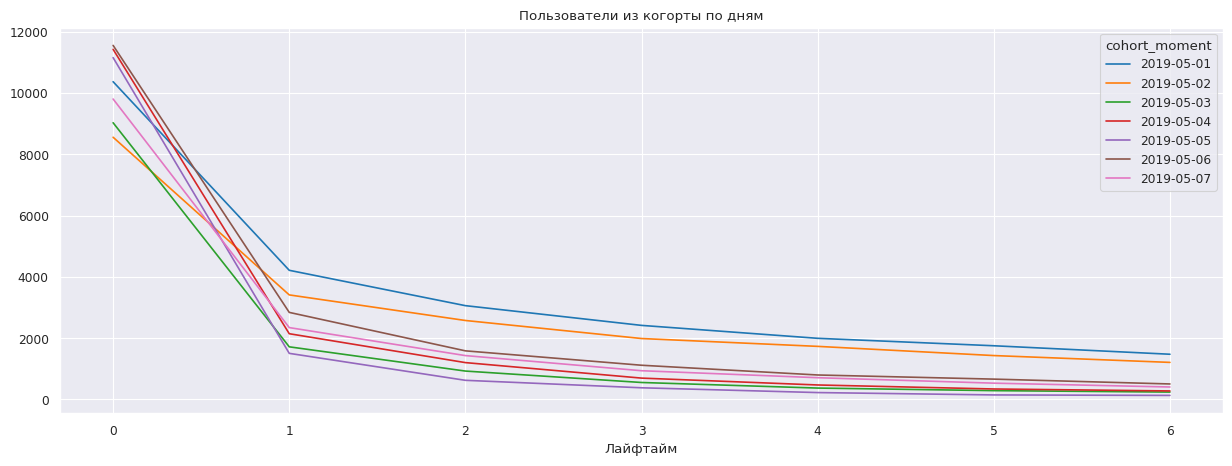

In [15]:
#@title Cohort unique users (first N cohorts)
_, _, _, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON, ignore_horizon=False, dimensions=[])
N=10

cohorts_users_dyn[0:N].drop(columns=['cohort_size']).droplevel('cohort').T.plot(
    grid=True,  # добавляем сетку
    xticks=list(cohorts_users_dyn.columns.values[1:]),
    figsize=(15, 5),  # размер графика
    );
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Пользователи из когорты по дням')  # название графика
plt.show()



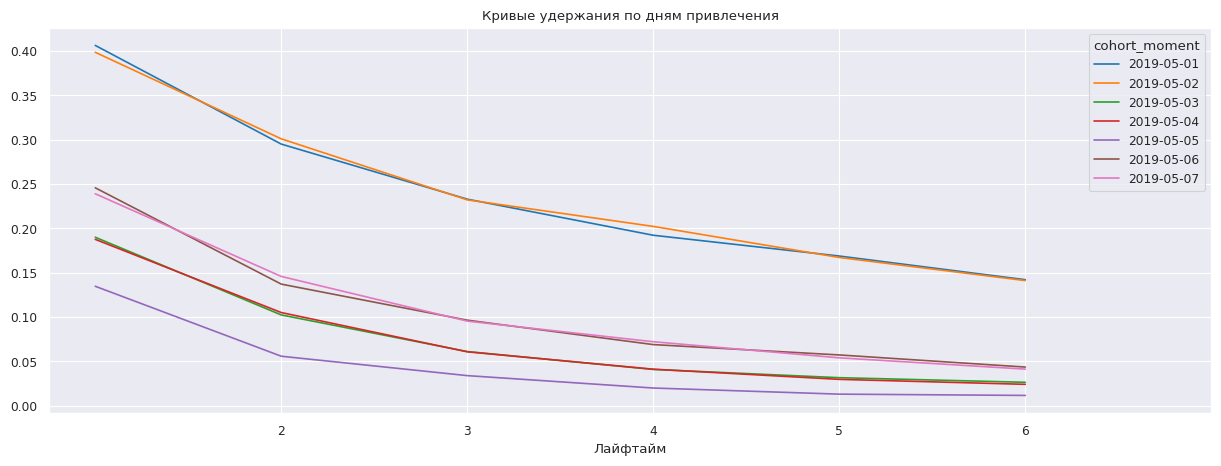

In [16]:
#@title Cohort retention (коэффициент удержания когорт), first N cohorts
cohorts_retention_dyn.drop(columns=['cohort_size', 0, ]).droplevel('cohort')[0:N].T.plot(
    grid=True,  # добавляем сетку
    xticks=list(cohorts_retention_dyn.columns.values[2:]),
    figsize=(15, 5),  # размер графика
);
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.show()



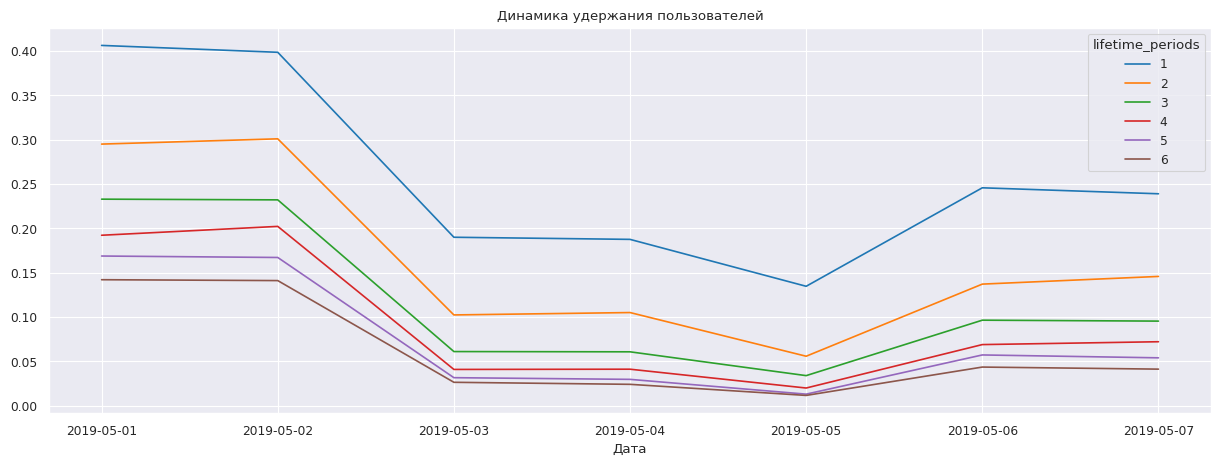

In [17]:
#@title Retention dynamics for n-group cohort (история изменения удержания когорт, в данном случае n -ого дня)
cohorts_retention_dyn.drop(columns=['cohort_size', 0, ]).droplevel('cohort').plot(
    grid=True,  # добавляем сетку
    figsize=(15, 5),  # размер графика
);
plt.xlabel('Дата')  # название оси X
plt.title('Динамика удержания пользователей')  # название графика
plt.show()

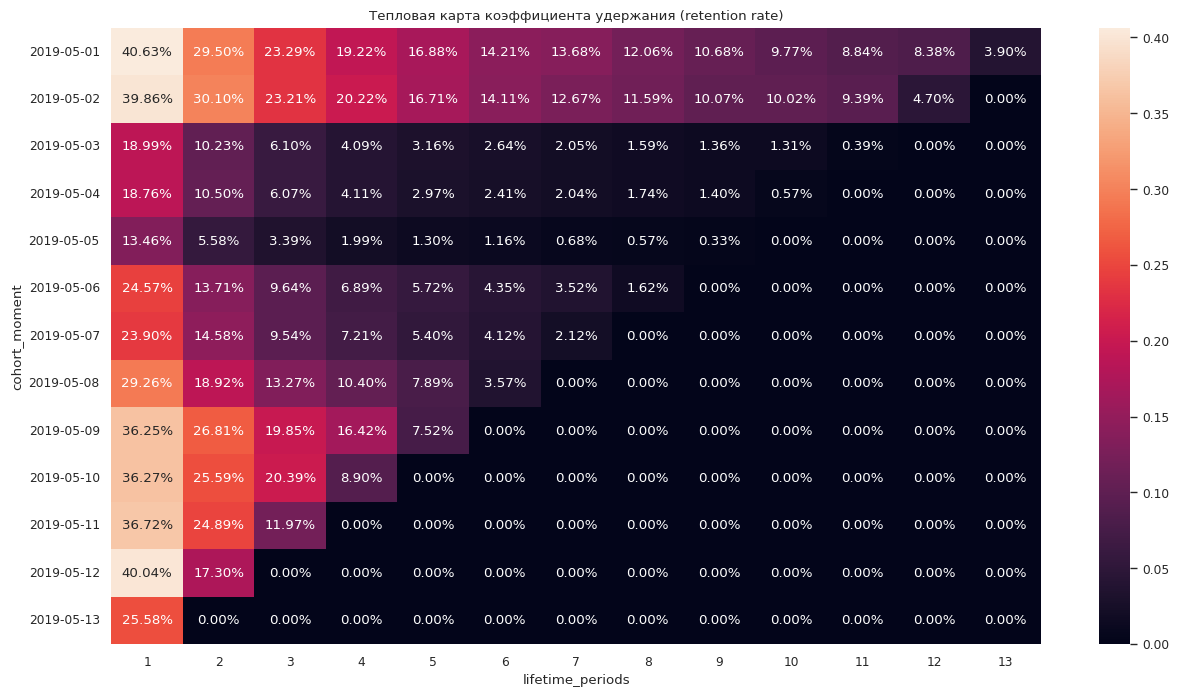

In [18]:
#@title heatmap retention
_, _, _, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=14, ignore_horizon=True, dimensions=[])
plt.figure(figsize=(15, 8))
sns.heatmap(cohorts_retention_dyn.fillna(0).drop(columns=['cohort_size', 0, ]).droplevel('cohort'), annot=True, fmt='.2%')
plt.title('Тепловая карта коэффициента удержания (retention rate)')  # название графика
plt.show()

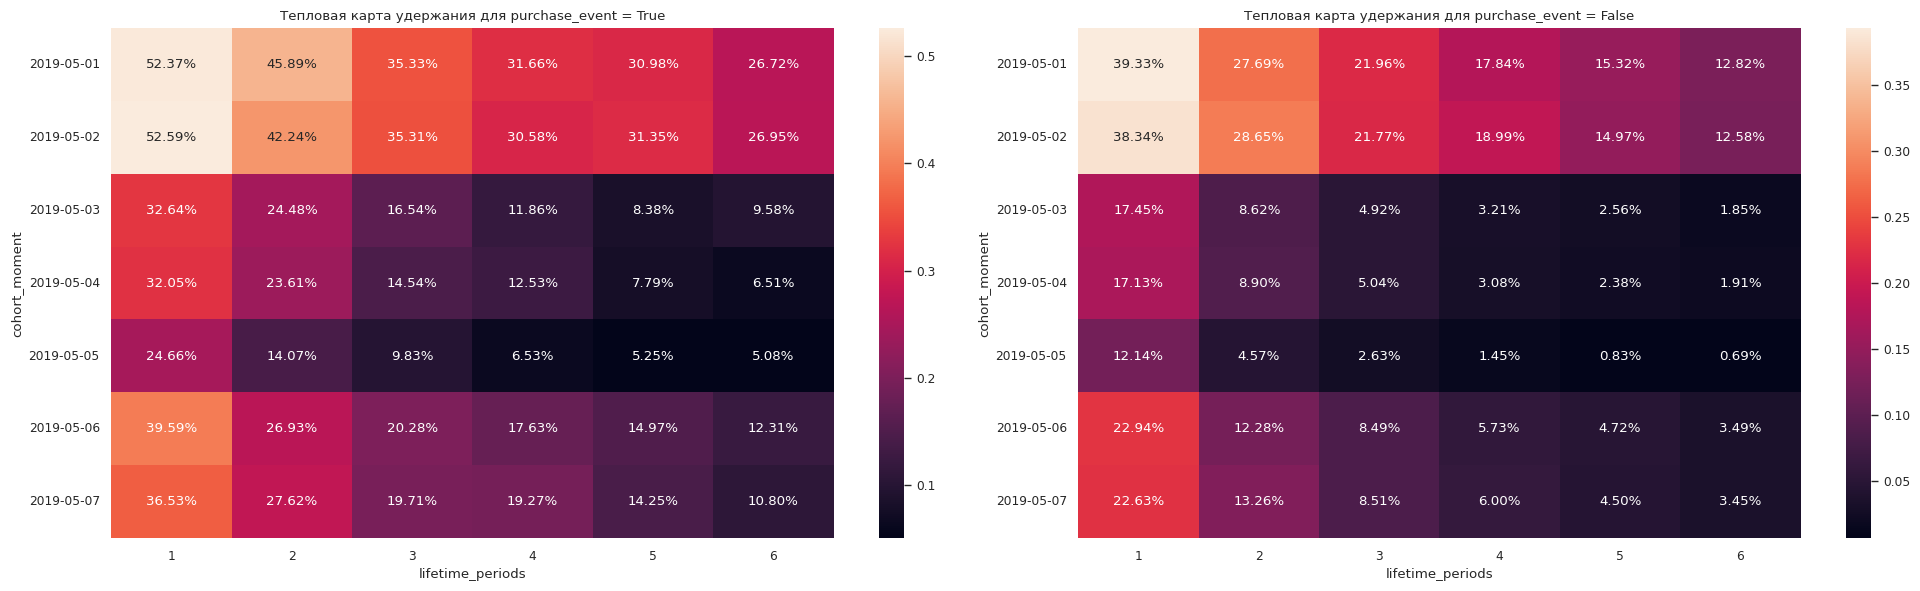

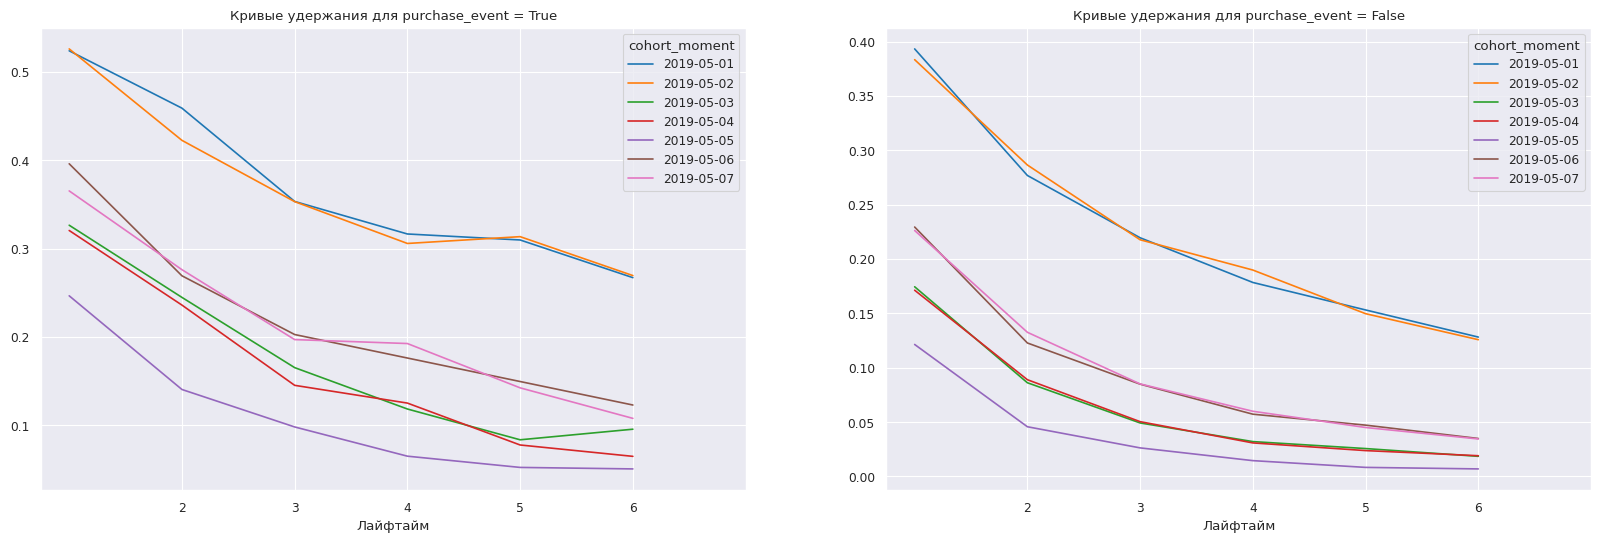

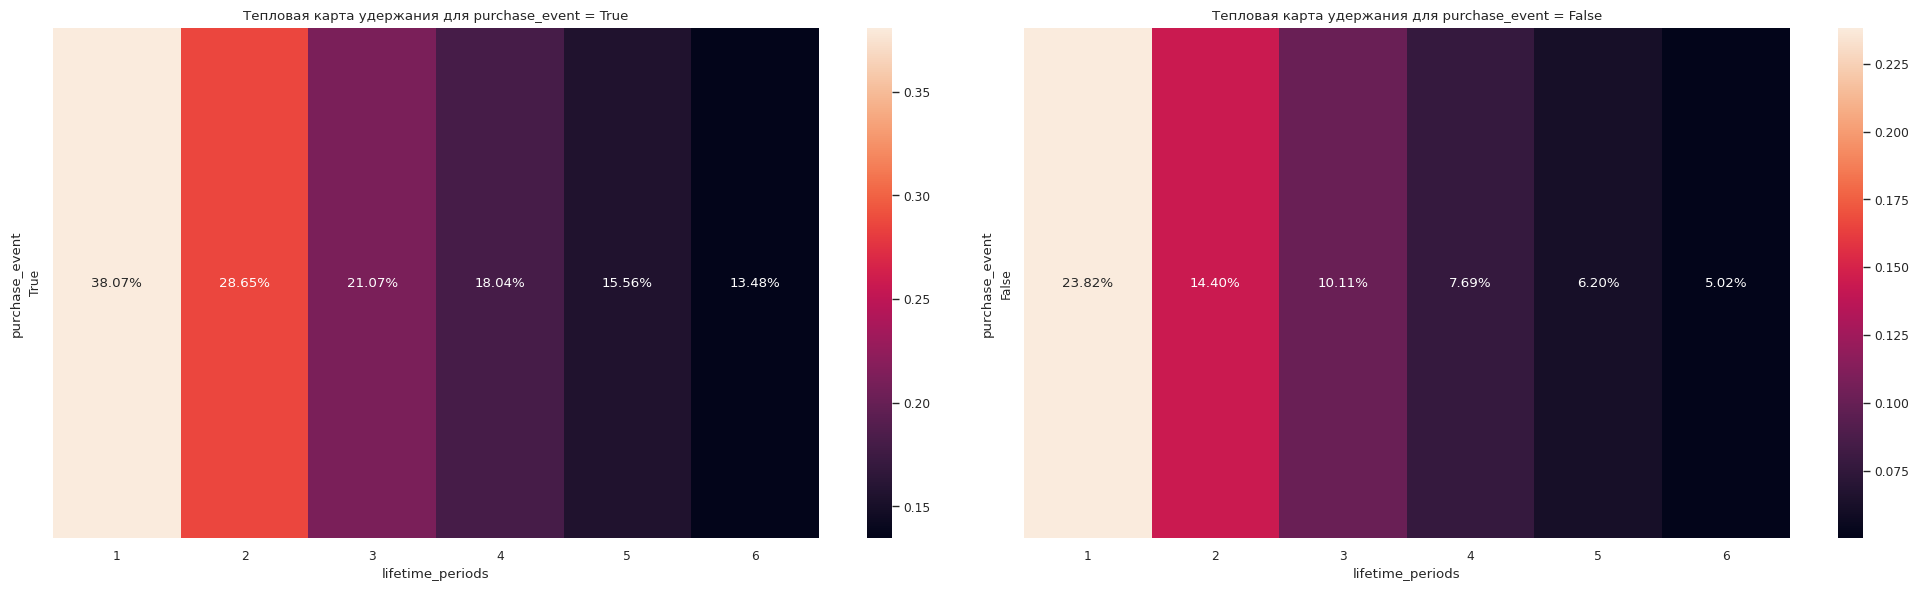

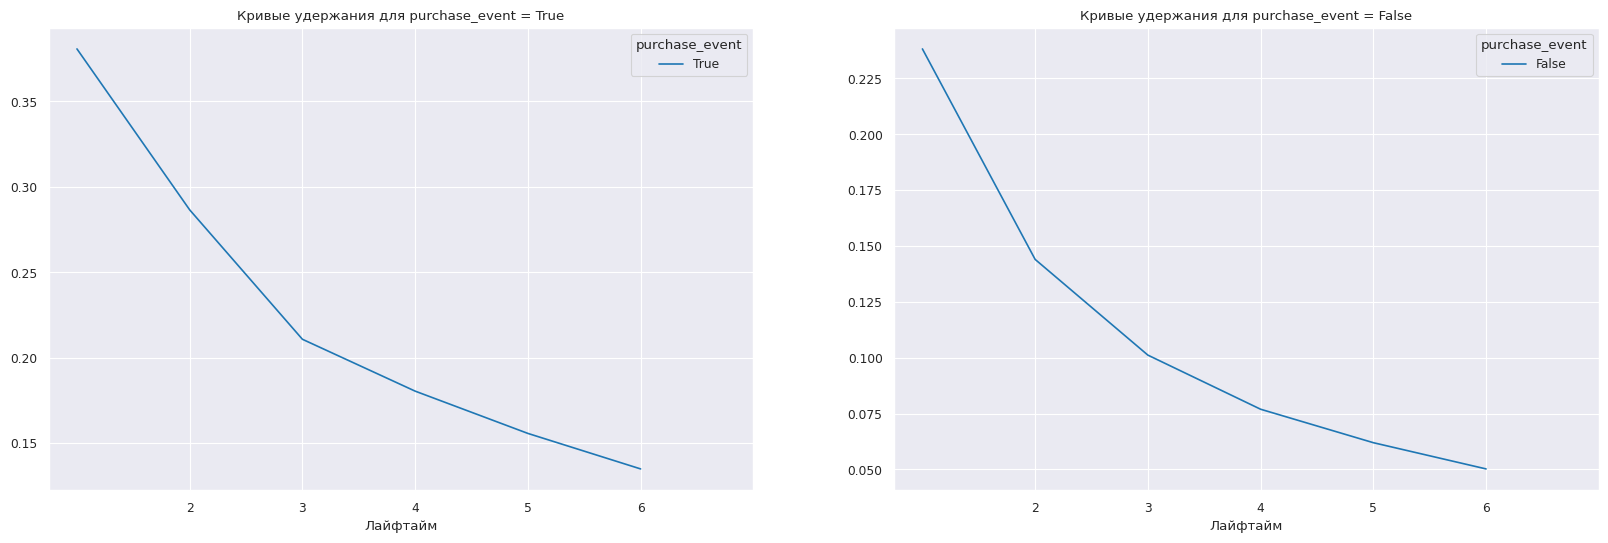

In [19]:
#@title subplots by key_event (sales in general)
_, _, cohorts_retention, _, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON, ignore_horizon=False, dimensions=['purchase_event'])

if 'purchase_event' in cohorts_retention_dyn.index.names:
    plt.figure(figsize=(20, 6)) # задаём размер сетки для графиков
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        sns.heatmap(
            cohorts_retention_dyn.query('purchase_event == @purchase_event')
            .droplevel('purchase_event')
            .drop(columns=['cohort_size', 0]),
            annot=True, fmt='.2%',
            ax=plt.subplot(1, 2, i + 1),
        )
        # задаём названия графиков с учётом значения payer
        plt.title('Тепловая карта удержания для purchase_event = {}'.format(purchase_event))

    plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
    plt.show()


    plt.figure(figsize=(20, 6))  # задаём размер сетки
    # исключаем размеры когорт и удержание первого дня
    report = cohorts_retention_dyn.drop(columns=['cohort_size', 0])
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        report.query('purchase_event == @purchase_event') \
        .droplevel('purchase_event').T.plot(
            grid=True,  # добавляем сетку
            # отметки на оси X — названия колонок
            xticks=list(report.columns.values),
            ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
        )
        plt.xlabel('Лайфтайм')
        plt.title('Кривые удержания для purchase_event = {}'.format(purchase_event))
    plt.show()


if 'purchase_event' in cohorts_retention.index.names:
    plt.figure(figsize=(20, 6)) # задаём размер сетки для графиков
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        sns.heatmap(
            cohorts_retention.query('purchase_event == @purchase_event')
            .drop(columns=['cohort_size', 0]),
            annot=True, fmt='.2%',
            ax=plt.subplot(1, 2, i + 1),
        )
        # задаём названия графиков с учётом значения payer
        plt.title('Тепловая карта удержания для purchase_event = {}'.format(purchase_event))

    plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
    plt.show()


    plt.figure(figsize=(20, 6))  # задаём размер сетки
    # исключаем размеры когорт и удержание первого дня
    report = cohorts_retention.drop(columns=['cohort_size', 0])
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        report.query('purchase_event == @purchase_event').T.plot(
            grid=True,  # добавляем сетку
            # отметки на оси X — названия колонок
            xticks=list(report.columns.values),
            ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
        )
        plt.xlabel('Лайфтайм')
        plt.title('Кривые удержания для purchase_event = {}'.format(purchase_event))
    plt.show()

#Churn

In [20]:
#@title get_churn function
def get_churn(sessions, profiles, observation_date, horizon, ignore_horizon=False, first_cohort_moment=None, dimensions='cohort_moment'):
    """
    sessions - журнал посещений
    profiles - профили пользователей
    observation_date - дата, из которой проводится анализ (обычно это последняя полная дата в журнале посещений)
    horizon - горизонт анализа
    ignore_horizon - игнорировать горизонт? (True - выводим все доступные когорты (треугольная матрица);
                                             False - выводим только когорты [0..hirizon-1])
    first_cohort_moment - если хотим ограничить и не брать в анализ старые когорты
    """
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon - 1)

    # исключаем пользователей, не «доживших» до горизонта анализа
    profiles_filtered = profiles[profiles.cohort_moment<=last_suitable_acquisition_date]

    if first_cohort_moment is not None:
        profiles_filtered = profiles_filtered[profiles_filtered.cohort_moment>=first_cohort_moment]

    retention_raw = join_sessions_with_profiles(sessions, profiles_filtered)

    def group_by_dimensions(df, dims, horizon, ignore_horizon):
        if len(dims) == 0:
            df['cohort'] = "All users"
            dims = ['cohort']
        if dims == ['cohort_moment']:
            df['cohort'] = "All users"
            dims = ['cohort', 'cohort_moment', ]

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        df_filtered = df[df.lifetime_periods<horizon]

        cohorts_users = df_filtered.pivot_table(index=dims, columns='lifetime_periods', values='user_id', aggfunc='nunique')
        cohorts_users = cohorts_users.fillna(0)
        cohorts_churn = cohorts_users.apply(
            lambda x: pd.Series([np.nan] + [1-x.iloc[i]/x.iloc[i-1] if x.iloc[i-1]>0 else np.nan for i in range(1, len(x))], index=x.index),
            axis=1
        )
        cohorts_churn['cohort_size'] = cohort_sizes

        cohorts_churn = cohorts_churn[['cohort_size', ] + list(i for i in range(horizon if not ignore_horizon else len(cohorts_users.columns)) if i in cohorts_users.columns)]
        cohorts_users['cohort_size'] = cohort_sizes
        cohorts_users = cohorts_users[['cohort_size', ] + list(i for i in range(horizon if not ignore_horizon else len(cohorts_users.columns)-1) if i in cohorts_users.columns)]
        return cohorts_users, cohorts_churn

    # агрегация без динамики ==
    cohorts_users, cohorts_churn = group_by_dimensions(retention_raw, dimensions, horizon, ignore_horizon)

    # агрегация с динамикой ==
    cohorts_users_in_time, cohorts_churn_in_time = group_by_dimensions(retention_raw, dimensions+['cohort_moment'], horizon, ignore_horizon)
    return retention_raw, cohorts_users, cohorts_churn, cohorts_users_in_time, cohorts_churn_in_time


raw_data, cohorts_users, cohorts_churn, cohorts_users_dyn, cohorts_churn_dyn = get_churn(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON,
                                                               ignore_horizon=False,
                                                               #first_cohort_moment=(sessions.session_start.min()+timedelta(85)).date(),
                                                               dimensions=['first_device'])

print("Lines in raw_data:", len(raw_data))
print("Dates in raw data:",raw_data.cohort_moment.min(), raw_data.cohort_moment.max())
#display_df(cohorts_users_dyn)
display_df(cohorts_churn_dyn)



Lines in raw_data: 153832
Dates in raw data: 2019-05-01 2019-05-07


lifetime_periods            cohort_size   0         1         2         3  \
first_device cohort_moment                                                  
Android      2019-05-01            2093 NaN  0.599140  0.263409  0.208738   
             2019-05-02            1700 NaN  0.588824  0.268956  0.232877   
             2019-05-03            1812 NaN  0.799117  0.464286  0.446154   
             2019-05-04            2264 NaN  0.811837  0.453052  0.407725   
             2019-05-05            2266 NaN  0.858341  0.598131  0.317829   
             2019-05-06            2258 NaN  0.752879  0.448029  0.256494   
             2019-05-07            1923 NaN  0.755070  0.422505  0.308824   
Mac          2019-05-01            2596 NaN  0.580123  0.260550  0.285360   
             2019-05-02            2163 NaN  0.622746  0.196078  0.230183   
             2019-05-03            2229 NaN  0.826828  0.373057  0.380165   
             2019-05-04            2793 NaN  0.813104  0.454023  0.431579   
             2019-05-05            2754 NaN  0.873275  0.564470  0.401316   
             2019-05-06            2902 NaN  0.752240  0.406120  0.313817   
             2019-05-07            2528 NaN  0.759889  0.441516  0.283186   
PC           2019-05-01            1076 NaN  0.594796  0.256881  0.194444   
             2019-05-02             895 NaN  0.622346  0.174556  0.250896   
             2019-05-03             957 NaN  0.801463  0.542105  0.517241   
             2019-05-04            1229 NaN  0.834825  0.389163  0.370968   
             2019-05-05            1140 NaN  0.852632  0.672619  0.272727   
             2019-05-06            1160 NaN  0.752586  0.498258  0.263889   
             2019-05-07            1039 NaN  0.761309  0.379032  0.350649   
iPhone       2019-05-01            4604 NaN  0.598610  0.290584  0.169336   
             2019-05-02            3798 NaN  0.590047  0.274888  0.220549   
             2019-05-03            4031 NaN  0.807740  0.483871  0.372500   
             2019-05-04            5140 NaN  0.807004  0.437500  0.433692   
             2019-05-05            4995 NaN  0.867067  0.569277  0.444056   
             2019-05-06            5234 NaN  0.756400  0.447059  0.310638   
             2019-05-07            4314 NaN  0.764256  0.347099  0.391566   

lifetime_periods                   4         5         6  
first_device cohort_moment                                
Android      2019-05-01     0.210634  0.093264  0.174286  
             2019-05-02     0.165816  0.131498  0.151408  
             2019-05-03     0.268519  0.291139  0.142857  
             2019-05-04     0.318841  0.308511  0.153846  
             2019-05-05     0.488636  0.377778 -0.250000  
             2019-05-06     0.301310  0.200000  0.218750  
             2019-05-07     0.228723  0.296552  0.186275  
Mac          2019-05-01     0.137153  0.130785  0.099537  
             2019-05-02     0.106931  0.181818  0.181572  
             2019-05-03     0.433333  0.247059  0.203125  
             2019-05-04     0.351852  0.266667  0.090909  
             2019-05-05     0.461538  0.142857  0.333333  
             2019-05-06     0.337884  0.185567  0.158228  
             2019-05-07     0.296296  0.274854  0.193548  
PC           2019-05-01     0.203065  0.134615  0.088889  
             2019-05-02     0.157895  0.107955  0.203822  
             2019-05-03     0.166667  0.200000 -0.178571  
             2019-05-04     0.217949  0.442623 -0.029412  
             2019-05-05     0.275000  0.620690  0.090909  
             2019-05-06     0.179245  0.183908  0.183099  
             2019-05-07     0.180000  0.219512  0.296875  
iPhone       2019-05-01     0.171717  0.126386  0.199239  
             2019-05-02     0.118182  0.201031  0.130645  
             2019-05-03     0.322709  0.194118  0.226277  
             2019-05-04     0.335443  0.223810  0.294479  
             2019-05-05     0.377358  0.353535  0.125000  
             2019-05-06     0.269547 

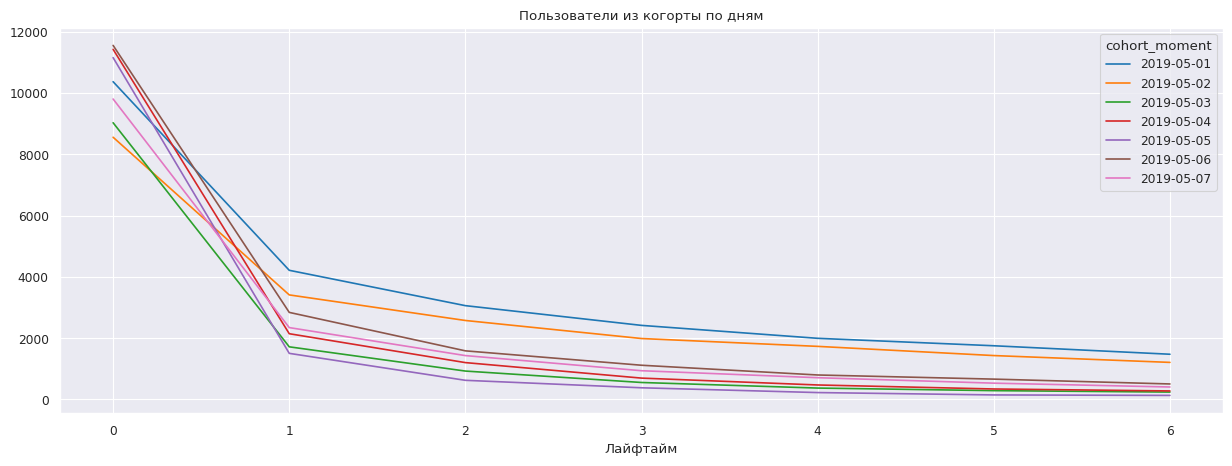

In [21]:
#@title Cohort unique users (first N cohorts)
_, _, _, cohorts_users_dyn, cohorts_churn_dyn = get_churn(sessions, profiles,
                                                          observation_date=_OBSERVATION_DATE,
                                                          horizon=_HORIZON, ignore_horizon=False, dimensions=[])
N=10
cohorts_users_dyn.drop(columns=['cohort_size']).droplevel('cohort')[0:N].T.plot(
    grid=True,  # добавляем сетку
    xticks=list(cohorts_users_dyn.columns.values[1:]),
    figsize=(15, 5),  # размер графика
    );
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Пользователи из когорты по дням')  # название графика
plt.show()

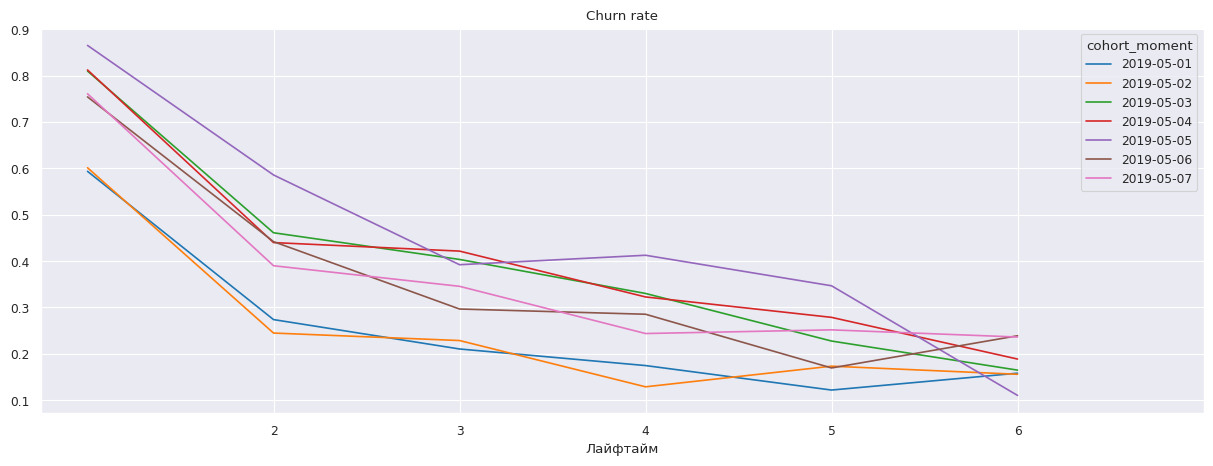

In [22]:
#@title Churn rate, first N cohorts
cohorts_churn_dyn.drop(columns=['cohort_size', 0, ]).droplevel('cohort')[0:N].T.plot(
    grid=True,  # добавляем сетку
    xticks=list(cohorts_churn_dyn.columns.values[2:]),
    figsize=(15, 5),  # размер графика
);
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Churn rate')  # название графика
plt.show()


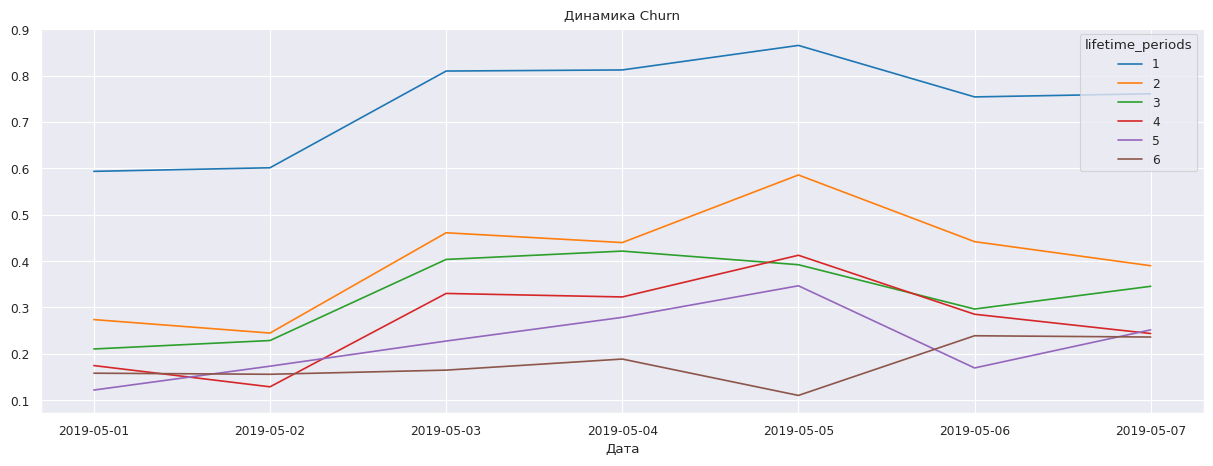

In [23]:
#@title Churn dynamics for n-group cohort
cohorts_churn_dyn.drop(columns=['cohort_size', 0, ]).droplevel('cohort').plot(
    grid=True,  # добавляем сетку
    #xticks=list(cohorts_retention.columns.values),
    figsize=(15, 5),  # размер графика
);
plt.xlabel('Дата')  # название оси X
plt.title('Динамика Churn')  # название графика
plt.show()

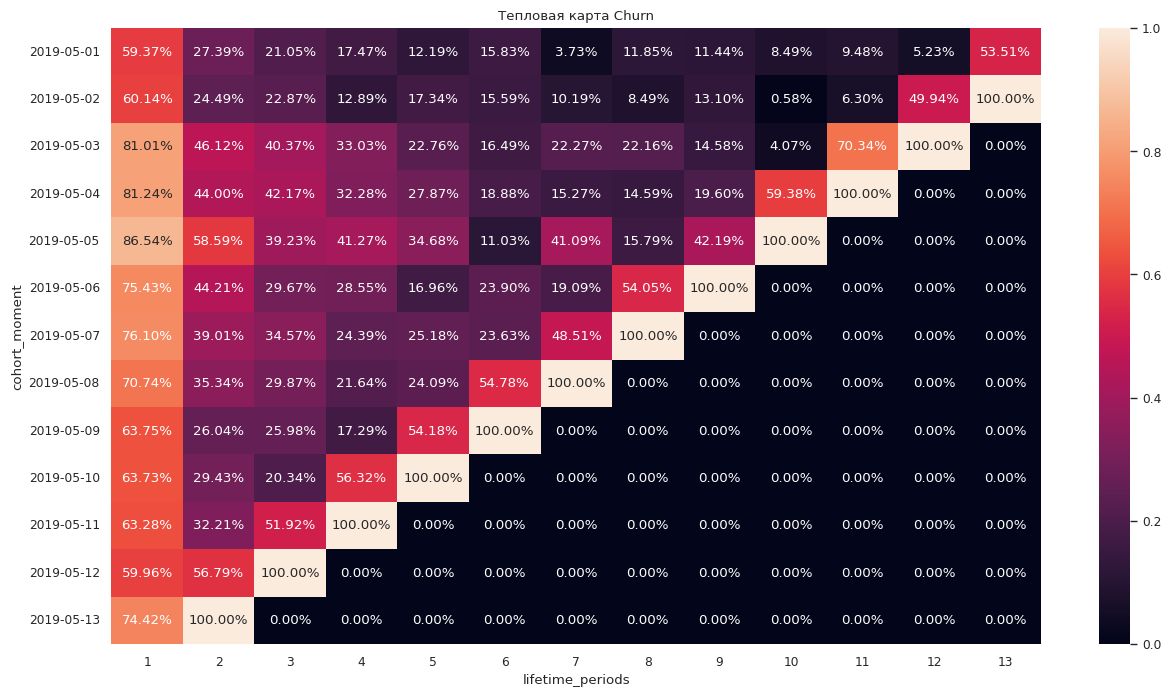

In [24]:
#@title heatmap churn
_, _, _, cohorts_users_dyn, cohorts_churn_dyn = get_churn(sessions, profiles,
                                                          observation_date=_OBSERVATION_DATE,
                                                          horizon=14, ignore_horizon=True, dimensions=[])
plt.figure(figsize=(15, 8))
sns.heatmap(cohorts_churn_dyn.fillna(0).drop(columns=['cohort_size', 0, ]).droplevel('cohort'), annot=True, fmt='.2%')
plt.title('Тепловая карта Churn')  # название графика
plt.show()

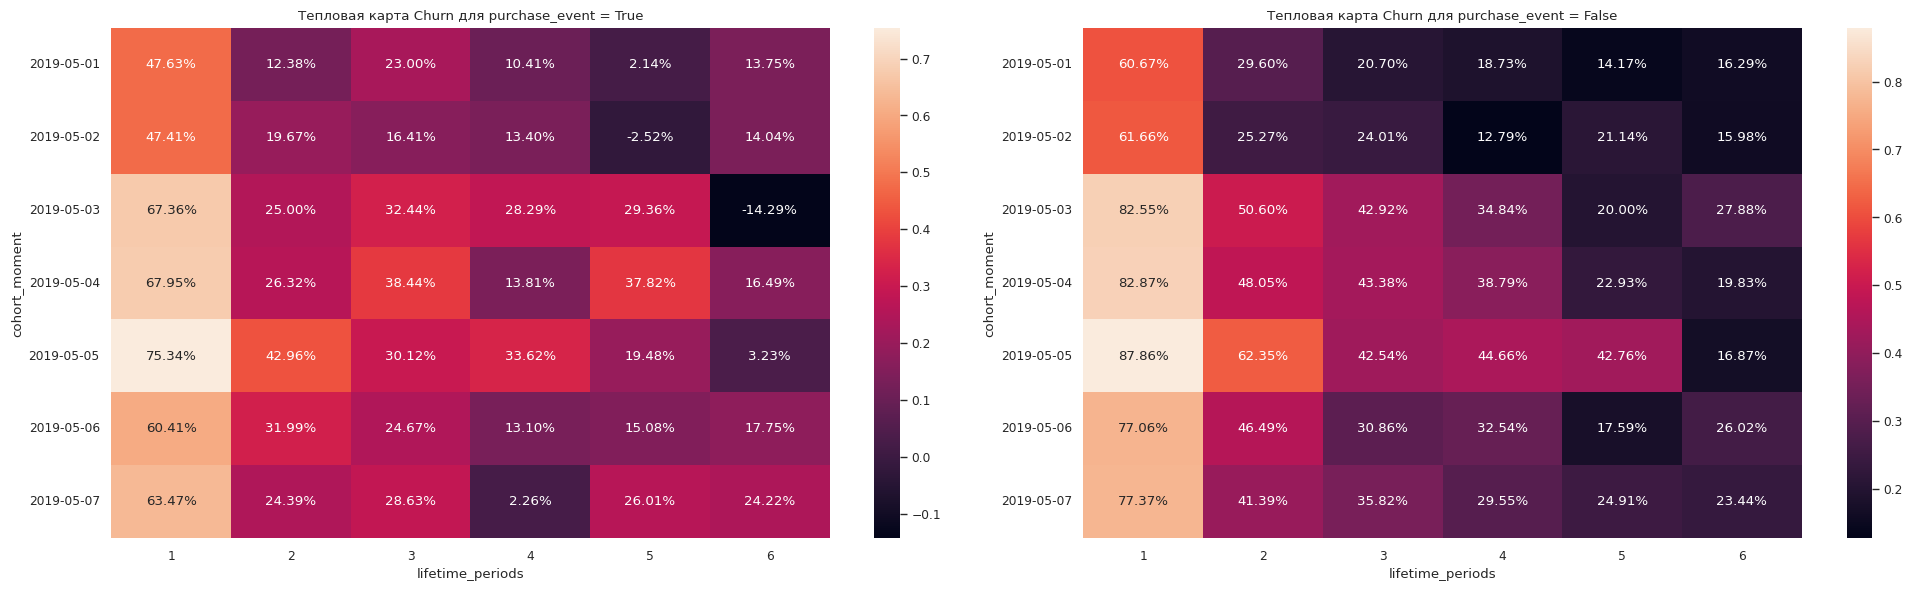

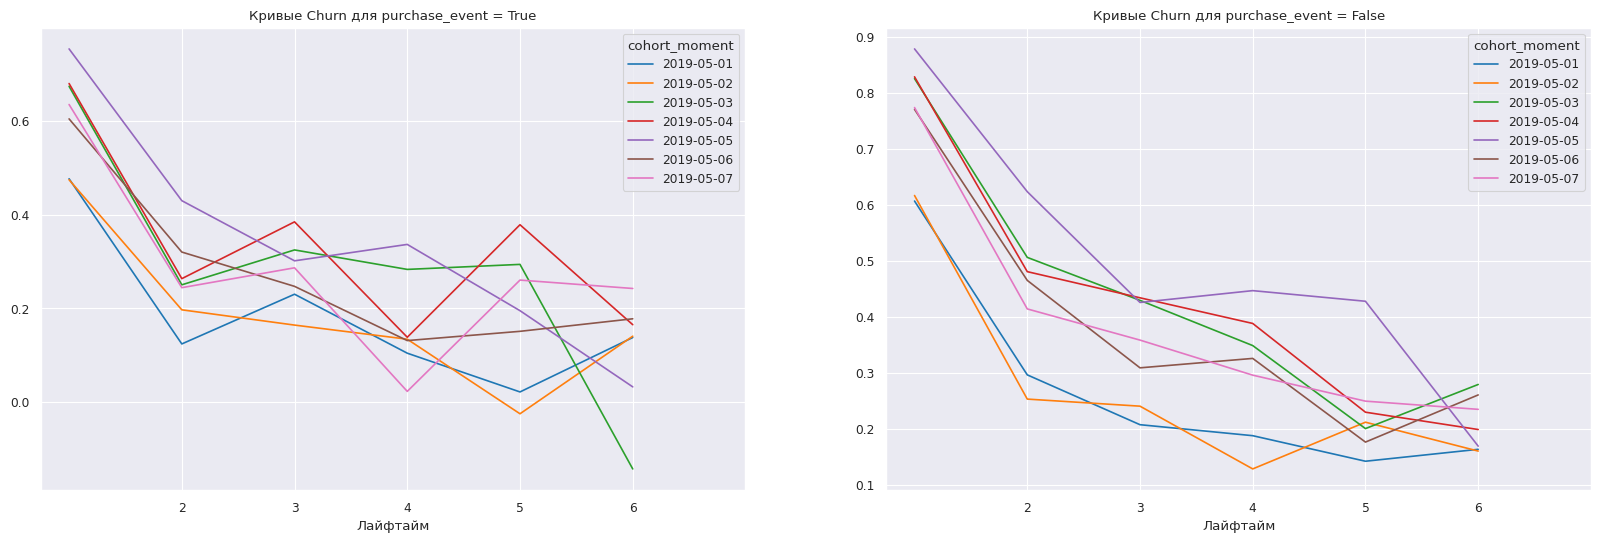

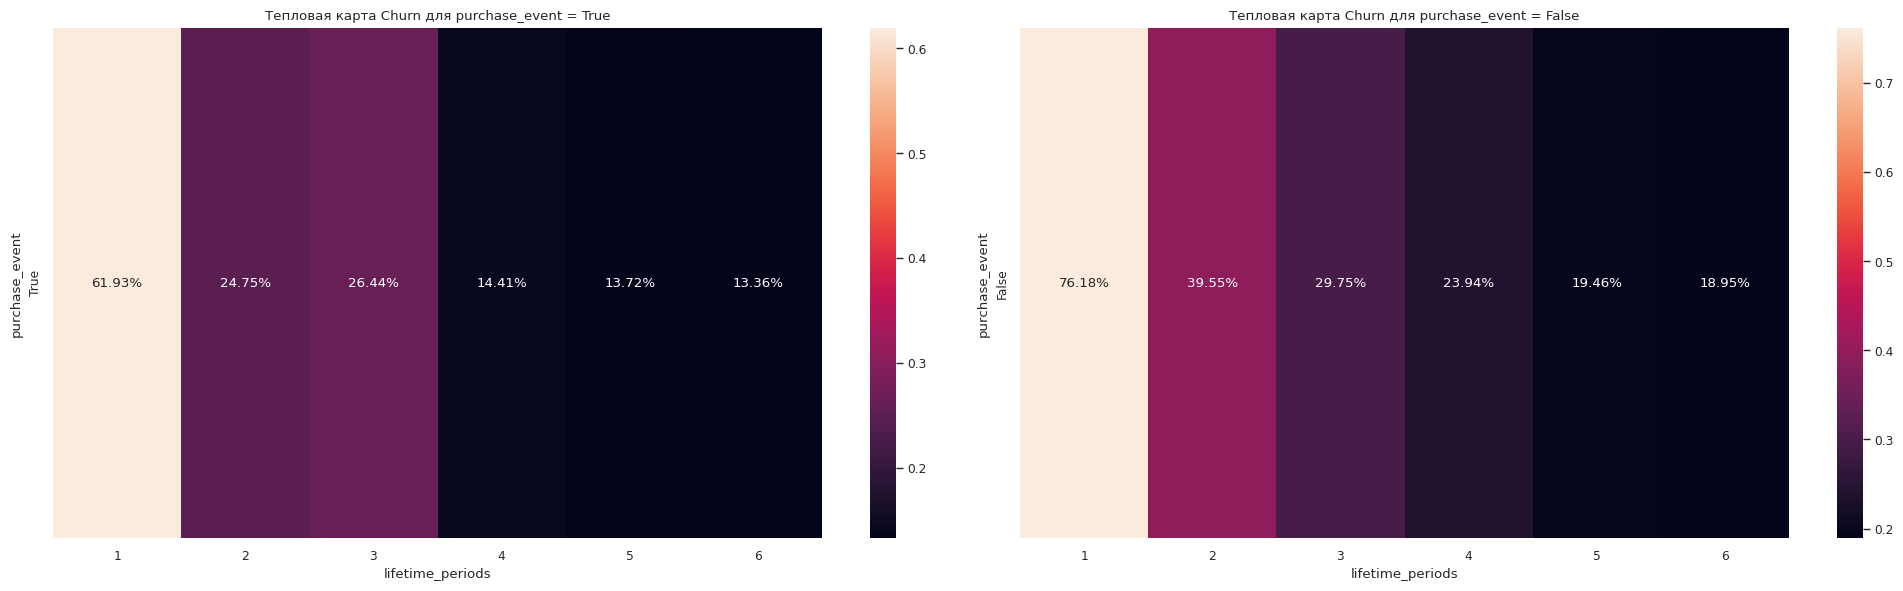

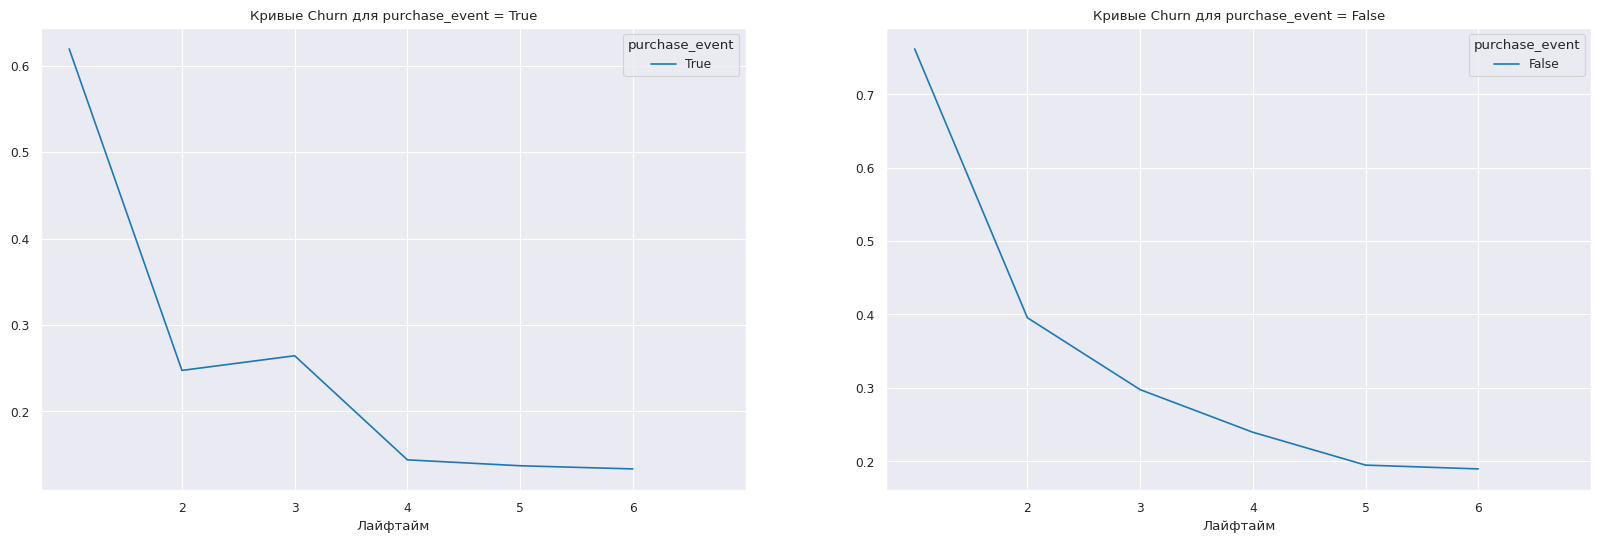

In [25]:
#@title subplots by purchase_event (sales in general)
_, _, cohorts_churn, _, cohorts_churn_dyn = get_churn(sessions, profiles,
                                                          observation_date=_OBSERVATION_DATE,
                                                          horizon=_HORIZON, ignore_horizon=False, dimensions=['purchase_event'])
if 'purchase_event' in cohorts_churn_dyn.index.names:
    plt.figure(figsize=(20, 6)) # задаём размер сетки для графиков
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        sns.heatmap(
            cohorts_churn_dyn.query('purchase_event == @purchase_event')
            .droplevel('purchase_event')
            .drop(columns=['cohort_size', 0]),
            annot=True, fmt='.2%',
            ax=plt.subplot(1, 2, i + 1),
        )
        # задаём названия графиков с учётом значения payer
        plt.title('Тепловая карта Churn для purchase_event = {}'.format(purchase_event))

    plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
    plt.show()


    plt.figure(figsize=(20, 6))  # задаём размер сетки
    # исключаем размеры когорт и удержание первого дня
    report = cohorts_churn_dyn.drop(columns=['cohort_size', 0])
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        report.query('purchase_event == @purchase_event').droplevel('purchase_event').T.plot(
            grid=True,  # добавляем сетку
            # отметки на оси X — названия колонок
            xticks=list(report.columns.values),
            ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
        )
        plt.xlabel('Лайфтайм')
        plt.title('Кривые Churn для purchase_event = {}'.format(purchase_event))
    plt.show()

if 'purchase_event' in cohorts_churn.index.names:
    plt.figure(figsize=(20, 6)) # задаём размер сетки для графиков
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        sns.heatmap(
            cohorts_churn.query('purchase_event == @purchase_event')
            .drop(columns=['cohort_size', 0]),
            annot=True, fmt='.2%',
            ax=plt.subplot(1, 2, i + 1),
        )
        # задаём названия графиков с учётом значения payer
        plt.title('Тепловая карта Churn для purchase_event = {}'.format(purchase_event))

    plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
    plt.show()


    plt.figure(figsize=(20, 6))  # задаём размер сетки
    # исключаем размеры когорт и удержание первого дня
    report = cohorts_churn.drop(columns=['cohort_size', 0])
    for i, purchase_event in enumerate(profiles['purchase_event'].unique()):
        report.query('purchase_event == @purchase_event').T.plot(
            grid=True,  # добавляем сетку
            # отметки на оси X — названия колонок
            xticks=list(report.columns.values),
            ax=plt.subplot(1, 2, i + 1), # задаём расположение графиков
        )
        plt.xlabel('Лайфтайм')
        plt.title('Кривые Churn для purchase_event = {}'.format(purchase_event))
    plt.show()

#Analysis dynamics for n-group cohort (with additional dimentions)

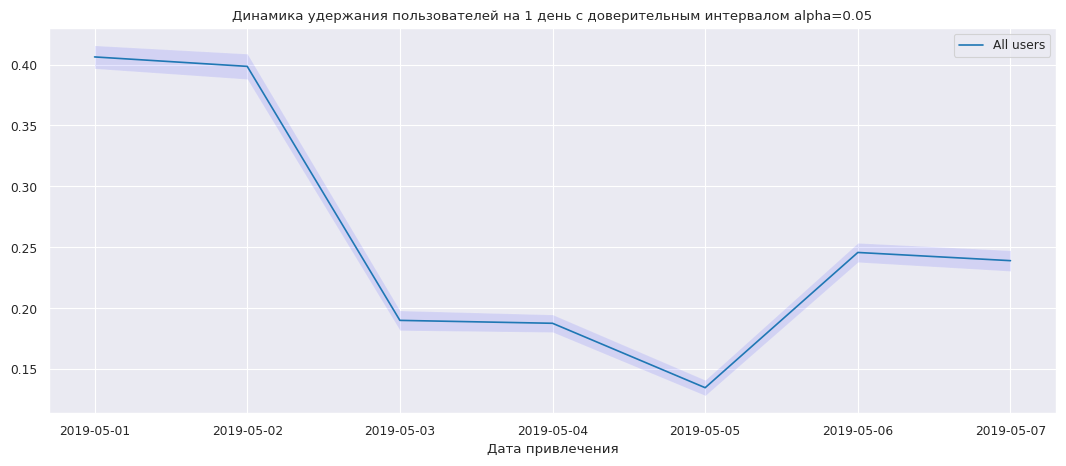

lifetime_periods         cohort_size     1  retention        se      left  \
cohort    cohort_moment                                                     
All users 2019-05-01           10369  4213   0.406307  0.004823  0.396854   
          2019-05-02            8556  3410   0.398551  0.005293  0.388177   
          2019-05-03            9029  1715   0.189944  0.004128  0.181853   
          2019-05-04           11426  2143   0.187555  0.003652  0.180397   
          2019-05-05           11155  1502   0.134648  0.003232  0.128314   
          2019-05-06           11554  2839   0.245716  0.004005  0.237866   
          2019-05-07            9804  2343   0.238984  0.004307  0.230542   

lifetime_periods            right  
cohort    cohort_moment            
All users 2019-05-01     0.415761  
          2019-05-02     0.408925  
          2019-05-03     0.198034  
          2019-05-04     0.194712  
          2019-05-05     0.140983  
          2019-05-06     0.253566  
          2019-05-07     0.247426

In [26]:
#@title Retention dynsmics with confidence interval
_, cohorts_users, cohorts_retention, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON, ignore_horizon=False,
                                                               dimensions=[]
                                                         )


def plot_retention_dynamics_intervals(dyn, lifetime_period=None, alpha=0.05, ):
    if lifetime_period is None:
        lifetime_period = _HORIZON - 1

    data = dyn[['cohort_size', lifetime_period]].copy()
    data['retention'] = data[lifetime_period]/data['cohort_size']

    # стандартная ошибка
    data['se'] = np.sqrt(data['retention'] * (1 - data['retention']) / data['cohort_size'])

    # границы интервалов
    q = stats.norm.ppf(1 - alpha/2)
    data['left'] = data['retention'] - q * data['se']
    data['right'] = data['retention'] + q * data['se']

    plt.figure(figsize=(13,5))
    for i in dyn.reset_index().iloc[:, 0].unique():
        plt.plot(data.loc[i]['retention'], label=f"{i}")
        plt.fill_between(data.loc[i].index, data.loc[i]['left'], data.loc[i]['right'], facecolor='blue', alpha=0.1, interpolate=True)
    plt.legend()
    plt.title(f"Динамика удержания пользователей на {lifetime_period} день с доверительным интервалом alpha={alpha}")
    plt.xlabel("Дата привлечения")
    plt.show()
    return data

plot_retention_dynamics_intervals(cohorts_users_dyn, lifetime_period=1)

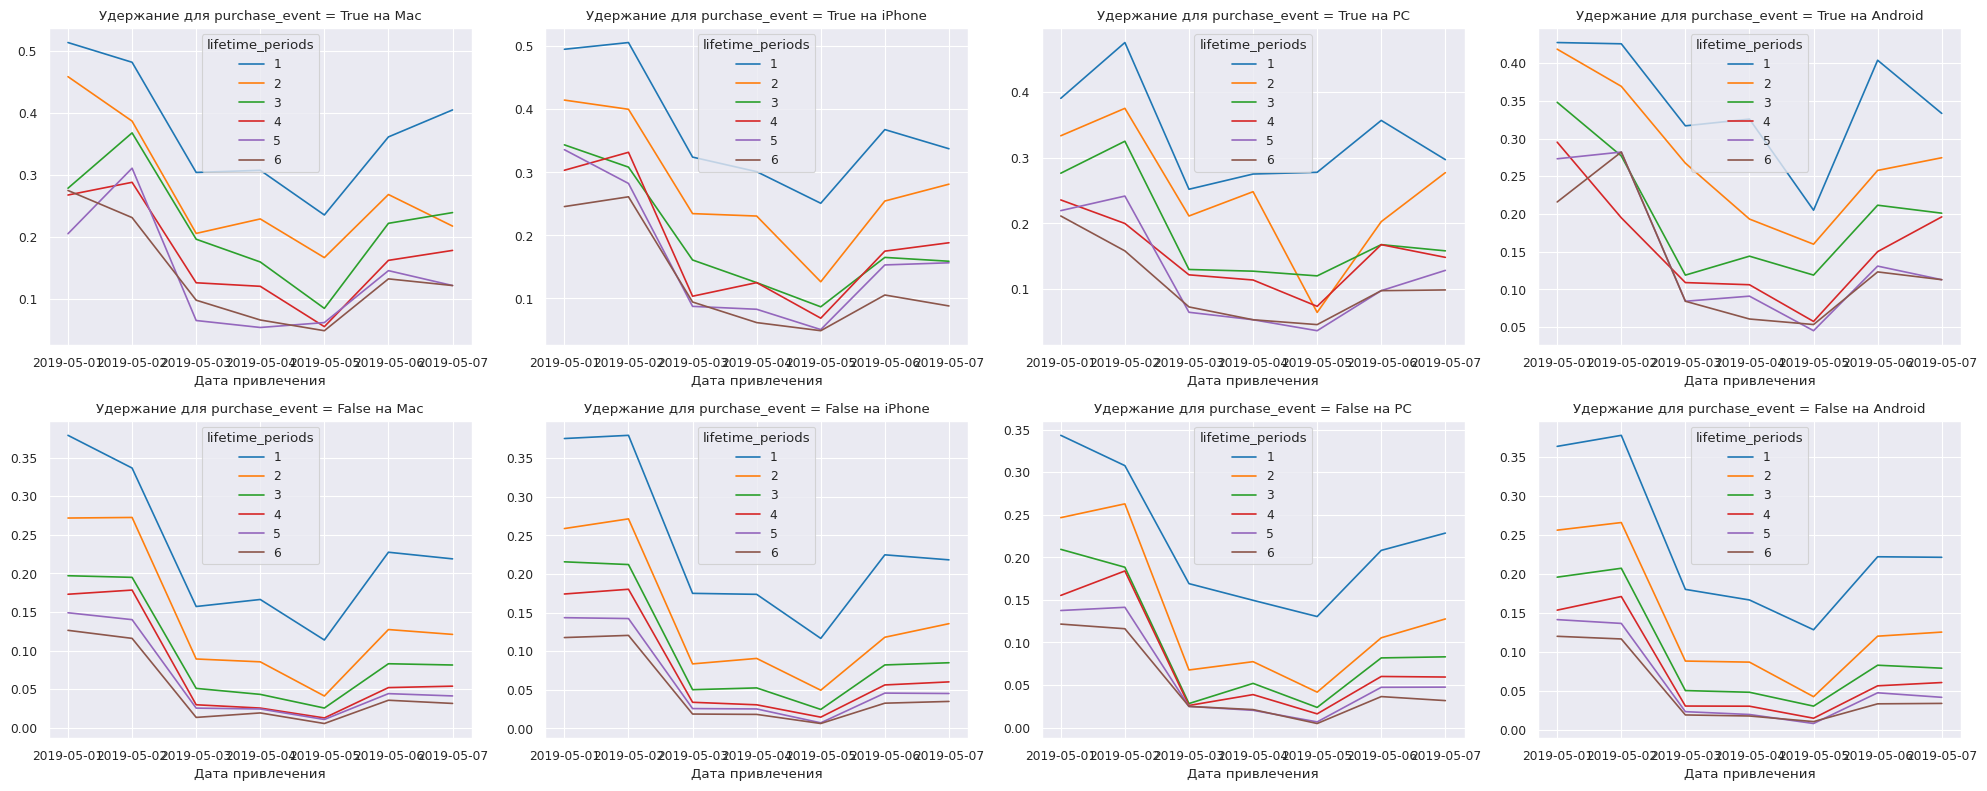

In [27]:
#@title Retention dynamics by device dimension
_, cohorts_users, cohorts_retention, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON, ignore_horizon=False,
                                                               dimensions=['purchase_event', 'device']
                                                              )

# исключаем размеры когорт и удержание первого дня
report = cohorts_retention_dyn.drop(columns=['cohort_size', 0])

num_rows = len(profiles['purchase_event'].unique())
num_cols = len(profiles['first_device'].unique())

plt.figure(figsize=(20, 8))  # задаём размер сетки

for i, payer in enumerate(profiles['purchase_event'].unique()):
    for j, device in enumerate(profiles['first_device'].unique()):
        (
            report.query('purchase_event == @payer and device == @device')
            # устраняем purchase_event и device из индексов,
            # чтобы не загромождать графики
            .droplevel(['purchase_event', 'device'])
            # строим каждый график в своей ячейке
            .plot(
                grid=True,
                # в таблице графиков две строки и четыре столбца
                # i принимает значение 0 или 1, в зависимости от покупки
                # j — 0, 1, 2 или 3, в зависимости от устройства
                # график для неплатящих пользователей Mac окажется
                # в пятой ячейке: 1 * 4 + 0 + 1 = 5
                # а для платящих пользователей Android —
                # в четвёртой: 0 * 4 + 3 + 1 = 4
                ax=plt.subplot(num_rows, num_cols, i * num_cols + j + 1),
            )
        )
        # подпись оси X
        plt.xlabel('Дата привлечения')
        # названия графиков
        plt.title('Удержание для purchase_event = {} на {}'.format(payer, device))

plt.tight_layout()
plt.show()

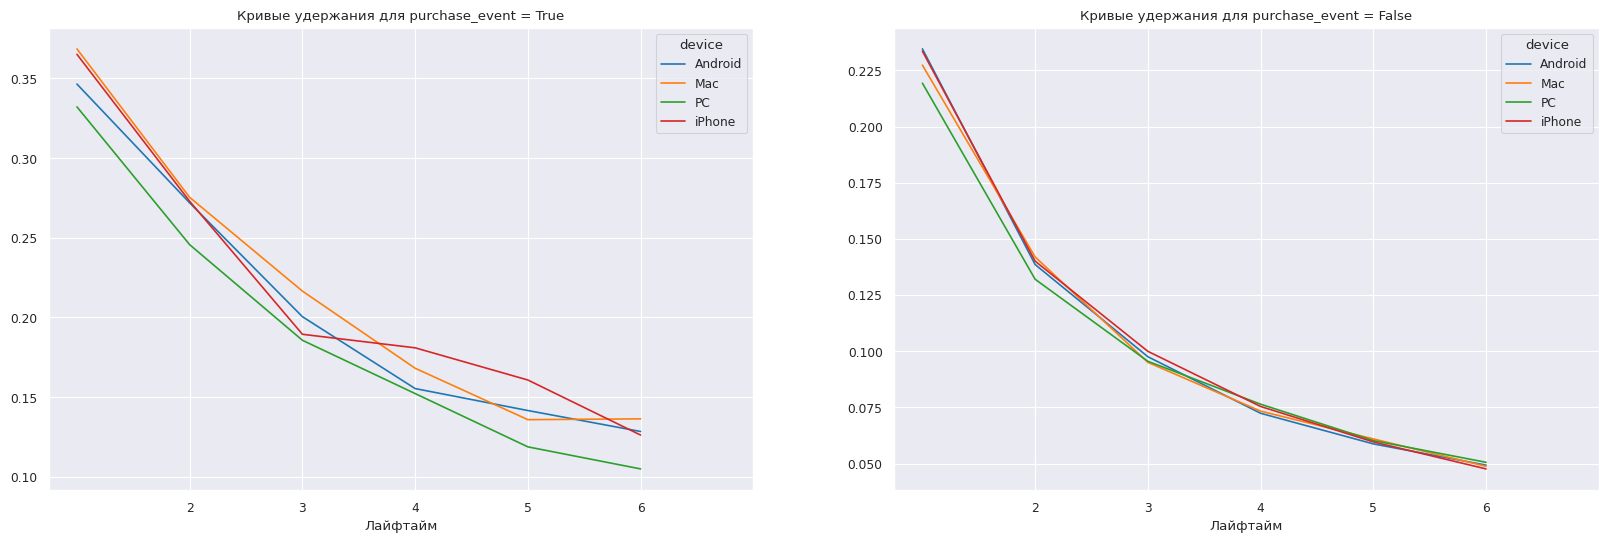

In [28]:
#@title Cohort retention by device dimension
# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = cohorts_retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['purchase_event'].unique()):
    report.query('purchase_event == @payer').droplevel('purchase_event').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для purchase_event = {}'.format(payer))

plt.show()

#Conversions

In [29]:
#@title join_purchase_with_profiles function
def join_purchase_with_profiles(purchase, profiles, mode="conversion_only"):
    """
    склеиваем журнал покупок с профилями пользователей
    и вычисляем для каждой записи журнала lifetime (в нужном интервале, минуты, дни, месяца)
    добавляет поле-классификатор периодов lifetime
    mode = ['conversion_only', 'LTV']

    возвращает отсортированную таблицу по user_id и session_start
    """
    if "first_purchase" not in profiles.columns:
        # определяем дату и время первой покупки для каждого пользователя
        first_purchases = (
            purchase.sort_values(by=['user_id', 'event_dt'])
            .groupby('user_id')
            .agg({'event_dt': 'first',
                  #'revenue': 'first'
                  })
            .rename(columns={'event_dt': 'first_purchase'
                             #'revenue': 'first_revenue',
                             })
            .reset_index()
        )

        #Добавить данные о покупках в профили
        result = profiles.merge(first_purchases, on='user_id', how='left') \
            .sort_values(by=['user_id', 'first_purchase'], ascending=[True, True]) \
            .reset_index(drop=True)
    else:
        result = profiles.copy()

    if mode == 'LTV':
        # при расчете LTV важны все покупки
        result = result.merge(purchase, on='user_id', how='left') \
            .sort_values(by=['user_id', 'event_dt'], ascending=[True, True]) \
            .reset_index(drop=True)
        result['purchase_event'] = result.purchase_event.fillna(False)

        result['lifetime_periods'] = (result['event_dt'] - result['first_ts']).dt.days

    elif mode == 'conversion_only':
        # при расчете конверсии только уникальные (первые) покупки
        result['lifetime_periods'] = (result['first_purchase'] - result['first_ts']).dt.days

    def lt_grp(periods):
        if periods<=1:
            return "купили в 1 день"
        elif periods<=7:
            return "купили в 1 неделю"
        return "купили позже 1 недели"

    result['lifetime_group'] = result.lifetime_periods.map(lt_grp)
    result.loc[~result.purchase_event, 'lifetime_group'] = "не купили"
    return result

join_purchase_with_profiles(orders, profiles)

user_id            first_ts  first_channel first_device  \
0           10964006 2019-05-12 04:50:17         Yandex          Mac   
1           12358165 2019-05-10 23:16:24         Yandex       iPhone   
2           12545358 2019-05-05 19:22:46        Organic          Mac   
3           16165560 2019-05-10 20:29:59         Yandex           PC   
4           17733464 2019-05-12 11:08:25        Organic       iPhone   
...              ...                 ...            ...          ...   
141414  999939571625 2019-05-08 17:47:00         Yandex       iPhone   
141415  999954663782 2019-05-04 09:57:28  AnotherSource      Android   
141416  999957797889 2019-05-14 21:54:26         Yandex      Android   
141417  999974288578 2019-05-07 03:42:53        Organic       iPhone   
141418  999996691258 2019-05-05 09:27:58  AnotherSource       iPhone   

              first_region cohort_moment      first_purchase  first_revenue  \
0                  Germany    2019-05-12 2019-05-13 04:00:32           4.99   
1            United States    2019-05-10                 NaT            NaN   
2            United States    2019-05-05                 NaT            NaN   
3            United States    2019-05-10                 NaT            NaN   
4                   France    2019-05-12 2019-05-13 10:46:16           4.99   
...                    ...           ...                 ...            ...   
141414             Germany    2019-05-08                 NaT            NaN   
141415       United States    2019-05-04                 NaT            NaN   
141416  Russian Federation    2019-05-14                 NaT            NaN   
141417              France    2019-05-07                 NaT            NaN   
141418  Russian Federation    2019-05-05                 NaT            NaN   

        purchase_event     costs  unique_users  cohort_cac  lifetime_periods  \
0                 True   817.750        3281.0    0.249238               0.0   
1                False   830.775        3470.0    0.239416               NaN   
2                False       NaN           NaN    0.000000               NaN   
3                False   830.775        3470.0    0.239416               NaN   
4                 True       NaN           NaN    0.000000               0.0   
...                ...       ...           ...         ...               ...   
141414           False   764.925        2932.0    0.260888               NaN   
141415           False  1911.000        1965.0    0.972519               NaN   
141416           False   764.500        3087.0    0.247651               NaN   
141417           False       NaN           NaN    0.000000               NaN   
141418           False  1837.000        1910.0    0.961780               NaN   

         lifetime_group  
0       купили в 1 день  
1             не купили  
2             не купили  
3             не купили  
4       купили в 1 день  
...                 ...  
141414        не купили  
141415        не купили  
141416        не купили  
141417        не купили  
141418        не купили  

[141419 rows x 14 columns]

In [30]:
#@title get_conversion function
def get_conversion(orders, profiles, observation_date, horizon, ignore_horizon=False, first_cohort_moment=None, dimensions=[]):
    """
    orders - журнал покупок / конверсионных событий
    profiles - профили пользователей
    observation_date - дата, из которой проводится анализ (обычно это последняя полная дата в журнале посещений)
    horizon - горизонт анализа
    ignore_horizon - игнорировать горизонт? (True - выводим все доступные когорты (треугольная матрица);
                                             False - выводим только когорты [0..hirizon-1])
    first_cohort_moment - если хотим ограничить и не брать в анализ старые когорты
    """
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon - 1)

    # исключаем пользователей, не «доживших» до горизонта анализа
    profiles_filtered = profiles[profiles.cohort_moment<=last_suitable_acquisition_date]

    if first_cohort_moment is not None:
        profiles_filtered = profiles_filtered[profiles_filtered.cohort_moment>=first_cohort_moment]

    conversion_raw = join_purchase_with_profiles(orders, profiles_filtered, mode='conversion_only')

    def group_by_dimensions(df, dims, horizon):
        if len(dims) == 0:
            df['cohort'] = "All users"
            dims = ['cohort']
        if dims == ['cohort_moment']:
            df['cohort'] = "All users"
            dims = ['cohort', 'cohort_moment', ]

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        df_filtered = df[df.lifetime_periods<horizon]

        cohorts_users = df_filtered.pivot_table(index=dims, columns='lifetime_periods', values='user_id', aggfunc='nunique') \
                          .fillna(0).cumsum(axis=1)


        cohorts_users['cohort_size'] = cohort_sizes
        cohorts_users = cohorts_users[['cohort_size'] + list(i for i in range(horizon if not ignore_horizon else len(cohorts_users.columns)-1) if i in cohorts_users.columns)]
        cohorts_users = cohorts_users.fillna(0)
        cohorts_conversion = cohorts_users.div(cohorts_users['cohort_size'], axis=0)
        cohorts_conversion['cohort_size'] = cohort_sizes

        return cohorts_users, cohorts_conversion

    # агрегация без динамики ==
    cohorts_users, cohorts_conversion = group_by_dimensions(conversion_raw, dimensions, horizon)

    # агрегация с динамикой ==
    cohorts_users_in_time, cohorts_conversion_in_time = group_by_dimensions(conversion_raw, dimensions+['cohort_moment'], horizon)

    return conversion_raw, cohorts_users, cohorts_conversion, cohorts_users_in_time, cohorts_conversion_in_time


raw_data, \
cohorts_users, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                           observation_date=_OBSERVATION_DATE,
                                                           horizon=_HORIZON,
                                                           ignore_horizon=False,  # False - учитываем только закрытые когорты
                                                           #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                                                           dimensions=['first_region']
                                                          )

print("Lines in raw_data:", len(raw_data))
print("Dates in raw data:",raw_data.cohort_moment.min(), raw_data.cohort_moment.max())
#display_df(cohorts_users)
display_df(cohorts_conversion)

Lines in raw_data: 71893
Dates in raw data: 2019-05-01 2019-05-07


lifetime_periods    cohort_size       0.0       1.0       2.0       3.0  \
first_region                                                              
France                    10659  0.072896  0.081996  0.088001  0.091003   
Germany                   17965  0.075369  0.084665  0.089674  0.092124   
Russian Federation        10959  0.073912  0.082489  0.086504  0.089607   
United States             32310  0.076849  0.086382  0.092603  0.095203   

lifetime_periods         4.0       5.0       6.0  
first_region                                      
France              0.093724  0.094943  0.096351  
Germany             0.094740  0.096577  0.097300  
Russian Federation  0.091797  0.094078  0.096085  
United States       0.097648  0.099443  0.100774

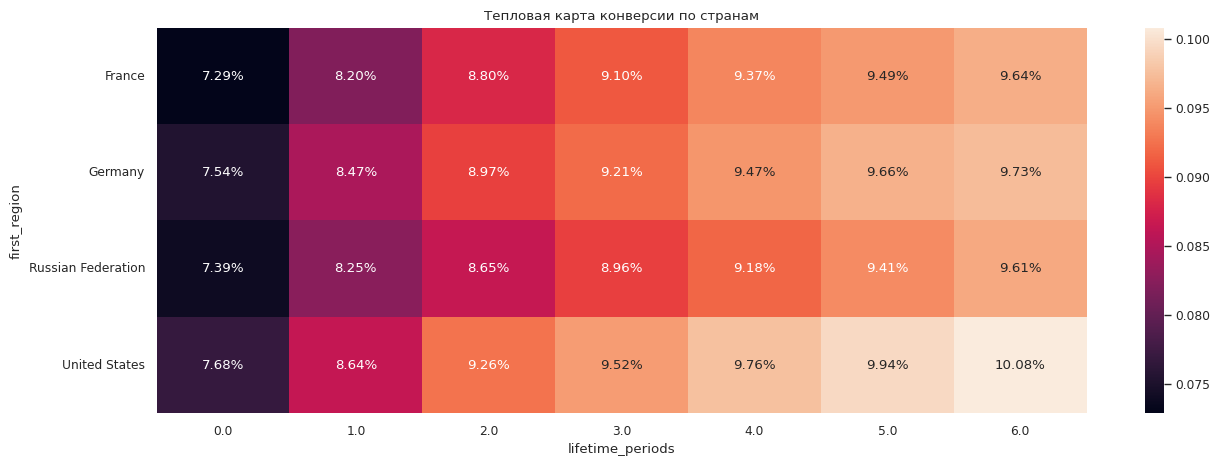

In [31]:
#@title heatmap conversion
_, \
cohorts_users, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                           observation_date=_OBSERVATION_DATE,
                                                           horizon=_HORIZON,
                                                           ignore_horizon=False, dimensions=['first_region'])

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(cohorts_conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по странам')
plt.show()

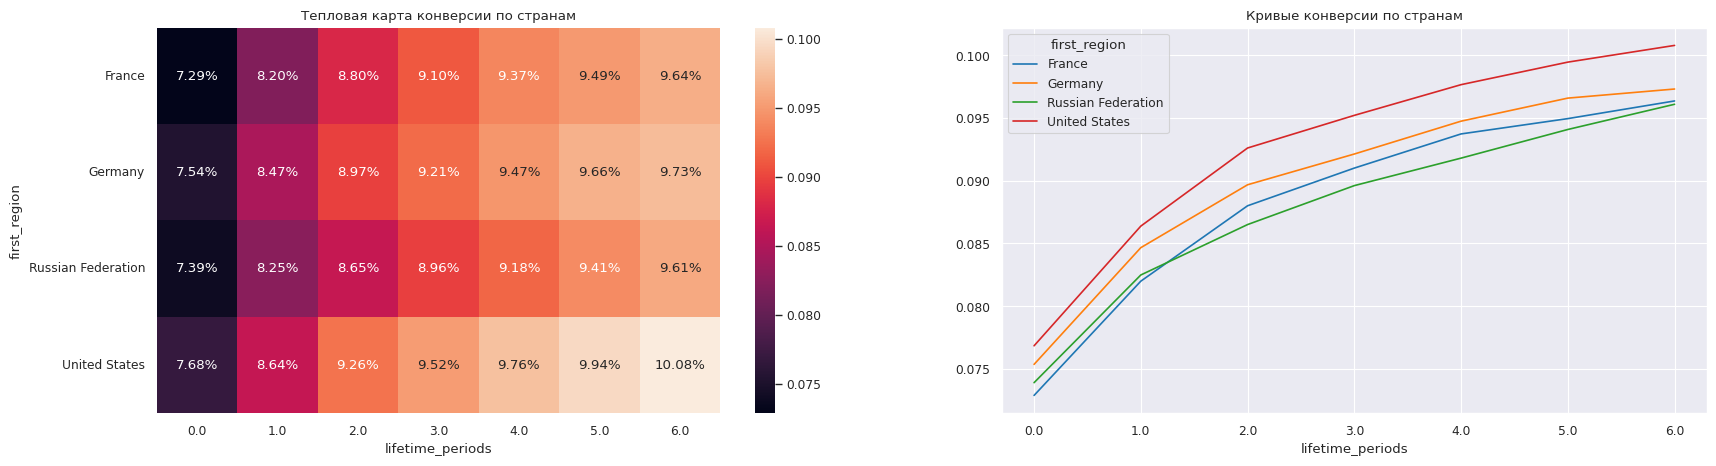

In [32]:
#@title heatmap and cohort conversion
plt.figure(figsize = (20, 5)) # задаём размер «подложки»

# исключаем размеры когорт
# конверсии первого дня различаются, их удалять не нужно
report = cohorts_conversion.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, fmt='.2%', ax=plt.subplot(1, 2, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта конверсии по странам')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)  # во второй — кривые конверсии
plt.title('Кривые конверсии по странам')

plt.show()

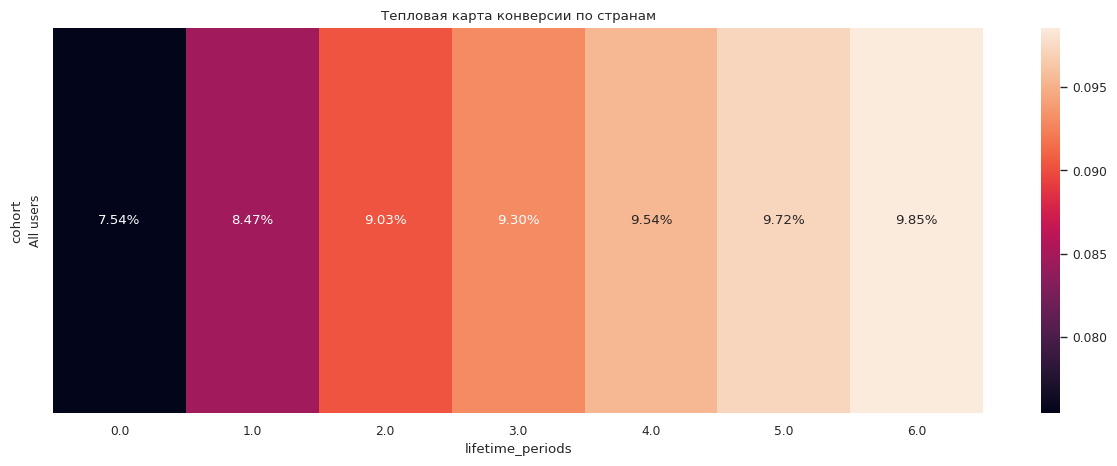

In [33]:
#@title heatmap conversion without dimensions - All users
_, \
cohorts_users, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                           observation_date=_OBSERVATION_DATE,
                                                           #last_cohort_moment=(sessions.session_start.max()-timedelta(6)).date(),
                                                           horizon=_HORIZON, ignore_horizon=False, dimensions=[])

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 5))
sns.heatmap(cohorts_conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии по странам')
plt.show()

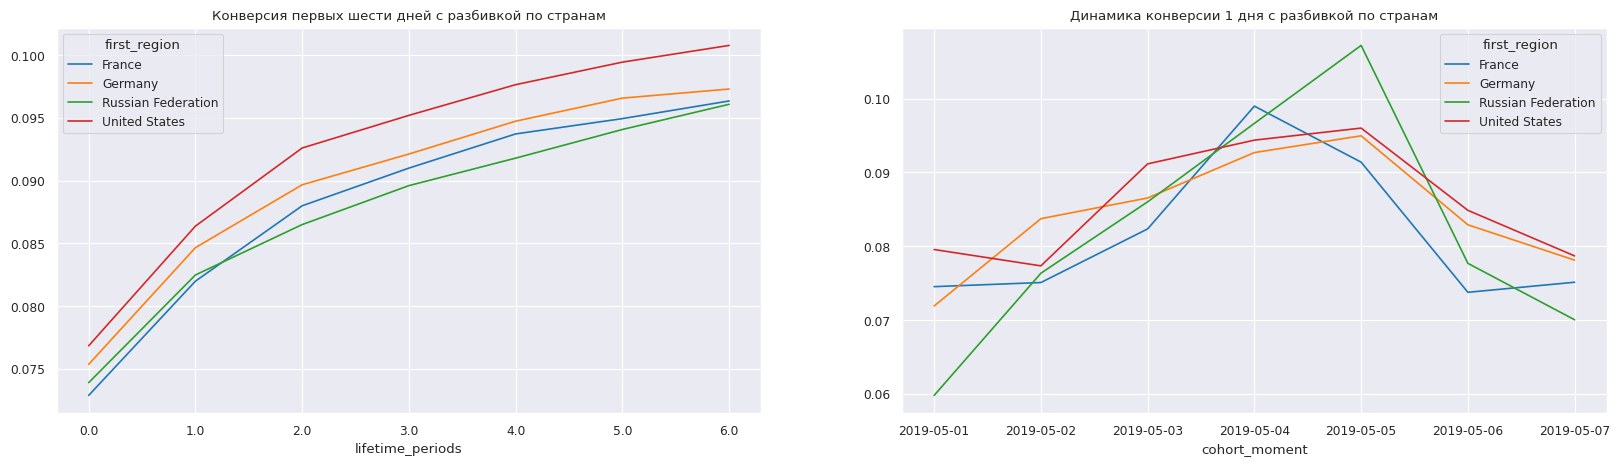

In [34]:
#@title conversion dynamics
_, \
_, cohorts_conversion, \
_, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                           #last_cohort_moment=(sessions.session_start.max()-timedelta(6)).date(),
                                           observation_date=_OBSERVATION_DATE,
                                           horizon=_HORIZON, ignore_horizon=False, dimensions=['first_region'] )
lt_period = 1
plt.figure(figsize=(20, 5)) # размер сетки для графиков

# для кривых конверсии исключаем размеры когорт
report = cohorts_conversion.drop(columns=['cohort_size'])
report.T.plot(
    # строим кривые конверсии в первой ячейке таблицы графиков
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия первых шести дней с разбивкой по странам')

# для графика истории изменений
# преобразуем таблицу динамики конверсии
report = (
    cohorts_conversion_dyn[lt_period]
    .reset_index()
    .pivot_table(index='cohort_moment', columns='first_region', values=1, aggfunc='mean')
    .fillna(0)  # заполняем пропуски на случай, если они возникнут
)
report.plot(
    # во второй ячейке строим график истории изменений
    grid=True, ax=plt.subplot(1, 2, 2)
)
plt.title(f'Динамика конверсии {lt_period} дня с разбивкой по странам')

plt.show()


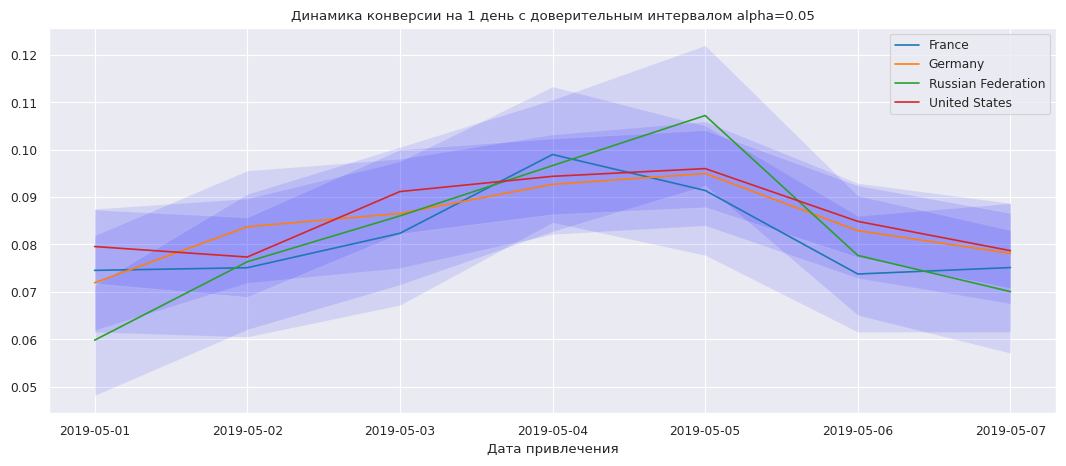

lifetime_periods                  cohort_size    1.0  conversion        se  \
first_region       cohort_moment                                             
France             2019-05-01            1570  117.0    0.074522  0.006628   
                   2019-05-02            1252   94.0    0.075080  0.007448   
                   2019-05-03            1263  104.0    0.082344  0.007735   
                   2019-05-04            1667  165.0    0.098980  0.007314   
                   2019-05-05            1707  156.0    0.091388  0.006975   
                   2019-05-06            1749  129.0    0.073756  0.006250   
                   2019-05-07            1451  109.0    0.075121  0.006920   
Germany            2019-05-01            2559  184.0    0.071903  0.005107   
                   2019-05-02            2102  176.0    0.083730  0.006041   
                   2019-05-03            2288  198.0    0.086538  0.005878   
                   2019-05-04            2913  270.0    0.092688  0.005373   
                   2019-05-05            2738  260.0    0.094960  0.005603   
                   2019-05-06            2907  241.0    0.082903  0.005114   
                   2019-05-07            2458  192.0    0.078112  0.005413   
Russian Federation 2019-05-01            1589   95.0    0.059786  0.005948   
                   2019-05-02            1323  101.0    0.076342  0.007301   
                   2019-05-03            1430  123.0    0.086014  0.007415   
                   2019-05-04            1728  167.0    0.096644  0.007108   
                   2019-05-05            1679  180.0    0.107207  0.007550   
                   2019-05-06            1725  134.0    0.077681  0.006445   
                   2019-05-07            1485  104.0    0.070034  0.006623   
United States      2019-05-01            4651  370.0    0.079553  0.003968   
                   2019-05-02            3879  300.0    0.077340  0.004289   
                   2019-05-03            4048  369.0    0.091156  0.004524   
                   2019-05-04            5118  483.0    0.094373  0.004086   
                   2019-05-05            5031  483.0    0.096005  0.004153   
                   2019-05-06            5173  439.0    0.084864  0.003875   
                   2019-05-07            4410  347.0    0.078685  0.004054   

lifetime_periods                      left     right  
first_region       cohort_moment                      
France             2019-05-01     0.061532  0.087513  
                   2019-05-02     0.060483  0.089677  
                   2019-05-03     0.067184  0.097504  
                   2019-05-04     0.084644  0.113316  
                   2019-05-05     0.077718  0.105058  
                   2019-05-06     0.061507  0.086006  
                   2019-05-07     0.061558  0.088683  
Germany            2019-05-01     0.061894  0.081912  
                   2019-05-02     0.071889  0.095571  
                   2019-05-03     0.075018  0.098059  
                   2019-05-04     0.082157  0.103219  
                   2019-05-05     0.083979  0.105941  
                   2019-05-06     0.072880  0.092927  
                   2019-05-07     0.067504  0.088721  
Russian Federation 2019-05-01     0.048129  0.071443  
                   2019-05-02     0.062033  0.090650  
                   2019-05-03     0.071482  0.100546  
                   2019-05-04     0.082712  0.110575  
                   2019-05-05     0.092408  0.122005  
                   2019-05-06     0.065050  0.090313  
                   2019-05-07     0.057054  0.083014  
United States      2019-05-01     0.071776  0.087330  
                   2019-05-02     0.068933  0.085746  
                   2019-05-03     0.082289  0.100023  
                   2019-05-04     0.086363  0.102382  
                   2019-05-05     0.087864  0.104145  
                   2019-05-06     0.077270  0.092458  
                   2019-05-07     0.070738  0.086631

In [35]:
#@title Conversion dynsmics with confidence interval
_, \
_, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                          #last_cohort_moment=(sessions.session_start.max()-timedelta(6)).date(),
                                                          observation_date=_OBSERVATION_DATE,
                                                          horizon=_HORIZON, ignore_horizon=False, dimensions=['first_region'] )


def plot_conversion_dynamics_intervals(dyn, lifetime_period=None, alpha=0.05, ):
    if lifetime_period is None:
        lifetime_period = _HORIZON - 1

    data = dyn[['cohort_size', lifetime_period]].copy()
    data['conversion'] = data[lifetime_period]/data['cohort_size']

    # стандартная ошибка
    data['se'] = np.sqrt(data['conversion'] * (1 - data['conversion']) / data['cohort_size'])

    # границы интервалов
    q = stats.norm.ppf(1 - alpha/2)
    data['left'] = data['conversion'] - q * data['se']
    data['right'] = data['conversion'] + q * data['se']

    plt.figure(figsize=(13,5))
    for i in dyn.reset_index().iloc[:, 0].unique():
        plt.plot(data.loc[i]['conversion'], label=f"{i}")
        plt.fill_between(data.loc[i].index, data.loc[i]['left'], data.loc[i]['right'], facecolor='blue', alpha=0.1, interpolate=True)
    plt.legend()
    plt.title(f"Динамика конверсии на {lifetime_period} день с доверительным интервалом alpha={alpha}")
    plt.xlabel("Дата привлечения")
    plt.show()
    return data

plot_conversion_dynamics_intervals(
    cohorts_users_dyn, #.loc[(["South Korea", ], slice(None)), :],
    lifetime_period=1
)

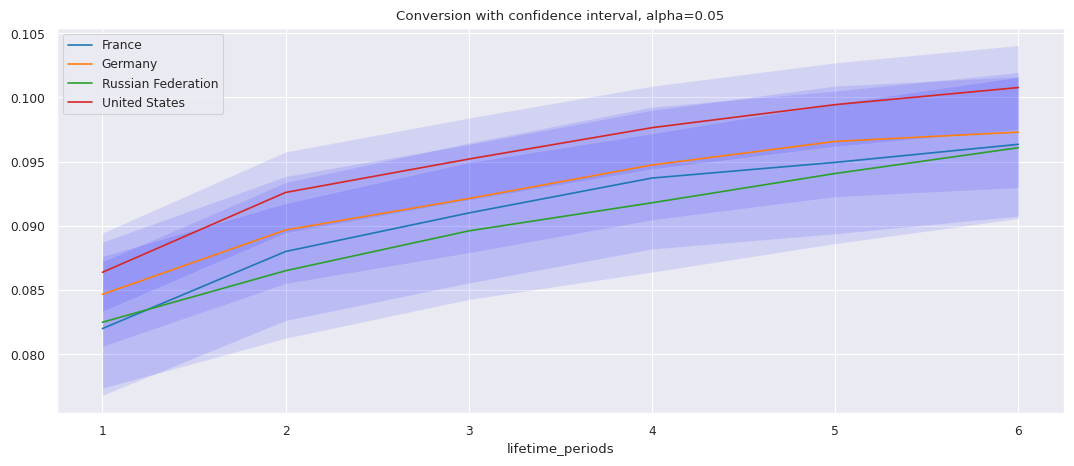

In [36]:
#@title Cohort conversion with confidence interval
_, \
cohorts_users, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                           observation_date=_OBSERVATION_DATE,
                                                           horizon=_HORIZON, ignore_horizon=False, dimensions=['first_region'])

def plot_conversion_intervals(users, alpha=0.05, ):
    data = users.T.copy()

    plt.figure(figsize=(13,5))
    for i in data.columns:
        # стандартная ошибка
        cohort_size = data.iloc[0][i]
        data[f'conversion_{i}'] = data[i]/cohort_size
        data[f'se_{i}'] = np.sqrt(data[f'conversion_{i}'] * (1 - data[f'conversion_{i}']) / cohort_size)

        # границы интервалов
        q = stats.norm.ppf(1 - alpha/2)
        data[f'left_{i}'] = data[f'conversion_{i}'] - q * data[f'se_{i}']
        data[f'right_{i}'] = data[f'conversion_{i}'] + q * data[f'se_{i}']

        plt.plot(data[f'conversion_{i}'].loc[1:], label=f"{i}")
        plt.fill_between(data[i].loc[1:].index.astype('float'),
                         data[f'left_{i}'].loc[1:].astype('float'),
                         data[f'right_{i}'].loc[1:].astype('float'),
                         facecolor='blue', alpha=0.1, interpolate=True)
    plt.legend()
    plt.title(f"Conversion with confidence interval, alpha={alpha}")
    plt.xlabel("lifetime_periods")
    plt.show()
    return data

data_part = cohorts_users #.loc[["South Korea", "Japan", ], "cohort_size":40]

qq = plot_conversion_intervals( data_part )


#LTV (ARPU)

In [37]:
#@title get_ltv function
def get_ltv(orders, profiles, observation_date, horizon, ignore_horizon=False, first_cohort_moment=None, dimensions=[]):
    """
    orders - журнал покупок / конверсионных событий
    profiles - профили пользователей
    observation_date - дата, из которой проводится анализ (обычно это последняя полная дата в журнале посещений)
    horizon - горизонт анализа
    ignore_horizon - игнорировать горизонт? (True - выводим все доступные когорты (треугольная матрица);
                                             False - выводим только когорты [0..hirizon-1])
    first_cohort_moment - если хотим ограничить и не брать в анализ старые когорты
    """
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon - 1)

    # исключаем пользователей, не «доживших» до горизонта анализа
    profiles_filtered = profiles[profiles.cohort_moment<=last_suitable_acquisition_date]

    if first_cohort_moment is not None:
        profiles_filtered = profiles_filtered[profiles_filtered.cohort_moment>=first_cohort_moment]

    ltv_raw = join_purchase_with_profiles(orders, profiles_filtered, mode='LTV')

    def group_by_dimensions(df, dims, horizon):
        if len(dims) == 0:
            df['cohort'] = "All users"
            dims = ['cohort']
        if dims == ['cohort_moment']:
            df['cohort'] = "All users"
            dims = ['cohort', 'cohort_moment', ]

        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        df_filtered = df[df.lifetime_periods<horizon]

        cohorts_revenue = df_filtered.pivot_table(index=dims, columns='lifetime_periods', values='revenue', aggfunc='sum') \
                          .fillna(0).cumsum(axis=1)


        cohorts_revenue['cohort_size'] = cohort_sizes
        cohorts_revenue = cohorts_revenue[['cohort_size'] + list(i for i in range(horizon if not ignore_horizon else len(cohorts_revenue.columns)-1) if i in cohorts_revenue.columns)]
        cohorts_revenue = cohorts_revenue.fillna(0)
        cohorts_ltv = cohorts_revenue.div(cohorts_revenue['cohort_size'], axis=0)
        cohorts_ltv['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC,
        # добавив параметры из dimensions
        cac = df[['user_id', 'cohort_cac'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'cohort_cac': 'mean'})
            .rename(columns={'cohort_cac': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = cohorts_ltv.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon))]

        return cohorts_revenue, cohorts_ltv, roi

    # агрегация без динамики ==
    cohorts_revenue, cohorts_ltv, roi = group_by_dimensions(ltv_raw, dimensions, horizon)

    # агрегация с динамикой ==
    cohorts_revenue_in_time, cohorts_ltv_in_time, roi_in_time = group_by_dimensions(ltv_raw, dimensions+['cohort_moment'], horizon)

    return (ltv_raw,
            cohorts_revenue, cohorts_ltv,
            cohorts_revenue_in_time, cohorts_ltv_in_time,
            roi, roi_in_time)


raw_data, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=['first_region']
               )

print("Lines in raw_data:", len(raw_data))
print("Dates in raw data:",raw_data.cohort_moment.min(), raw_data.cohort_moment.max())
#display_df(cohorts_revenue)
display_df(cohorts_ltv)

Lines in raw_data: 77311
Dates in raw data: 2019-05-01 2019-05-07


lifetime_periods    cohort_size       0.0       1.0       2.0       3.0  \
first_region                                                              
France                    10659  0.408551  0.510056  0.591898  0.649482   
Germany                   17965  0.447330  0.554723  0.641011  0.694796   
Russian Federation        10959  0.409546  0.511569  0.573951  0.629702   
United States             32310  0.444294  0.557324  0.648890  0.708570   

lifetime_periods         4.0       5.0       6.0  
first_region                                      
France              0.697421  0.739742  0.775330  
Germany             0.743575  0.787862  0.820144  
Russian Federation  0.671686  0.715045  0.748834  
United States       0.762878  0.805752  0.846253

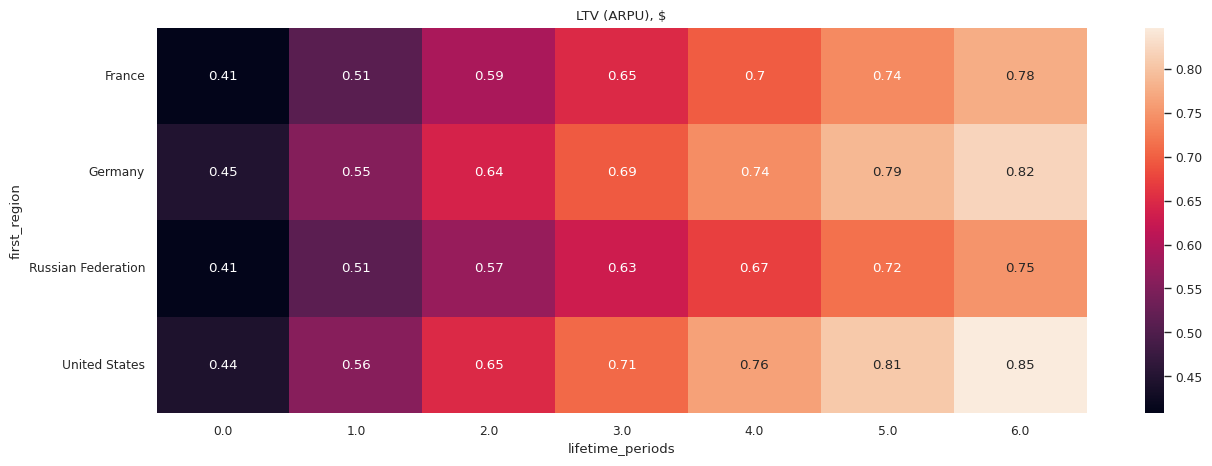

In [38]:
#@title heatmap LTV
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
_, _ = get_ltv(orders, profiles,
               observation_date=_OBSERVATION_DATE,
               horizon=_HORIZON, ignore_horizon=False,
               #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
               dimensions=['first_region']
              )

# строим хитмэп по таблице LTV
plt.figure(figsize=(15, 5))
sns.heatmap(cohorts_ltv.drop(columns=['cohort_size']), annot=True, )
plt.title('LTV (ARPU), $')
plt.show()

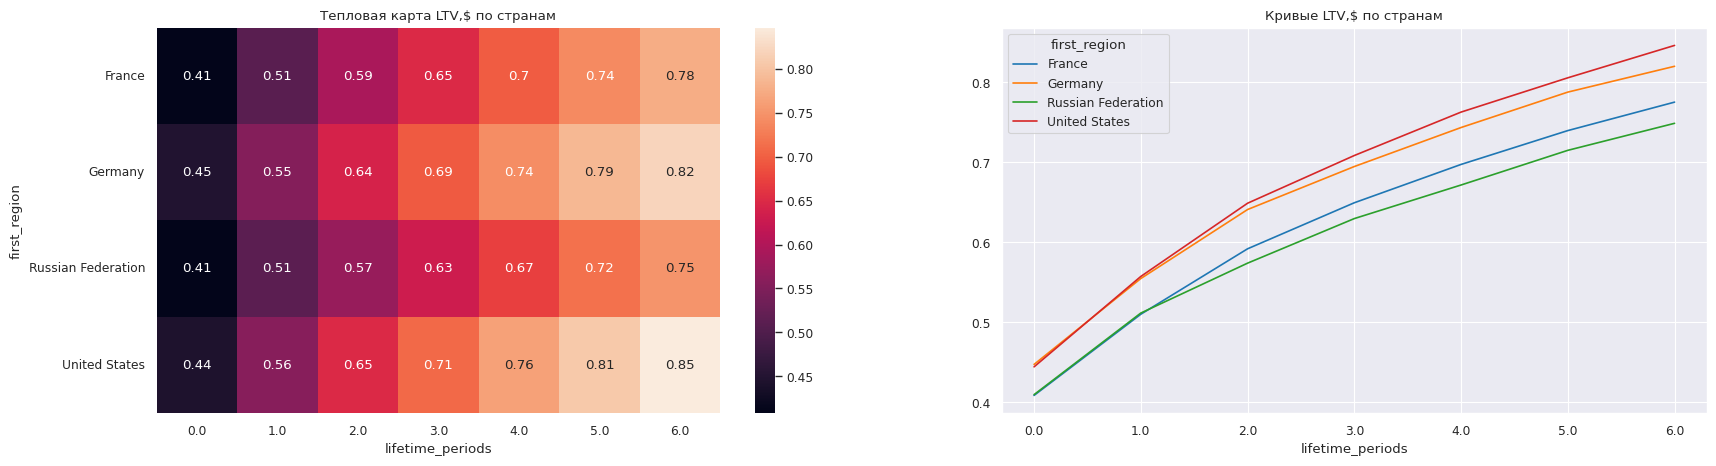

In [39]:
#@title heatmap and LTV dynamics
plt.figure(figsize = (20, 5)) # задаём размер «подложки»

# исключаем размеры когорт
# LTV первого дня различаются, их удалять не нужно
report = cohorts_ltv.drop(columns = ['cohort_size'])

sns.heatmap(
    report, annot=True, ax=plt.subplot(1, 2, 1)
)  # в первой ячейке таблицы графиков строим тепловую карту
plt.title('Тепловая карта LTV,$ по странам')

report.T.plot(
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 2)
)  # во второй — динамику LTV
plt.title('Кривые LTV,$ по странам')

plt.show()

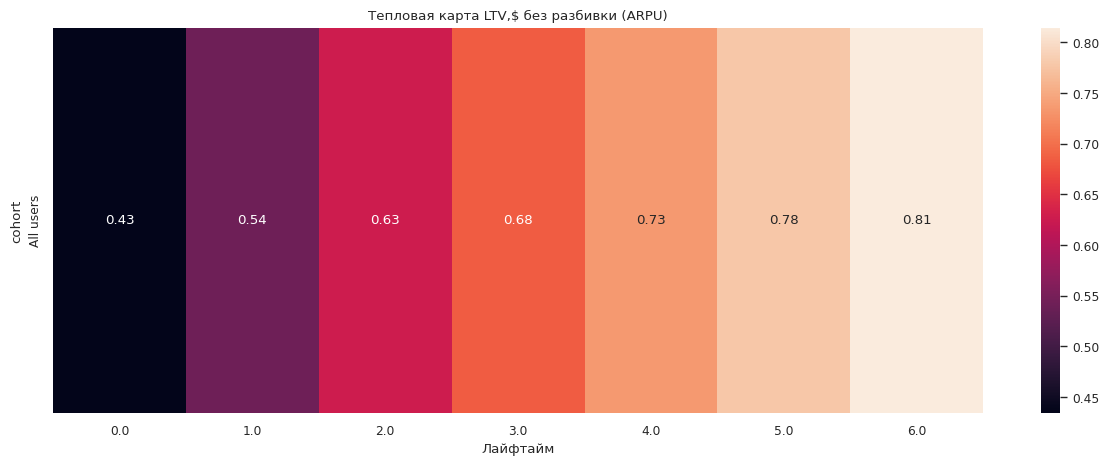

In [40]:
#@title heatmap LTV - All users
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
_, _ = get_ltv(orders, profiles,
               observation_date=_OBSERVATION_DATE,
               horizon=_HORIZON, ignore_horizon=False,
               #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
               dimensions=[]
              )
# строим хитмэп по таблице LTV
plt.figure(figsize=(15, 5))
sns.heatmap(cohorts_ltv.drop(columns=['cohort_size']), annot=True, )
plt.title('Тепловая карта LTV,$ без разбивки (ARPU)')
plt.xlabel('Лайфтайм')
plt.show()

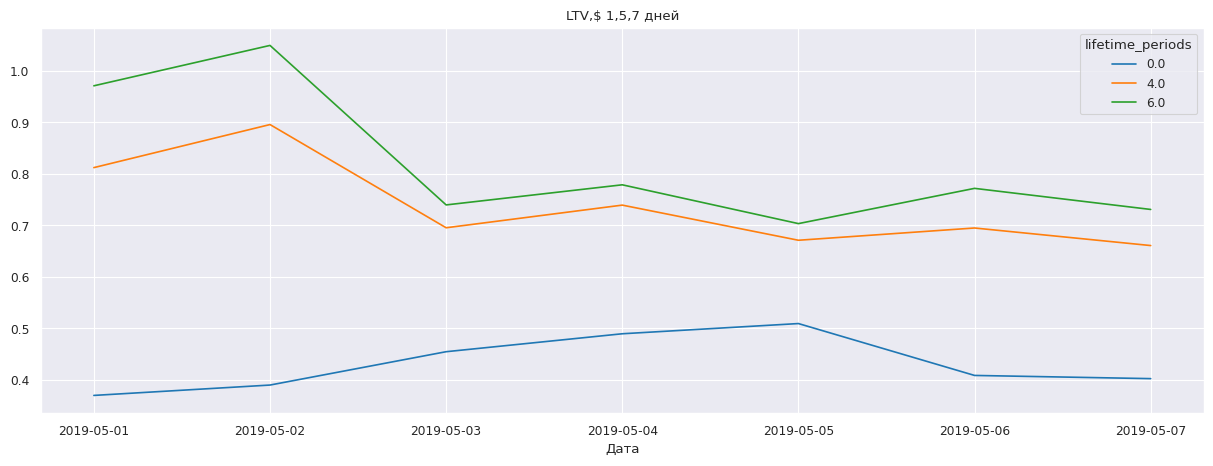

In [41]:
#@title LTV dynamics
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                       observation_date=_OBSERVATION_DATE,
                       horizon=_HORIZON, ignore_horizon=False,
                       #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                       dimensions=[]
                      )

cohorts_ltv_dyn.drop(columns=['cohort_size', ]).droplevel('cohort')[[0,4,6]].plot(
    grid=True,  # добавляем сетку
    figsize=(15, 5),  # размер графика
);
plt.xlabel('Дата')  # название оси X
plt.title('LTV,$ 1,5,7 дней')  # название графика
plt.show()

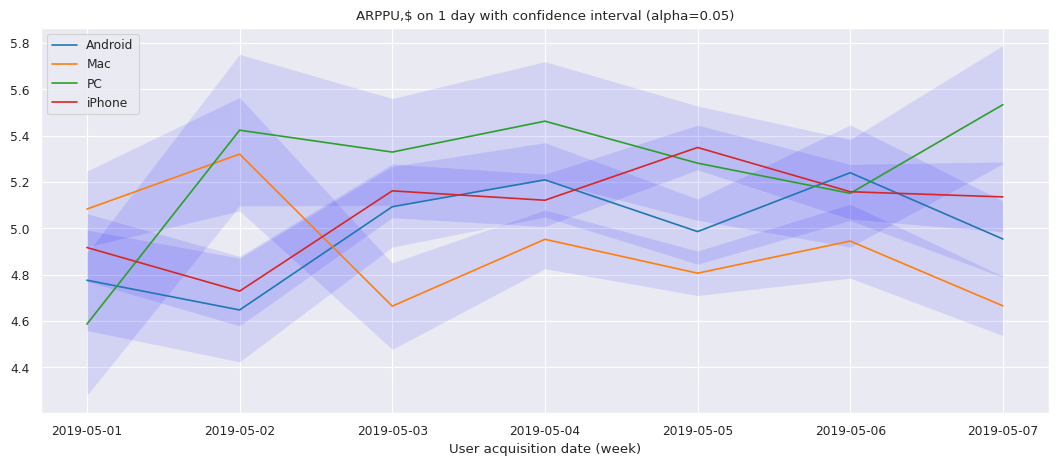

cohort_size      1.0       rpu        se  \
first_device cohort_moment                                             
Android      2019-05-01             205   979.05  4.775854  1.588098   
             2019-05-02             169   785.43  4.647515  1.488194   
             2019-05-03             184   937.14  5.093152  1.207555   
             2019-05-04             246  1281.48  5.209268  1.287718   
             2019-05-05             232  1156.71  4.985819  1.094458   
             2019-05-06             228  1194.70  5.239912  1.592533   
             2019-05-07             193   956.09  4.953834  1.170281   
Mac          2019-05-01             236  1199.60  5.083051  1.288968   
             2019-05-02             236  1255.54  5.320085  1.924768   
             2019-05-03             202   942.14  4.664059  1.357698   
             2019-05-04             319  1579.86  4.952539  1.159568   
             2019-05-05             293  1408.22  4.806212  0.843934   
             2019-05-06             287  1419.19  4.944913  1.387335   
             2019-05-07             209   975.05  4.665311  0.950784   
PC           2019-05-01              94   431.14  4.586596  1.523289   
             2019-05-02              99   536.93  5.423535  1.663696   
             2019-05-03             109   580.87  5.329083  1.232537   
             2019-05-04             131   715.58  5.462443  1.502953   
             2019-05-05             103   543.96  5.281165  1.280166   
             2019-05-06             124   638.73  5.151048  1.325258   
             2019-05-07              90   498.02  5.533556  1.238455   
iPhone       2019-05-01             492  2419.19  4.917053  1.669541   
             2019-05-02             401  1896.23  4.728753  1.541026   
             2019-05-03             419  2162.73  5.161647  1.223015   
             2019-05-04             541  2770.54  5.121146  1.355824   
             2019-05-05             537  2872.34  5.348864  1.151522   
             2019-05-06             482  2486.10  5.157884  1.341844   
             2019-05-07             398  2043.97  5.135603  1.544872   

                                left     right  
first_device cohort_moment                      
Android      2019-05-01     4.558459  4.993248  
             2019-05-02     4.423145  4.871885  
             2019-05-03     4.918672  5.267632  
             2019-05-04     5.048352  5.370185  
             2019-05-05     4.844986  5.126652  
             2019-05-06     5.033199  5.446626  
             2019-05-07     4.788730  5.118939  
Mac          2019-05-01     4.918601  5.247501  
             2019-05-02     5.074518  5.565652  
             2019-05-03     4.476829  4.851290  
             2019-05-04     4.825292  5.079787  
             2019-05-05     4.709579  4.902844  
             2019-05-06     4.784408  5.105418  
             2019-05-07     4.536410  4.794212  
PC           2019-05-01     4.278656  4.894536  
             2019-05-02     5.095814  5.751257  
             2019-05-03     5.097698  5.560467  
             2019-05-04     5.205073  5.719813  
             2019-05-05     5.033938  5.528392  
             2019-05-06     4.917790  5.384307  
             2019-05-07     5.277693  5.789418  
iPhone       2019-05-01     4.769529  5.064577  
             2019-05-02     4.577924  4.879582  
             2019-05-03     5.044542  5.278751  
             2019-05-04     5.006897  5.235395  
             2019-05-05     5.251470  5.446258  
             2019-05-06     5.038092  5.277676  
             2019-05-07     4.983828  5.287378

In [42]:
#@title LTV dynamics with confidence level
raw_data, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=['first_region']
               )

def plot_ltv_dynamics_intervals(dyn, dims=['first_region'], lifetime_period=None, alpha=0.05, rpu_mode="ARPPU", revenue_cut_quantile=0.99, ):
    if lifetime_period is None:
        lifetime_period = _HORIZON - 1

    #display(qq[qq.user_id==579124948949])
    #qq.loc[qq.revenue>0, 'revenue'].hist(bins=30);

    dyn['revenue'] = dyn.revenue.fillna(0)
    if rpu_mode == 'ARPPU':
        dyn = dyn[dyn.revenue>0]

    dyn = dyn[dims + ['cohort_moment', 'lifetime_periods', 'user_id', 'revenue']] \
         .groupby(dims + ['cohort_moment', 'lifetime_periods', 'user_id'], dropna=False)['revenue'].sum().reset_index()

    # удалим выбросы из выборки чтобы применить ЦПТ
    dyn = dyn[(dyn.revenue < dyn[dyn.revenue>0].revenue.quantile(revenue_cut_quantile))]

    #display(dyn.sort_values('revenue'))

    def get_ldow(dt_input):
        return dt_input + datetime.timedelta(days=(6 - dt_input.isoweekday() % 7))

    #dyn['cohort_moment'] = dyn.cohort_moment.map(get_ldow)
    #dyn['lifetime_periods'] = dyn.lifetime_periods//7

    # cohorts_recenue_dyn with filtered N quantile revenue
    tmp = dyn.pivot_table(index = dims + ['cohort_moment', ],
                   columns='lifetime_periods',
                   values='revenue',
                   aggfunc='sum', ).fillna(0).cumsum(axis=1).join(
                       dyn.groupby(dims + ['cohort_moment'])['user_id'].nunique()  # cohort_sizes
                   ).rename(columns={'user_id': 'cohort_size'})

    tmp = tmp[['cohort_size'] + list(i for i in range(lt_period + 1) if i in tmp.columns)]
    tmp['rpu'] = tmp[lt_period] / tmp['cohort_size']

    dyn['lifetime_periods'] = dyn['lifetime_periods'].fillna(0)
    tmp = tmp[['cohort_size', lt_period, 'rpu']] \
          .join(dyn.groupby(dims + ['cohort_moment']).apply(lambda x: x.loc[x.lifetime_periods<=lt_period, 'revenue'].std()).rename('se'))


    # границы интервалов
    q = stats.norm.ppf(1 - alpha/2)
    tmp['left'] = tmp['rpu'] - q * tmp['se']/np.sqrt(tmp['cohort_size'])
    tmp['right'] = tmp['rpu'] + q * tmp['se']/np.sqrt(tmp['cohort_size'])

    plt.figure(figsize=(13,5))
    for i in tmp.reset_index().iloc[:, 0].unique():
    #for i in ['Hong Kong', 'South Korea']:
        plt.plot(tmp.loc[i]['rpu'], label=f"{i}")
        plt.fill_between(tmp.loc[i].index, tmp.loc[i]['left'], tmp.loc[i]['right'], facecolor='blue', alpha=0.1, interpolate=True)
    plt.legend()
    plt.title(f"{rpu_mode},$ on {lt_period} day with confidence interval (alpha={alpha})")
    plt.xlabel("User acquisition date (week)")
    plt.show()

    return tmp

plot_ltv_dynamics_intervals(raw_data, dims=['first_device'],
                            lifetime_period=None, alpha=0.05, rpu_mode="ARPPU", revenue_cut_quantile=0.99, )

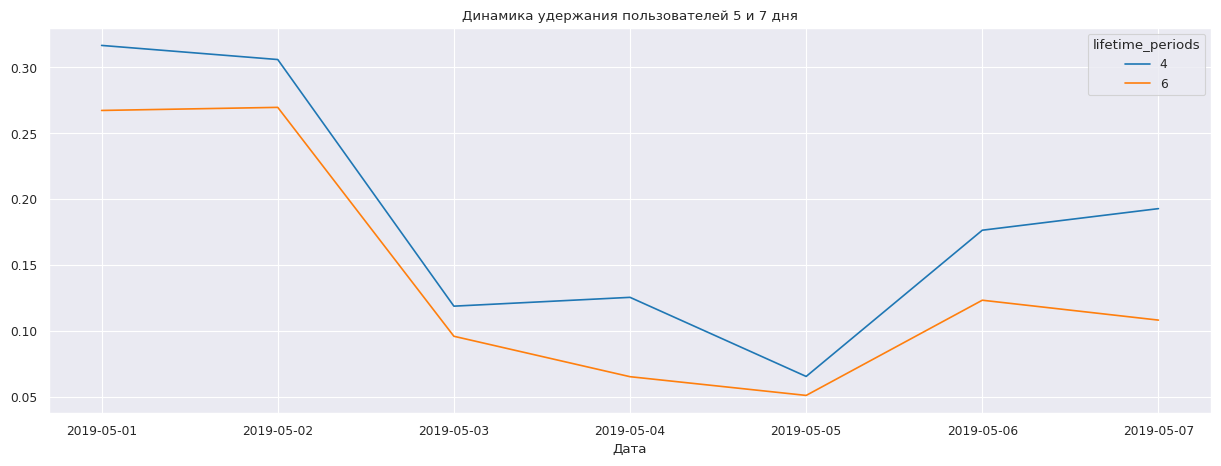

In [43]:
#@title проверим гипотезу
"""
Любопытно: для пользователей, привлечённых между 2 и 6 мая,
LTV первого дня, отражённый на нижней линии, растёт,
а LTV пятого и седьмого дня (средняя и верхняя линии), наоборот, падает.

Проверим одно из предположений — о привлечении пользователей, которые много покупали, но быстро «отваливались».

Похоже, предположение подтвердилось: падение удержания платящих пользователей совпадает
по времени со снижением LTV пятого и седьмого дней.
"""
if dataset==1:
    _, _, _, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                                   observation_date=_OBSERVATION_DATE,
                                                                   horizon=7, ignore_horizon=False, dimensions=['purchase_event'])

    cohorts_retention_dyn.loc[True, [4, 6]].plot(
        grid=True,  # добавляем сетку
        figsize=(15, 5),  # размер графика
    );
    plt.xlabel('Дата')  # название оси X
    plt.title('Динамика удержания пользователей 5 и 7 дня')  # название графика
    plt.show()

#CAC и ROI

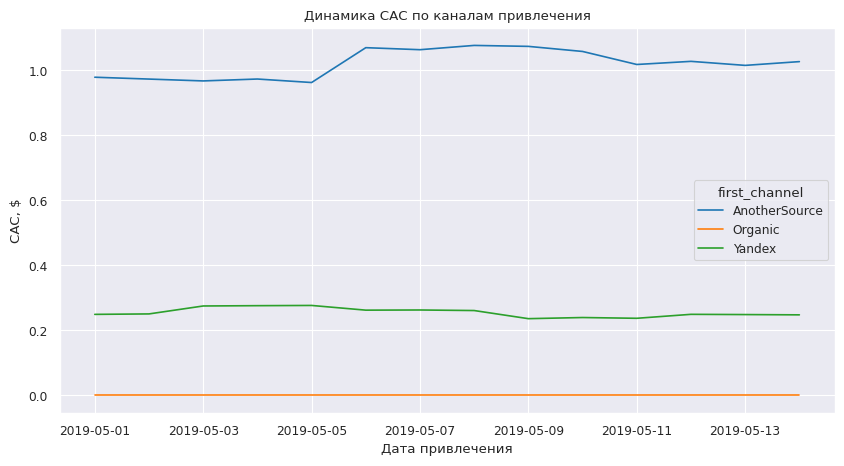

In [44]:
#@title CAC by first_channel
profiles.pivot_table(
    index='cohort_moment', columns='first_channel', values='cohort_cac', aggfunc='mean' # или first в данном случае не важно
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

lifetime_periods  cohort_size       0.0       1.0       2.0       3.0  \
first_channel                                                           
AnotherSource           12575  0.305974  0.362008  0.416706  0.455056   
Organic                 35273  0.494700  0.625516  0.723143  0.789780   
Yandex                  24045  0.413276  0.515684  0.596086  0.649590   

lifetime_periods       4.0       5.0       6.0  
first_channel                                   
AnotherSource     0.482119  0.504817  0.531809  
Organic           0.849941  0.899009  0.936868  
Yandex            0.696990  0.742361  0.782424

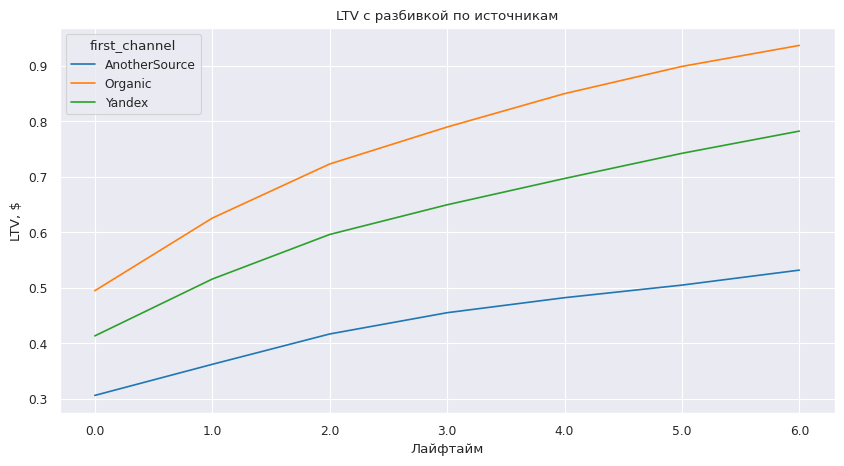

In [45]:
#@title Calculating LTV by first_channel
ltv_raw, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                       observation_date=_OBSERVATION_DATE,
                       horizon=_HORIZON, ignore_horizon=False,
                       dimensions=['first_channel']
                      )

# таблица LTV
display(cohorts_ltv)

# кривые LTV
report = cohorts_ltv.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('LTV с разбивкой по источникам')
plt.ylabel('LTV, $')
plt.xlabel('Лайфтайм')
plt.show()

user_id
cohort_moment         
2019-05-01       10369
2019-05-02        8556
2019-05-03        9029
2019-05-04       11426
2019-05-05       11155
2019-05-06       11554
2019-05-07        9804

cac
first_channel          
AnotherSource  0.999141
Organic        0.000000
Yandex         0.264984

lifetime_periods  cohort_size       0.0       1.0       2.0       3.0  \
first_channel                                                           
AnotherSource           12575  0.306237  0.362319  0.417064  0.455447   
Yandex                  24045  1.559627  1.946097  2.249517  2.451433   

lifetime_periods       4.0       5.0       6.0  
first_channel                                   
AnotherSource     0.482534  0.505251  0.532266  
Yandex            2.630310  2.801531  2.952722

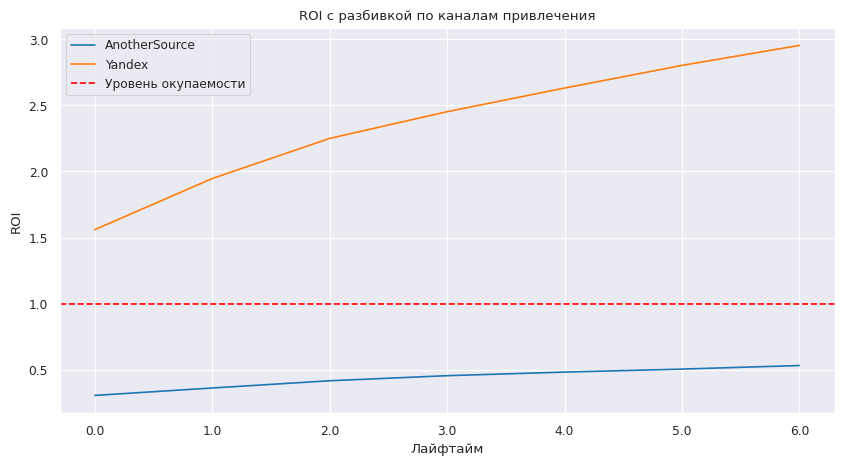

In [46]:
#@title EXAMPLE Calculation ROI
# находим максимальную дату привлечения из сырых данных LTV
max_acquitision_dt = ltv_raw['cohort_moment'].dropna().max()
# отсекаем профили, которые «старше» этой даты
ltv_profiles = profiles.query('cohort_moment <= @max_acquitision_dt')
# оставшееся число пользователей на каждый лайфтайм
display(ltv_profiles.groupby('cohort_moment').agg({'user_id': 'nunique'}))

#а можно так
#cohorts_ltv_dyn.cohort_size.groupby('cohort_moment').sum()
#или так
#cohorts_revenue_dyn.cohort_size.groupby('cohort_moment').sum()

#CAC by first_channel
cac = (
    ltv_profiles.groupby('first_channel')
    .agg({'cohort_cac': 'mean'})
    .rename(columns={'cohort_cac': 'cac'})
)
display(cac)

#Calculating ROI
roi = cohorts_ltv.div(cac['cac'], axis=0)
roi['cohort_size'] = cohorts_ltv['cohort_size']
roi = roi[~np.isinf(roi[0])]
display(roi)
report = roi.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

lifetime_periods  cohort_size       cac       0.0       1.0       2.0  \
first_channel                                                           
AnotherSource           12575  0.999141  0.306237  0.362319  0.417064   
Yandex                  24045  0.264984  1.559627  1.946097  2.249517   

lifetime_periods       3.0       4.0       5.0       6.0  
first_channel                                             
AnotherSource     0.455447  0.482534  0.505251  0.532266  
Yandex            2.451433  2.630310  2.801531  2.952722

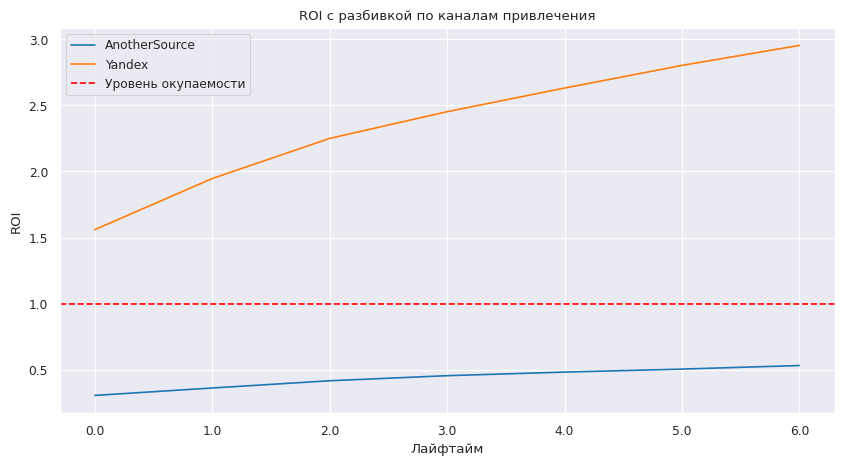

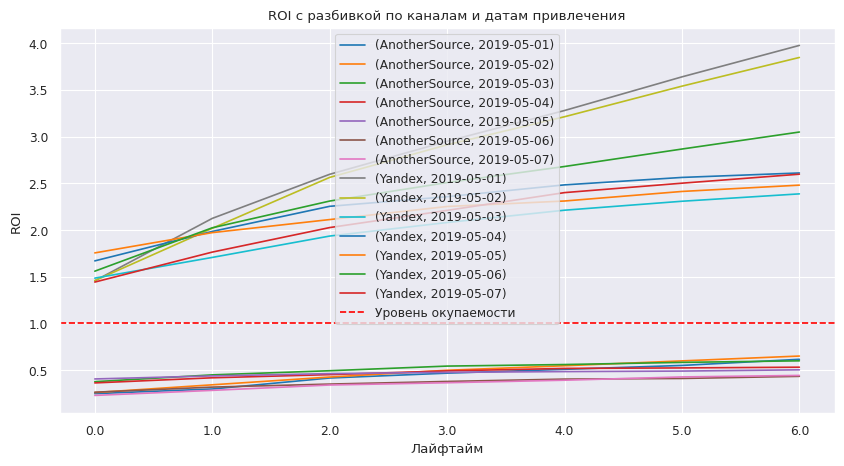

In [47]:
#@title ROI returned with get_ltv
ltv_raw, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                       observation_date=_OBSERVATION_DATE,
                       horizon=_HORIZON, ignore_horizon=False,
                       dimensions=['first_channel']
                      )
display(roi)
report = roi.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

report = roi_dyn.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам и датам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

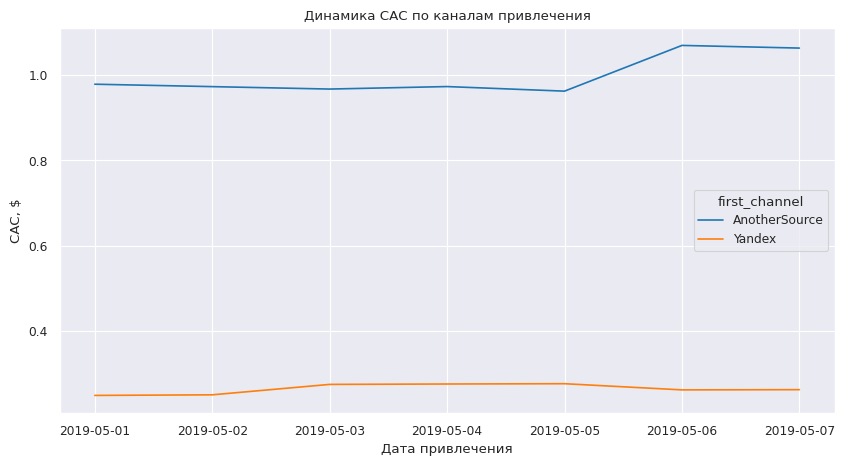

In [48]:
#@title строим график истории изменений CAC по таблице с динамикой ROI
roi_dyn.pivot_table(
    index='cohort_moment', columns='first_channel', values='cac', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

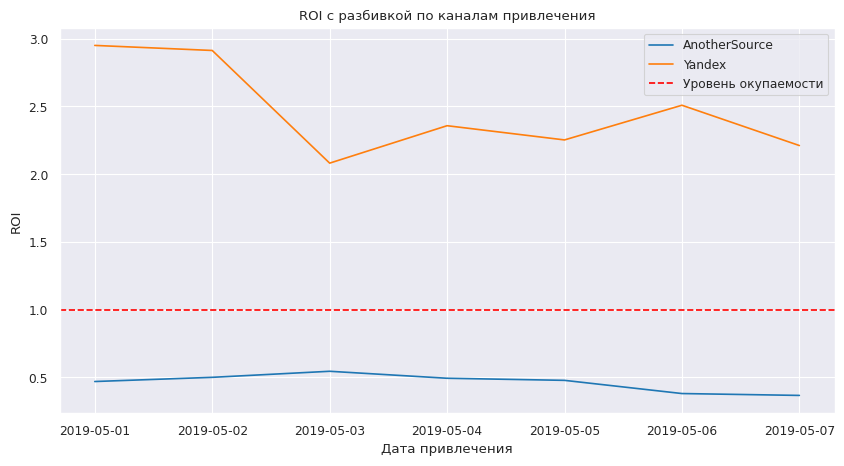

In [49]:
#@title dynamics plot of first day ROI

roi_dyn.pivot_table(
    index='cohort_moment', columns='first_channel', values=3, aggfunc='mean'
).plot(grid=True, figsize=(10, 5))

plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Дата привлечения')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

#Visualisation

lifetime_periods             cohort_size    0         1         2         3  \
purchase_event first_device                                                   
False          Android             12850  1.0  0.243191  0.143891  0.102101   
               Mac                 16174  1.0  0.233894  0.146902  0.099172   
               PC                   6744  1.0  0.235024  0.141311  0.100830   
               iPhone              28812  1.0  0.239067  0.142996  0.101902   
True           Android              1466  1.0  0.377217  0.284447  0.218281   
               Mac                  1791  1.0  0.394193  0.296482  0.232272   
               PC                    752  1.0  0.378989  0.284574  0.207447   
               iPhone               3304  1.0  0.375303  0.282385  0.196429   

lifetime_periods                    4         5         6  
purchase_event first_device                                
False          Android       0.077121  0.061012  0.050584  
               Mac           0.075553  0.062817  0.050390  
               PC            0.080813  0.064353  0.055160  
               iPhone        0.076704  0.061329  0.048799  
True           Android       0.167121  0.156207  0.137108  
               Mac           0.184255  0.139587  0.144054  
               PC            0.176862  0.147606  0.130319  
               iPhone        0.184927  0.165860  0.129843

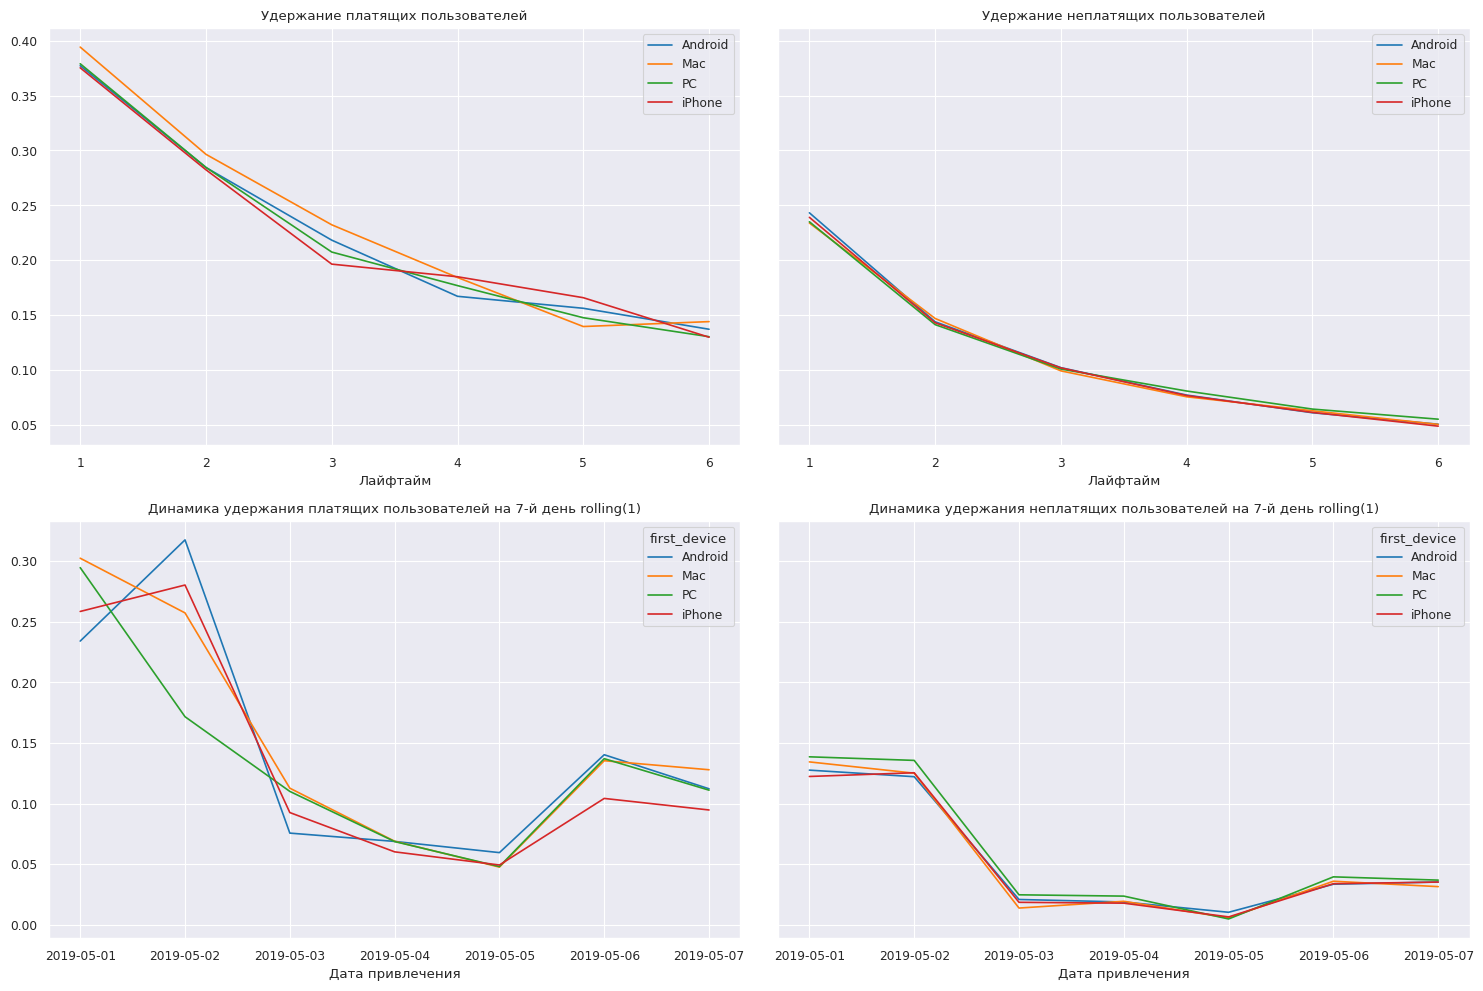

In [50]:
#@title Retention rate & dynamics for n-group cohort
_, cohorts_users, cohorts_retention, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON, ignore_horizon=False,
                                                               #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                                                               dimensions=['purchase_event', 'first_device']
                                                              )
display_df(cohorts_retention)

def plot_cohorts_retention(retention, retention_dyn, horizon, rolling_window=1):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержания первого дня
    retention = retention.drop(columns=['cohort_size', 0])

    # если в индексах таблицы удержания только purchase_event,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'purchase_event'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('purchase_event == True').droplevel('purchase_event').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке — кривые удержания неплатящих
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('purchase_event == False').droplevel('purchase_event').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [name for name in retention_dyn.index.names if name not in ['cohort_moment', 'purchase_event']]
    # фильтруем данные, строим сводную таблицу и график по ней
    tmp = retention_dyn.query('purchase_event == True').pivot_table(
        index='cohort_moment', columns=columns, values=horizon-1, aggfunc='mean'
    )
    tmp.rolling(rolling_window).mean().plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    title = 'Динамика удержания платящих пользователей на {}-й день'.format(horizon)
    title = f'{title} rolling({rolling_window})'
    plt.title(title)

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey = ax3)
    # фильтруем данные, строим сводную таблицу и график по ней
    tmp = retention_dyn.query('purchase_event == False').pivot_table(
        index='cohort_moment', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    tmp.rolling(rolling_window).mean().plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    title = 'Динамика удержания неплатящих пользователей на {}-й день'.format(horizon)
    title = f'{title} rolling({rolling_window})'
    plt.title(title)

    # исключаем наложение графиков друг на друга
    plt.tight_layout()
    plt.show()

plot_cohorts_retention(cohorts_retention, cohorts_retention_dyn, _HORIZON, 1)

lifetime_periods  cohort_size       0.0       1.0       2.0       3.0  \
first_device                                                            
Android                 14316  0.076139  0.085219  0.090738  0.093671   
Mac                     17965  0.073198  0.082104  0.087670  0.090509   
PC                       7496  0.075640  0.085112  0.090048  0.092583   
iPhone                  32116  0.076348  0.085845  0.091543  0.094096   

lifetime_periods       4.0       5.0       6.0  
first_device                                    
Android           0.095627  0.097513  0.099399  
Mac               0.093070  0.094795  0.096020  
PC                0.094851  0.096718  0.097652  
iPhone            0.096836  0.098611  0.099763

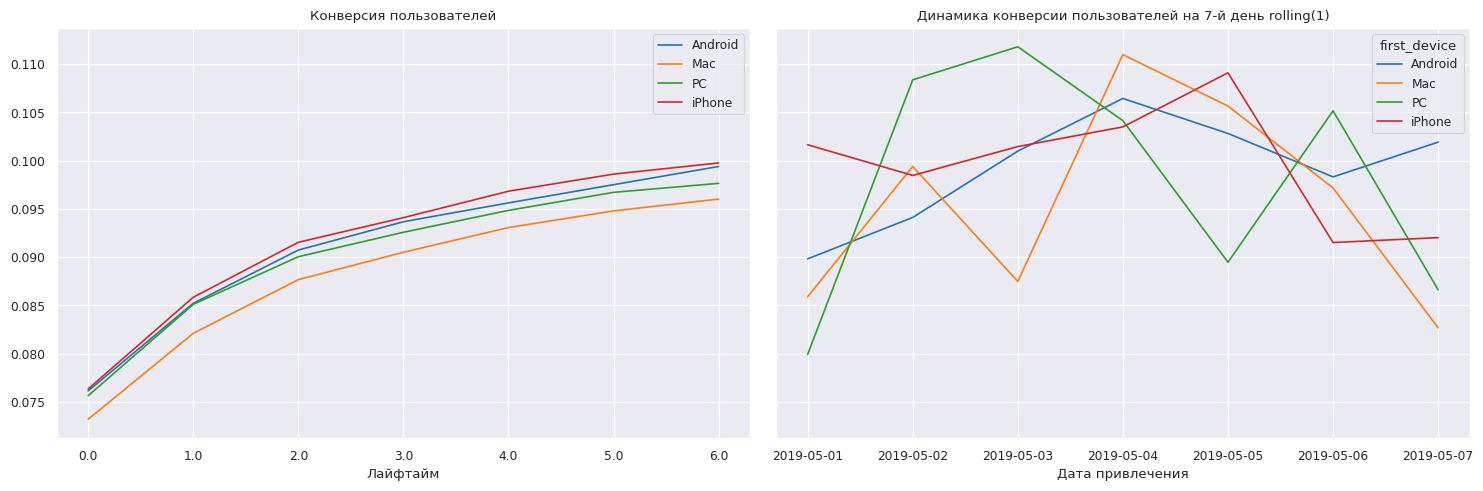

In [51]:
#@title Conversion & dynamics for n-group cohort
_, \
cohorts_users, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                           observation_date=_OBSERVATION_DATE,
                                                           horizon=_HORIZON, ignore_horizon=False,
                                                           #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                                                           dimensions=['first_device']
                                                          )
display_df(cohorts_conversion)


def plot_cohorts_conversion(conversion, conversion_dyn, horizon, rolling_window=1):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_dyn = conversion_dyn.drop(columns=['cohort_size'])[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')


    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in conversion_dyn.index.names if name not in ['cohort_moment']]
    tmp = conversion_dyn.pivot_table(index='cohort_moment', columns=columns, values=horizon - 1, aggfunc='mean')
    tmp.rolling(rolling_window).mean().plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    title = 'Динамика конверсии пользователей на {}-й день'.format(horizon)
    title = f'{title} rolling({rolling_window})'
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_cohorts_conversion(cohorts_conversion, cohorts_conversion_dyn, _HORIZON, 1)


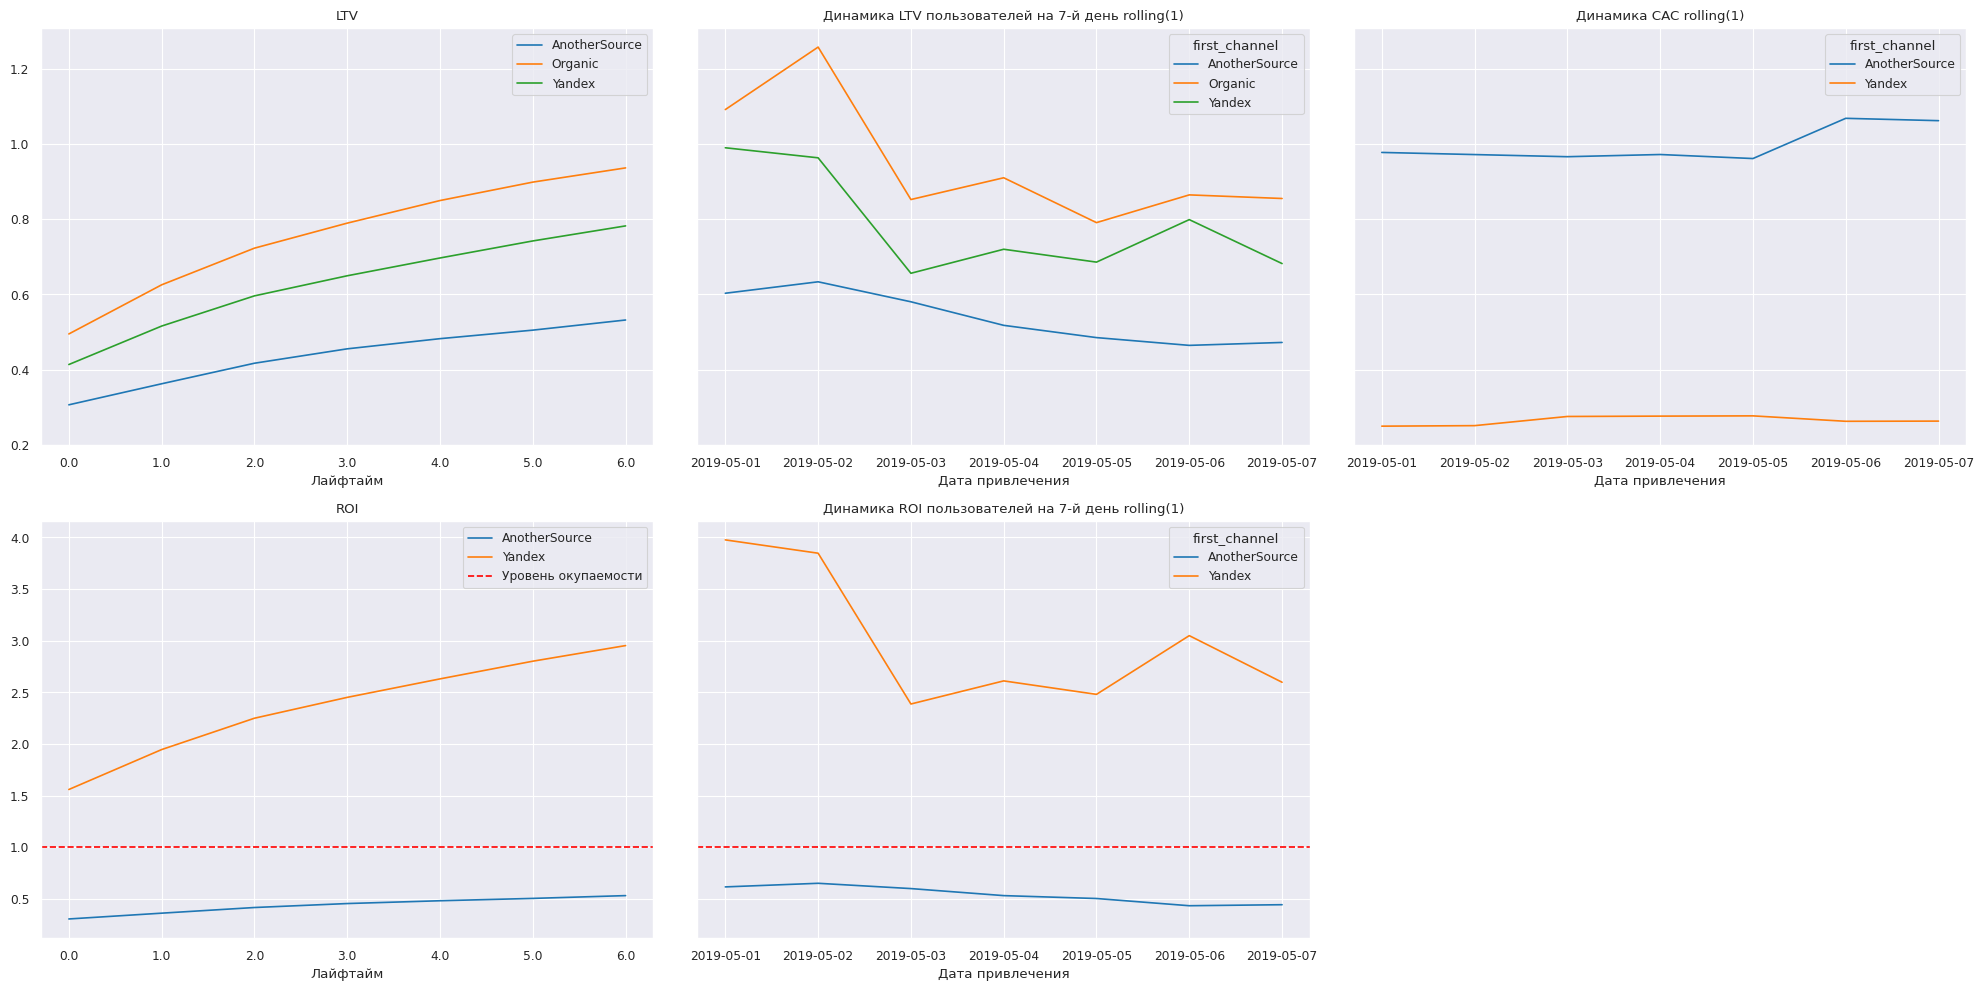

In [52]:
#@title LTV,ROI & dynamics for n-group cohort
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=['first_channel']
               )

def plot_ltv_roi(ltv, ltv_dyn, roi, roi_dyn, horizon, rolling_window=1):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_dyn = ltv_dyn.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_dyn[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_dyn = roi_dyn.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_dyn.index.names if name not in ['cohort_moment']]
    tmp = ltv_dyn.pivot_table(
        index='cohort_moment', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    tmp.rolling(rolling_window).mean().plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    title = 'Динамика LTV пользователей на {}-й день'.format(horizon)
    title = f'{title} rolling({rolling_window})'
    plt.title(title)

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['cohort_moment']]
    tmp = cac_history.pivot_table(
        index='cohort_moment', columns=columns, values='cac', aggfunc='mean'
    )
    tmp.rolling(rolling_window).mean().plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    title = 'Динамика CAC'
    title = f'{title} rolling({rolling_window})'
    plt.title(title)

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_dyn.index.names if name not in ['cohort_moment']]
    tmp = roi_dyn.pivot_table(
        index='cohort_moment', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    tmp.rolling(rolling_window).mean().plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    title = 'Динамика ROI пользователей на {}-й день'.format(horizon)
    title = f'{title} rolling({rolling_window})'
    plt.title(title)

    plt.tight_layout()
    plt.show()

# строим графики
plot_ltv_roi(cohorts_ltv, cohorts_ltv_dyn, roi, roi_dyn, _HORIZON, 1)

#COMMON RESEARCH ORDER

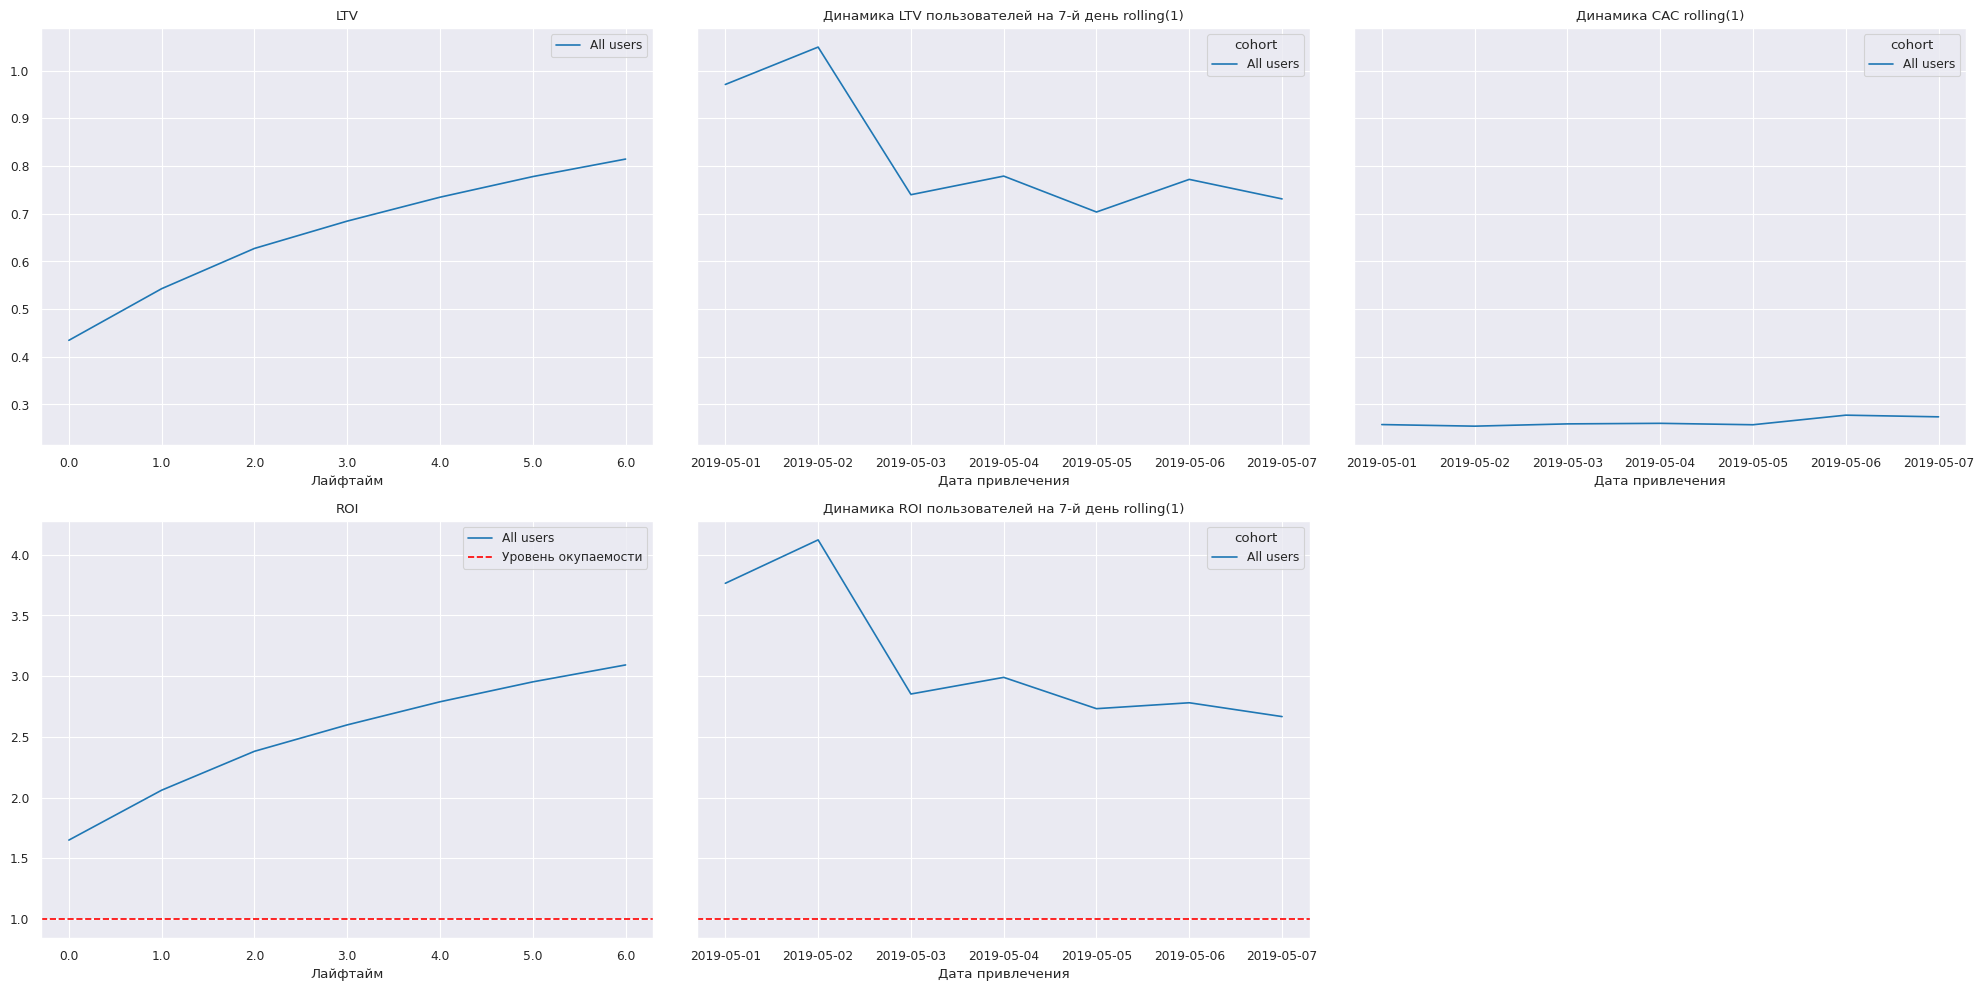

In [53]:
#@title Common situation
#Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=[]
               )

plot_ltv_roi(cohorts_ltv, cohorts_ltv_dyn, roi, roi_dyn, 7, 1)

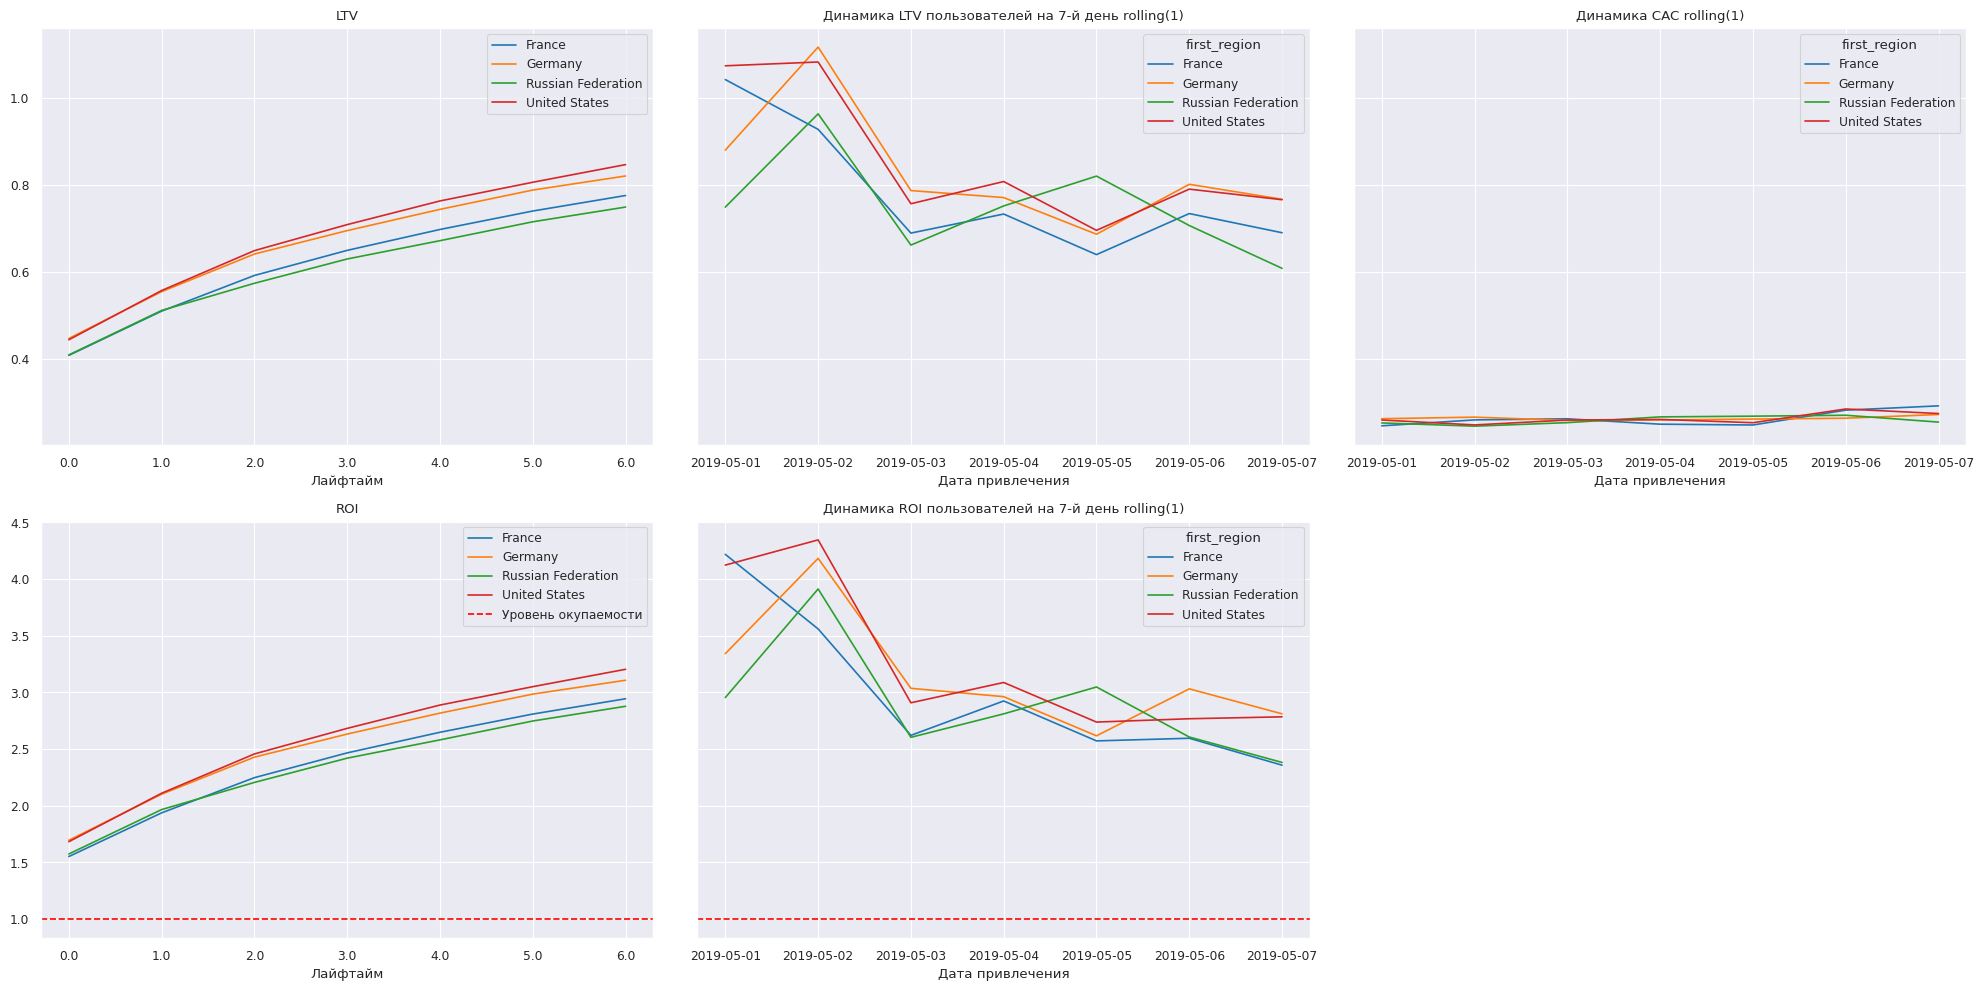

In [54]:
#@title ROI by region
#Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=['first_region']
               )

plot_ltv_roi(cohorts_ltv, cohorts_ltv_dyn, roi, roi_dyn, 7, 1)

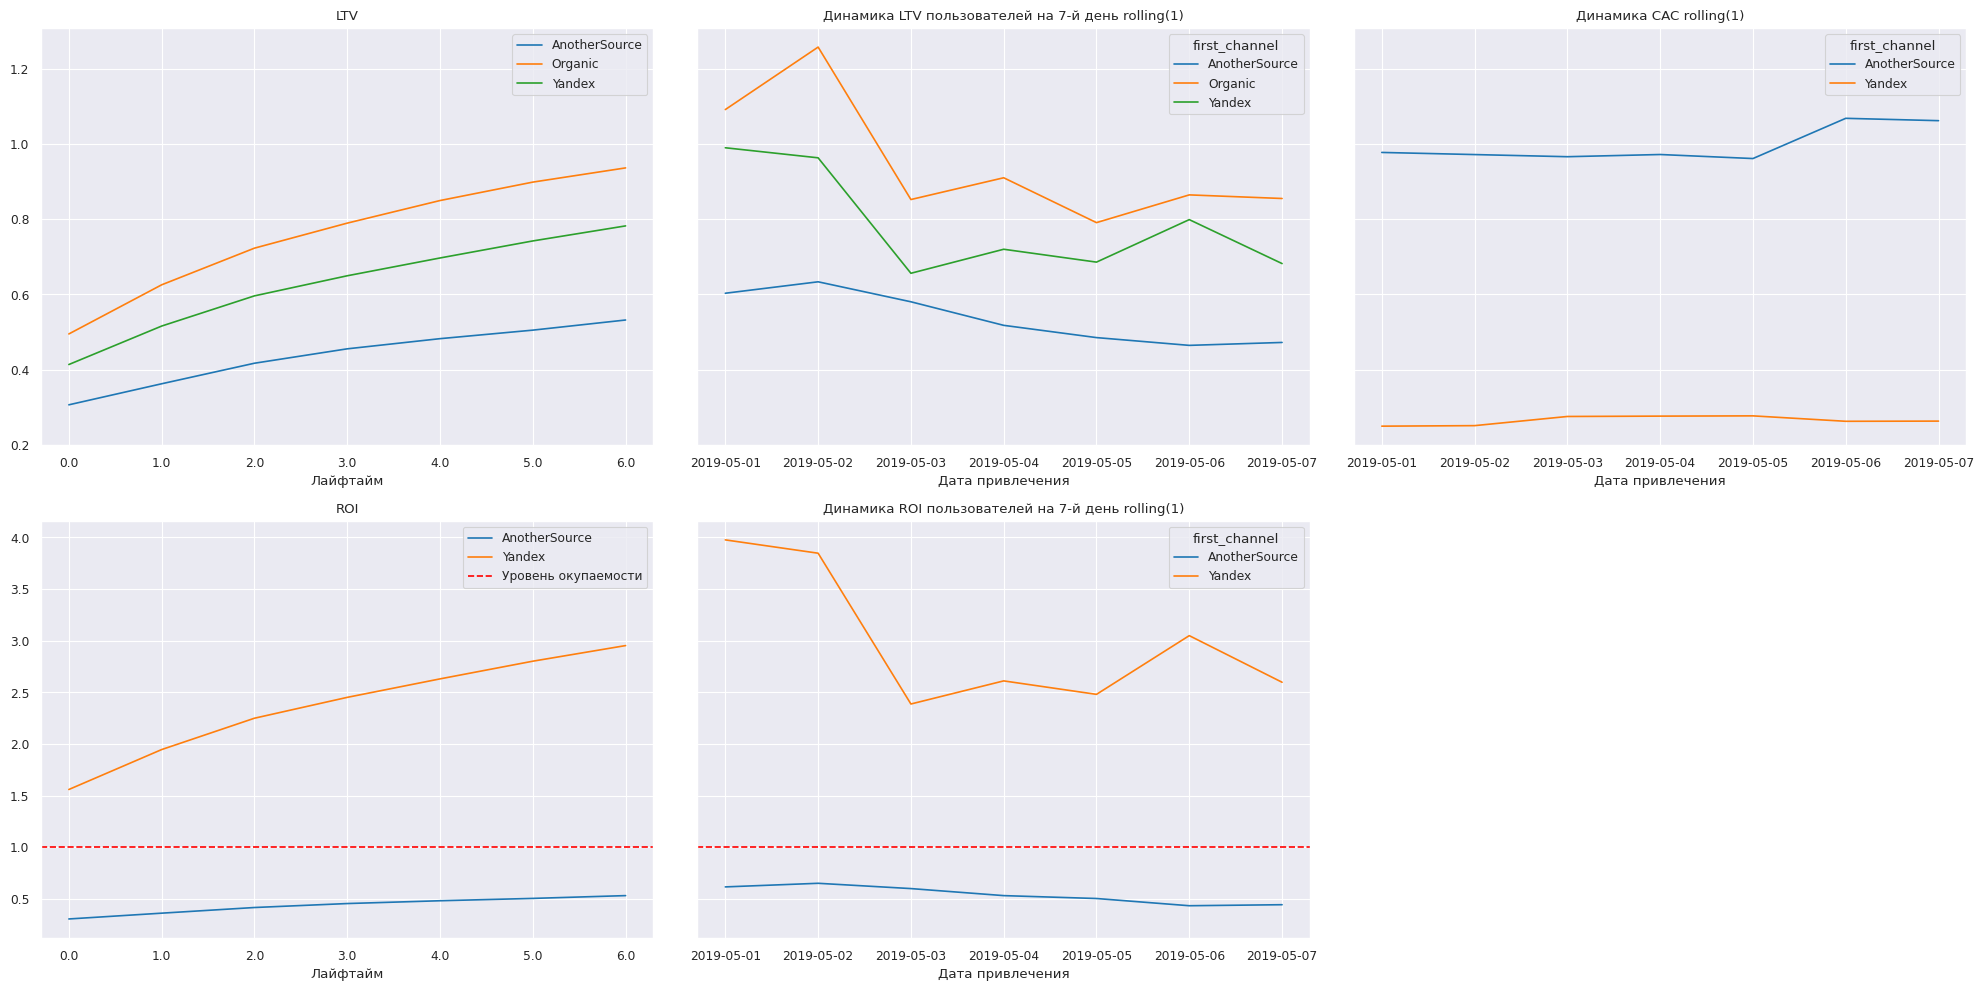

In [55]:
#@title ROI by channel
#Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=['first_channel']
               )

plot_ltv_roi(cohorts_ltv, cohorts_ltv_dyn, roi, roi_dyn, 7, 1)

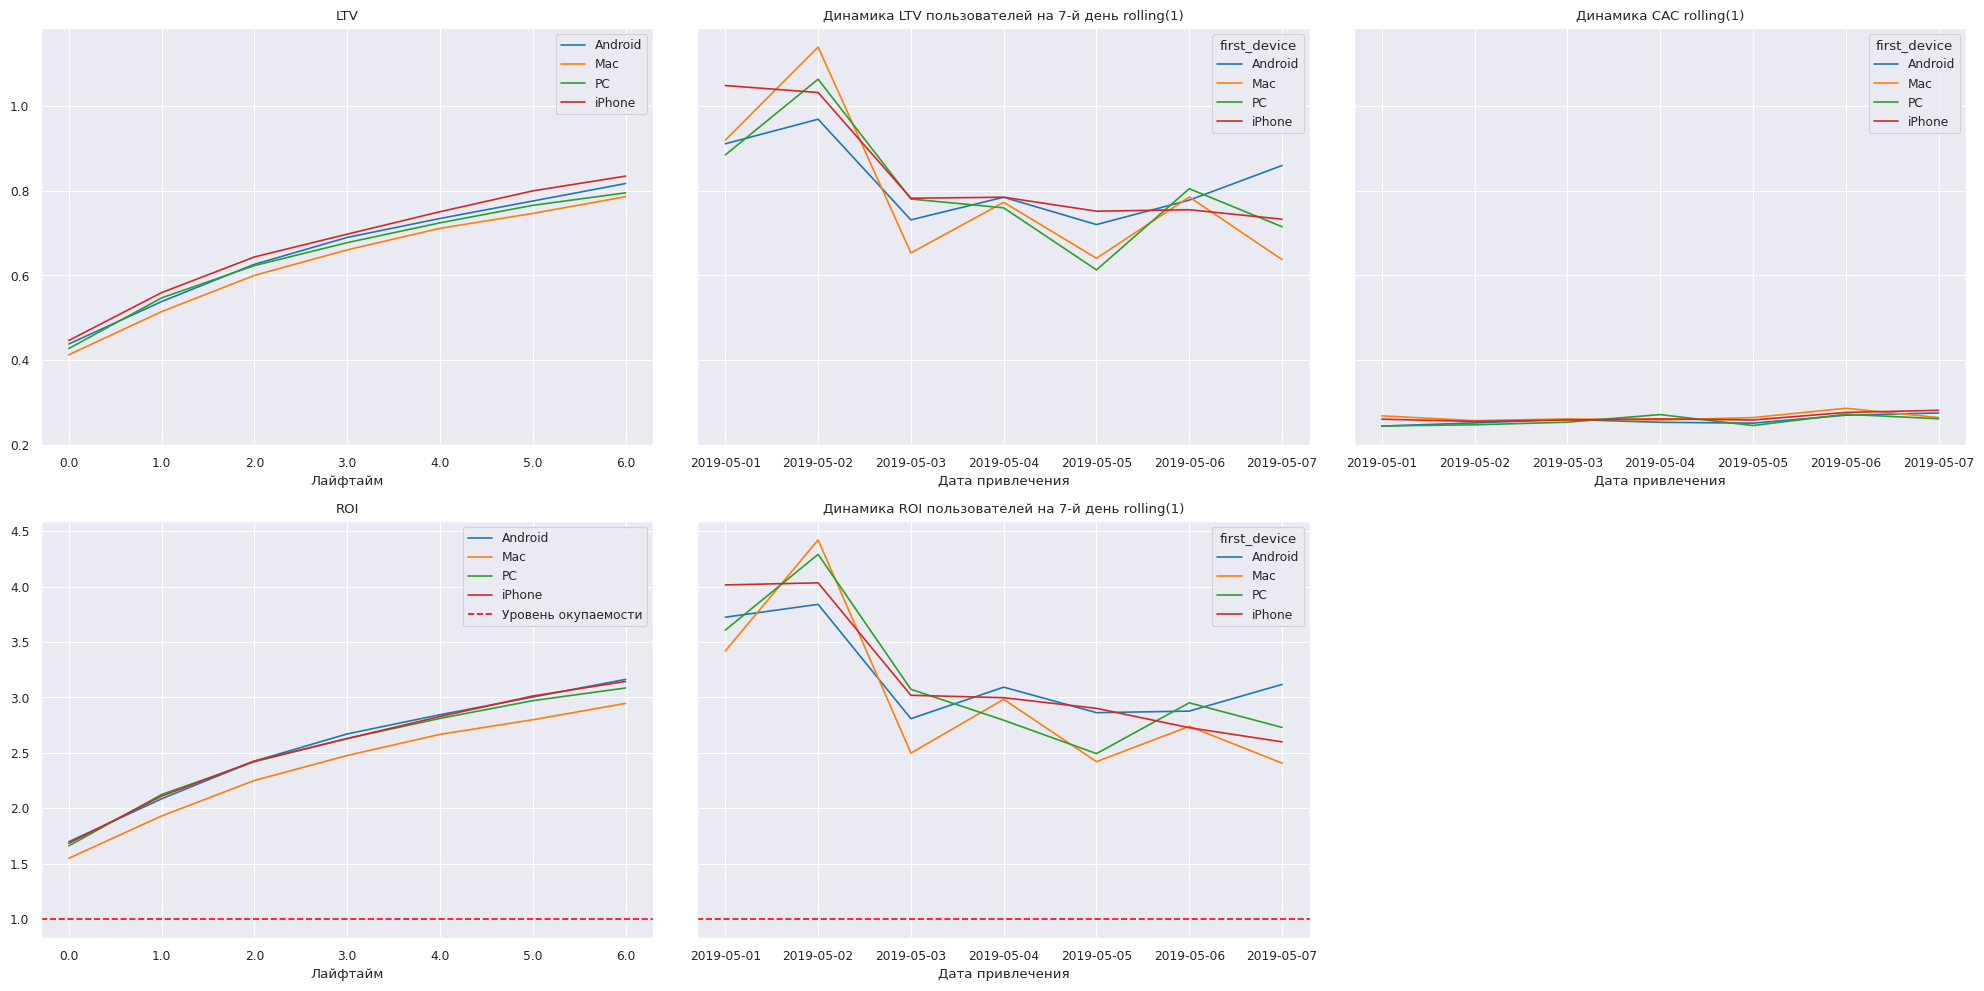

In [56]:
#@title ROI by device
#Для начала оценим общую ситуацию — посмотрим на окупаемость рекламы. Рассчитаем и визуализируем LTV и ROI
_, \
cohorts_revenue, cohorts_ltv, \
cohorts_revenue_dyn, cohorts_ltv_dyn, \
roi, roi_dyn = get_ltv(orders, profiles,
                observation_date=_OBSERVATION_DATE,
                horizon=_HORIZON, ignore_horizon=False,
                #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                dimensions=['first_device']
               )

plot_ltv_roi(cohorts_ltv, cohorts_ltv_dyn, roi, roi_dyn, 7, 1)

lifetime_periods  cohort_size       0.0       1.0       2.0       3.0  \
first_device                                                            
Android                 14316  0.076139  0.085219  0.090738  0.093671   
Mac                     17965  0.073198  0.082104  0.087670  0.090509   
PC                       7496  0.075640  0.085112  0.090048  0.092583   
iPhone                  32116  0.076348  0.085845  0.091543  0.094096   

lifetime_periods       4.0       5.0       6.0  
first_device                                    
Android           0.095627  0.097513  0.099399  
Mac               0.093070  0.094795  0.096020  
PC                0.094851  0.096718  0.097652  
iPhone            0.096836  0.098611  0.099763

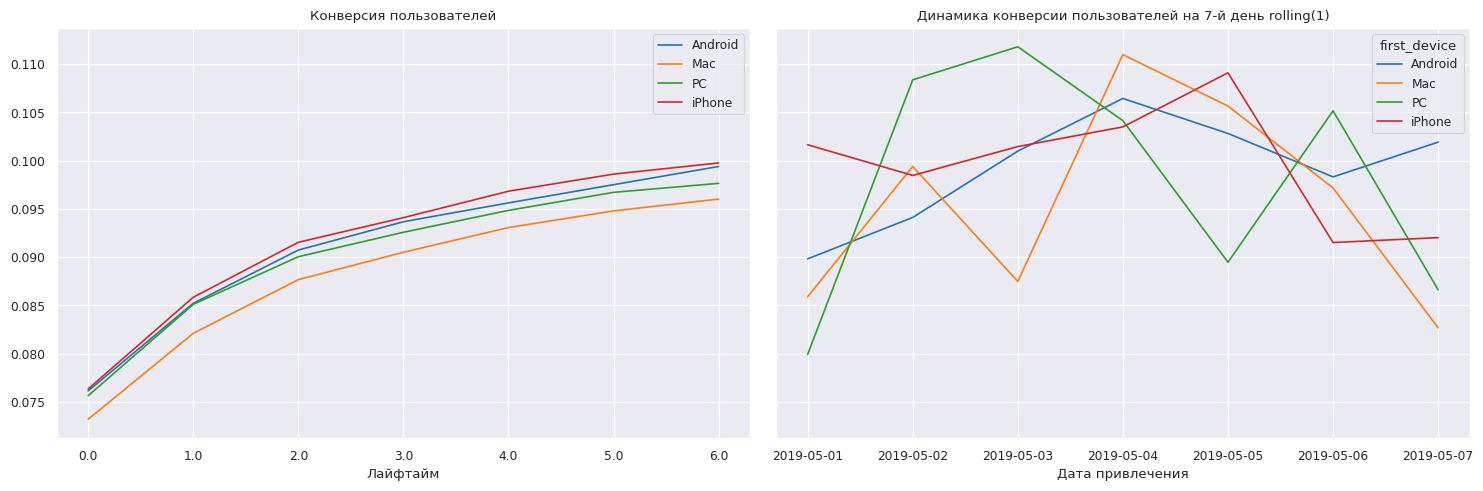

In [57]:
#@title Conversion & dynamics for issue (device)
#Узнаем, в чём причина: в низкой конверсии или низком удержании.
raw, \
cohorts_users, cohorts_conversion, \
cohorts_users_dyn, cohorts_conversion_dyn = get_conversion(orders, profiles,
                                                           observation_date=_OBSERVATION_DATE,
                                                           horizon=_HORIZON, ignore_horizon=False,
                                                           #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                                                           dimensions=['first_device']
                                                          )
display_df(cohorts_conversion)

plot_cohorts_conversion(cohorts_conversion, cohorts_conversion_dyn, _HORIZON, 1)

lifetime_periods             cohort_size    0         1         2         3  \
purchase_event first_device                                                   
False          Android             12850  1.0  0.243191  0.143891  0.102101   
               Mac                 16174  1.0  0.233894  0.146902  0.099172   
               PC                   6744  1.0  0.235024  0.141311  0.100830   
               iPhone              28812  1.0  0.239067  0.142996  0.101902   
True           Android              1466  1.0  0.377217  0.284447  0.218281   
               Mac                  1791  1.0  0.394193  0.296482  0.232272   
               PC                    752  1.0  0.378989  0.284574  0.207447   
               iPhone               3304  1.0  0.375303  0.282385  0.196429   

lifetime_periods                    4         5         6  
purchase_event first_device                                
False          Android       0.077121  0.061012  0.050584  
               Mac           0.075553  0.062817  0.050390  
               PC            0.080813  0.064353  0.055160  
               iPhone        0.076704  0.061329  0.048799  
True           Android       0.167121  0.156207  0.137108  
               Mac           0.184255  0.139587  0.144054  
               PC            0.176862  0.147606  0.130319  
               iPhone        0.184927  0.165860  0.129843

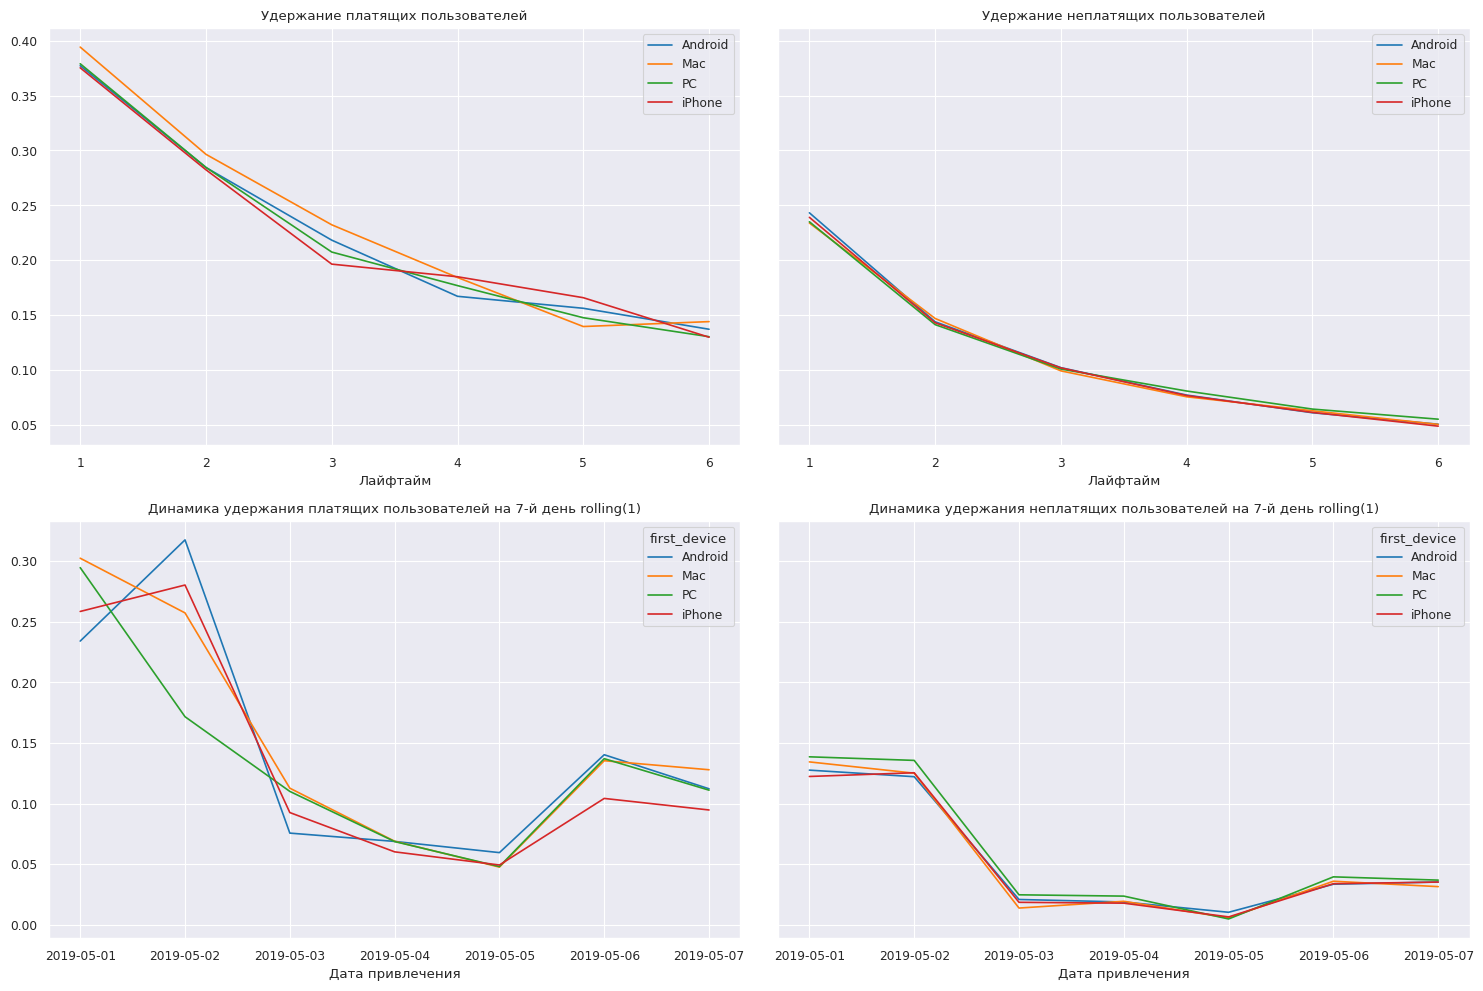

In [58]:
#@title Retention rate & dynamics for issue (device)
_, cohorts_users, cohorts_retention, cohorts_users_dyn, cohorts_retention_dyn = get_retention(sessions, profiles,
                                                               observation_date=_OBSERVATION_DATE,
                                                               horizon=_HORIZON, ignore_horizon=False,
                                                               #first_cohort_moment=(sessions.session_start.min()+timedelta(0)).date(),
                                                               dimensions=['purchase_event', 'first_device']
                                                              )
display_df(cohorts_retention)

plot_cohorts_retention(cohorts_retention, cohorts_retention_dyn, _HORIZON, 1)